# Load modules

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
import os
import numpy as np
import random
import re
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import math
import torchvision
from IPython.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:70% !important; }</style>"))

from useful_functions_notebook_8to13 import *

# Load datasets

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = torch.load('data/dataset_distlognorm_massnorm.pt')
print(dataset[:, 0].mean(), dataset[:, 1].mean())
# mean dist should be 0.0726
# mean mass should be 0.1852

six_branches = torch.load('data/six_branch_norm.pt')
print(six_branches[:, 0].mean(), six_branches[:, 1].mean())
# mean dist should be 0.0633
# mean mass should be 0.1668

tensor(0.0726, dtype=torch.float64) tensor(0.1852, dtype=torch.float64)
tensor(0.0633, dtype=torch.float64) tensor(0.1668, dtype=torch.float64)


# remove empty branches so data have correct shape as in paper

data should have shape (bs, 3, 29, 6)

In [4]:
six_dataset = six_branches[:, :, :, :6]
six_dataset.shape

torch.Size([8161, 3, 29, 6])

# create simple Conv GAN

In [6]:
class Discriminator_big(nn.Module):
    def __init__(self, nvar, nsnap, nbr, printer):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(nvar, 16, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(128, 256, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(11776, 1)
        )
        
        
        self.conv1 = nn.Conv2d(nvar, 16, kernel_size=(1, 3), stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 3), stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 1), stride=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=(3, 1), stride=1)
        self.elu = nn.ELU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(11776, 1)
        self.sigmoid = nn.Sigmoid()
        
        self.printer = printer

    def forward(self, x):
        if self.printer:
            print("\nDiscriminator:")
            print("0:", x.shape)
            x = self.elu(self.conv1(x))
            print("1:", x.shape)
            x = self.elu(self.conv2(x))
            print("2:", x.shape)
            x = self.elu(self.conv3(x))
            print("3:", x.shape)
            x = self.elu(self.conv4(x))
            print("4:", x.shape)
            x = self.elu(self.conv5(x))
            print("5:", x.shape)
            x = self.flatten(x)
            print("6:", x.shape)
            x = self.linear(x)
            x = self.sigmoid(x)

            return x
        else:
            
            return self.layers(x)


class Encoder_big(nn.Module):
    def __init__(self, nvar, nsnap, nbr, latent_size, printer):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(nvar, 16, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(128, 256, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(11776, latent_size),
        )
        
        self.conv1 = nn.Conv2d(nvar, 16, kernel_size=(1, 3), stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 3), stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 1), stride=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=(3, 1), stride=1)
        self.elu = nn.ELU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(11776, latent_size)
        
        self.printer = printer

    def forward(self, x):
        if self.printer:
            print("\nEncoder:")
            print("0:", x.shape)
            x = self.elu(self.conv1(x))
            print("1:", x.shape)
            x = self.elu(self.conv2(x))
            print("2:", x.shape)
            x = self.elu(self.conv3(x))
            print("3:", x.shape)
            x = self.elu(self.conv4(x))
            print("4:", x.shape)
            x = self.elu(self.conv5(x))
            print("5:", x.shape)
            x = self.flatten(x)
            print("6:", x.shape)
            x = self.linear(x)
            print("7:", x.shape)

            return x
        
        else:
            x = self.layers(x)
            return x


class Generator_big(nn.Module):
    def __init__(self, nvar, nsnap, nbr, latent_size, printer):
        super().__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(32, 16, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(16, nvar, kernel_size=(1, 3), stride=1),
            nn.ReLU(),
        )
        
        self.linear = nn.Linear(latent_size, 11776)
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=(3, 1), stride=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 1), stride=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 1), stride=1)
        self.deconv4 = nn.ConvTranspose2d(32, 16, kernel_size=(1, 3), stride=1)
        self.deconv5 = nn.ConvTranspose2d(16, nvar, kernel_size=(1, 3), stride=1)
        
        self.printer = printer


    def forward(self, x):
        if self.printer:
            print("\nGenerator:")
            print("0:", x.shape)
            x = self.elu(self.linear(x))
            print("1:", x.shape)
            x = x.view(-1, 256, 23, 2)
            print("2:", x.shape)
            x = self.elu(self.deconv1(x))
            print("3:", x.shape)
            x = self.elu(self.deconv2(x))
            print("4:", x.shape)
            x = self.elu(self.deconv3(x))
            print("5:", x.shape)
            x = self.elu(self.deconv4(x))
            print("6:", x.shape)
            x = self.sigmoid(self.deconv5(x))
            print("7:", x.shape)

            return x
        else:
            x = self.elu(self.linear(x))
            x = x.view(-1, 256, 23, 2)

            return self.layers(x)
        

# reconstruction loss, classic generator loss and classic discriminator loss

In [8]:
def custom_reconstruction_loss(output, target, scale = 10):
    # Calculate the reconstruction loss
    recon_loss = F.mse_loss(output, target, reduction='none')
    
    # Apply higher penalty if target is zero
    penalty = torch.where((target == 0.0) |(target == 0.5) | (target == 1.0), scale * recon_loss, recon_loss)
    
    # Calculate the mean loss
    mean_loss = torch.mean(penalty)
    
    return mean_loss

def generator_classic_loss(disc_gen_values, epsilon = 1e-5):
    
    loss = 1 / len(disc_gen_values) * torch.sum(torch.log(disc_gen_values + epsilon))
    
    return loss



def discriminator_classic_loss(disc_real_values, disc_gen_values, epsilon = 1e-5):
    
    loss = 1 / len(disc_gen_values) * torch.sum(torch.log(disc_real_values + epsilon) + torch.log(1 - disc_gen_values + epsilon))
    
    return loss

# training loops

# successful attempt #1

### - only data with 6 branches
### - BCEWithLogitsLoss
### - recon scale = 10
### - num_train_gen = 1
### - uniform noise

Epoch: 1 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:31<00:00,  1.42s/it]

real image:


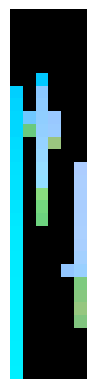

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


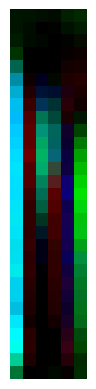

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


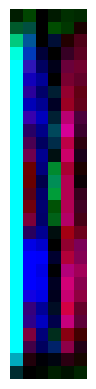

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


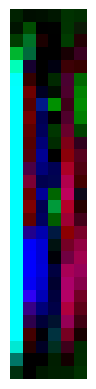

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


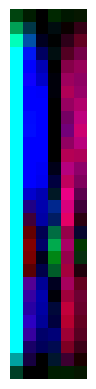

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


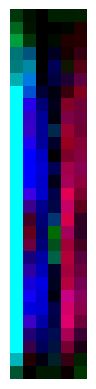

Epoch [0/300], Batch 0/64, Discriminator Loss: 0.2846, Generator Loss: 2.5410
tensor([[2.4936],
        [1.8394],
        [1.3629]], requires_grad=True)
tensor([[-0.9538],
        [-2.4688],
        [-2.9927]], requires_grad=True)
mean disc rating of real images: tensor(2.3674)
mean disc rating of fake images: tensor(-1.2931)
Epoch: 2 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:32<00:00,  1.45s/it]

real image:


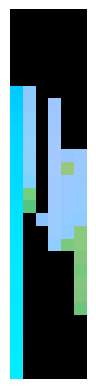

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


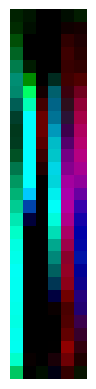

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


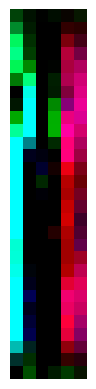

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


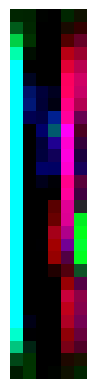

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


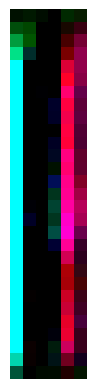

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


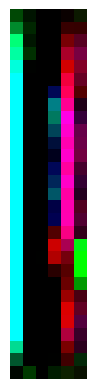

Epoch [1/300], Batch 0/64, Discriminator Loss: 0.5481, Generator Loss: 1.4383
tensor([[ 2.5194],
        [ 0.3425],
        [-0.7777]], requires_grad=True)
tensor([[ 0.1708],
        [-0.1830],
        [-2.1349]], requires_grad=True)
mean disc rating of real images: tensor(1.0152)
mean disc rating of fake images: tensor(-0.2430)
Epoch: 3 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:46<00:00,  1.66s/it]

real image:


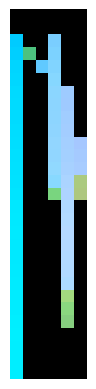

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


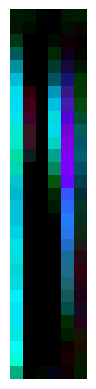

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


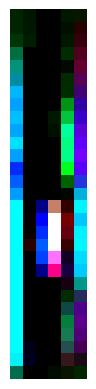

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


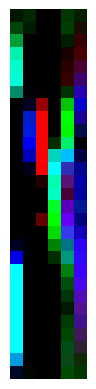

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


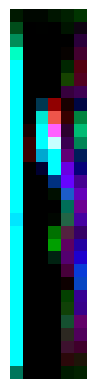

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


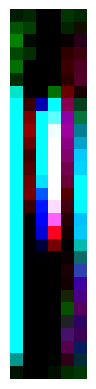

Epoch [2/300], Batch 0/64, Discriminator Loss: 0.5865, Generator Loss: 1.2122
tensor([[1.6101],
        [2.0136],
        [0.2627]], requires_grad=True)
tensor([[ 0.7915],
        [-2.0987],
        [-0.4433]], requires_grad=True)
mean disc rating of real images: tensor(0.5952)
mean disc rating of fake images: tensor(-0.4683)
Epoch: 4 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:33<00:00,  1.46s/it]

real image:


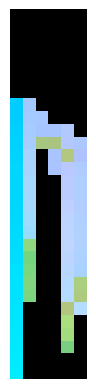

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


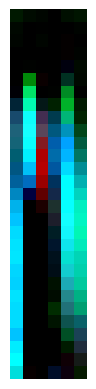

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


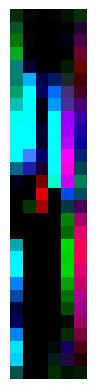

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


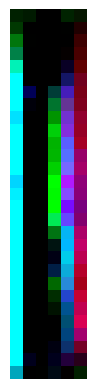

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/300], Batch 0/64, Discriminator Loss: 0.5990, Generator Loss: 0.9875
tensor([[-0.1073],
        [-0.1785],
        [ 0.3800]], requires_grad=True)
tensor([[ 0.0346],
        [ 0.2318],
        [-1.0952]], requires_grad=True)
mean disc rating of real images: tensor(0.3561)
mean disc rating of fake images: tensor(-0.2991)
Epoch: 5 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:33<00:00,  1.47s/it]

real image:


reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


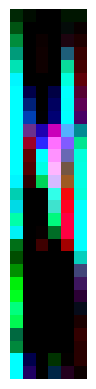

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


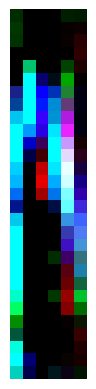

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


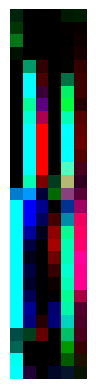

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


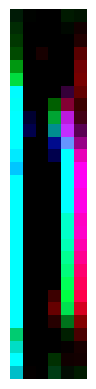

Epoch [4/300], Batch 0/64, Discriminator Loss: 0.4666, Generator Loss: 1.0425
tensor([[1.2948],
        [2.4512],
        [1.0936]], requires_grad=True)
tensor([[-0.7868],
        [-0.0870],
        [-0.5260]], requires_grad=True)
mean disc rating of real images: tensor(0.5100)
mean disc rating of fake images: tensor(-0.7693)
Epoch: 6 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:34<00:00,  1.48s/it]

real image:


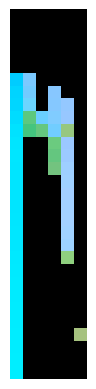

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


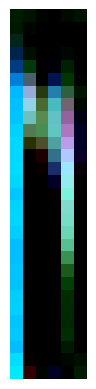

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


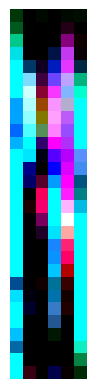

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


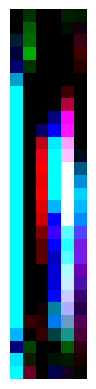

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


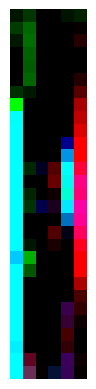

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [5/300], Batch 0/64, Discriminator Loss: 0.6490, Generator Loss: 0.9510
tensor([[ 0.0912],
        [-0.5334],
        [ 0.0717]], requires_grad=True)
tensor([[-0.0539],
        [-1.4009],
        [-1.3913]], requires_grad=True)
mean disc rating of real images: tensor(0.1323)
mean disc rating of fake images: tensor(-0.2636)
Epoch: 7 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


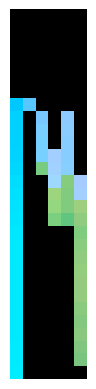

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


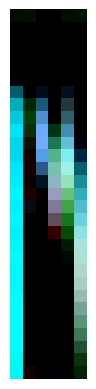

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


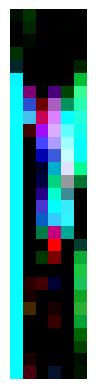

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


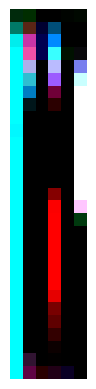

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


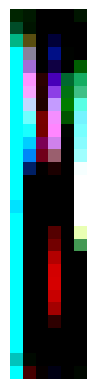

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [6/300], Batch 0/64, Discriminator Loss: 0.6515, Generator Loss: 0.9553
tensor([[ 0.4032],
        [-0.5319],
        [ 1.1016]], requires_grad=True)
tensor([[0.0789],
        [0.4155],
        [0.6710]], requires_grad=True)
mean disc rating of real images: tensor(0.4397)
mean disc rating of fake images: tensor(0.0808)
Epoch: 8 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


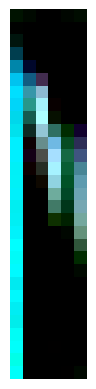

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


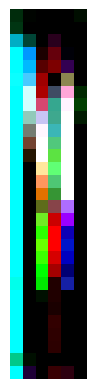

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


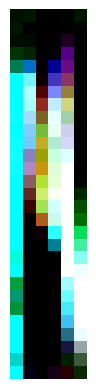

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [7/300], Batch 0/64, Discriminator Loss: 0.6770, Generator Loss: 0.5517
tensor([[-0.6120],
        [-0.1986],
        [-0.2770]], requires_grad=True)
tensor([[-0.2195],
        [-0.9402],
        [-0.7667]], requires_grad=True)
mean disc rating of real images: tensor(-0.3440)
mean disc rating of fake images: tensor(-0.6188)
Epoch: 9 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


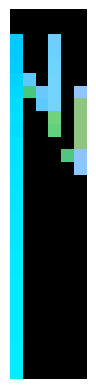

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


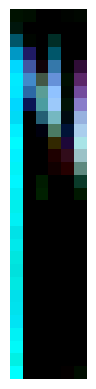

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


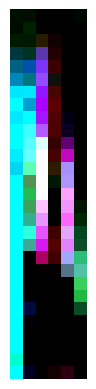

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


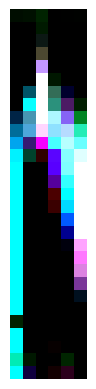

Epoch [8/300], Batch 0/64, Discriminator Loss: 0.7438, Generator Loss: 0.4498
tensor([[-0.8127],
        [-0.8949],
        [-1.0187]], requires_grad=True)
tensor([[-0.5444],
        [-0.7070],
        [-1.1823]], requires_grad=True)
mean disc rating of real images: tensor(-0.7189)
mean disc rating of fake images: tensor(-0.8664)
Epoch: 10 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.36s/it]

real image:


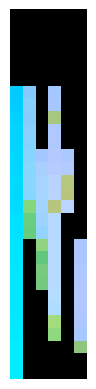

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


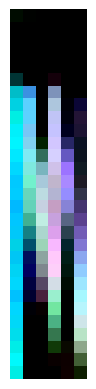

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


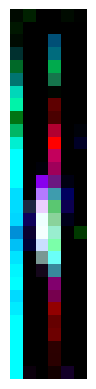

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [9/300], Batch 0/64, Discriminator Loss: 0.7395, Generator Loss: 0.7730
tensor([[ 0.7891],
        [-1.0041],
        [-0.2891]], requires_grad=True)
tensor([[-0.3863],
        [ 0.0095],
        [ 0.1330]], requires_grad=True)
mean disc rating of real images: tensor(-0.1366)
mean disc rating of fake images: tensor(-0.0303)
Epoch: 11 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.36s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


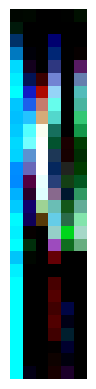

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


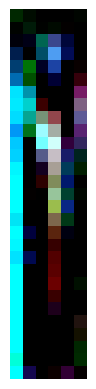

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


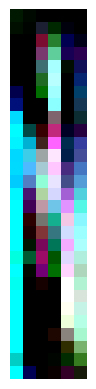

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


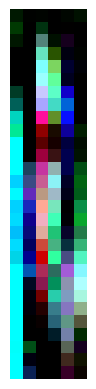

Epoch [10/300], Batch 0/64, Discriminator Loss: 0.7185, Generator Loss: 0.7063
tensor([[ 0.2049],
        [ 0.0988],
        [-0.2019]], requires_grad=True)
tensor([[0.2708],
        [0.0759],
        [0.5627]], requires_grad=True)
mean disc rating of real images: tensor(0.0458)
mean disc rating of fake images: tensor(0.1103)
Epoch: 12 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


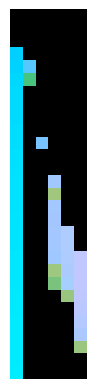

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


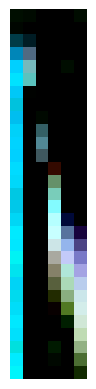

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


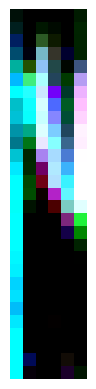

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


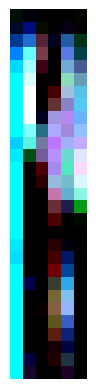

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [11/300], Batch 0/64, Discriminator Loss: 0.7216, Generator Loss: 0.5937
tensor([[-0.1284],
        [-0.0953],
        [ 0.0062]], requires_grad=True)
tensor([[-0.2135],
        [ 0.2763],
        [-0.0330]], requires_grad=True)
mean disc rating of real images: tensor(-0.1440)
mean disc rating of fake images: tensor(-0.0512)
Epoch: 13 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.36s/it]

real image:


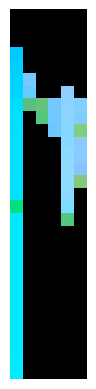

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


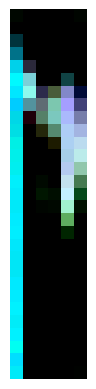

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


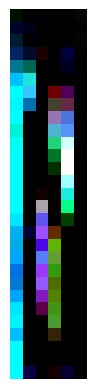

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [12/300], Batch 0/64, Discriminator Loss: 0.6905, Generator Loss: 0.6756
tensor([[-0.0758],
        [ 0.0981],
        [ 0.1386]], requires_grad=True)
tensor([[ 0.0198],
        [-0.0660],
        [ 0.2504]], requires_grad=True)
mean disc rating of real images: tensor(-0.0120)
mean disc rating of fake images: tensor(-0.0359)
Epoch: 14 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.36s/it]

real image:


reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


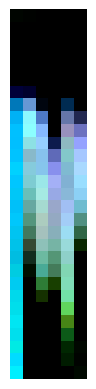

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


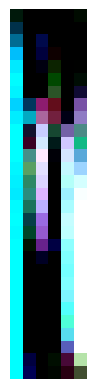

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


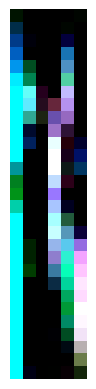

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [13/300], Batch 0/64, Discriminator Loss: 0.6964, Generator Loss: 0.6594
tensor([[-0.4492],
        [-0.3841],
        [-0.0158]], requires_grad=True)
tensor([[-0.0705],
        [-0.1505],
        [-0.2873]], requires_grad=True)
mean disc rating of real images: tensor(-0.1507)
mean disc rating of fake images: tensor(-0.1680)
Epoch: 15 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.36s/it]

real image:


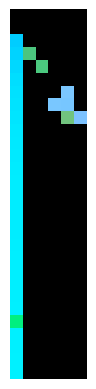

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


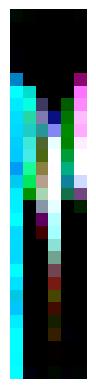

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


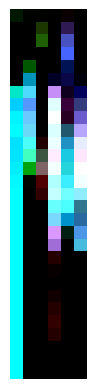

Epoch [14/300], Batch 0/64, Discriminator Loss: 0.7007, Generator Loss: 0.5726
tensor([[-0.2837],
        [-0.3704],
        [-0.0105]], requires_grad=True)
tensor([[-0.5201],
        [-0.4441],
        [-0.3596]], requires_grad=True)
mean disc rating of real images: tensor(-0.3162)
mean disc rating of fake images: tensor(-0.3585)
Epoch: 16 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.37s/it]

real image:


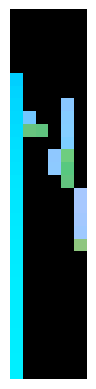

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


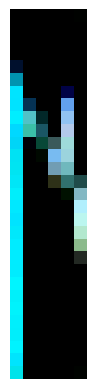

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


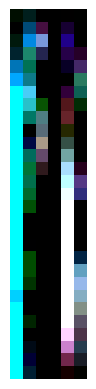

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


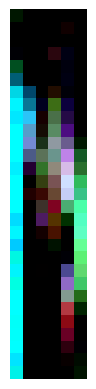

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


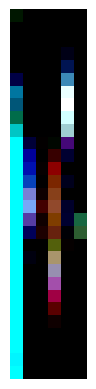

Epoch [15/300], Batch 0/64, Discriminator Loss: 0.6776, Generator Loss: 0.7882
tensor([[-0.1594],
        [ 0.0792],
        [ 0.0053]], requires_grad=True)
tensor([[ 0.2055],
        [-0.2414],
        [ 0.0164]], requires_grad=True)
mean disc rating of real images: tensor(-0.0084)
mean disc rating of fake images: tensor(-0.0917)
Epoch: 17 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.37s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


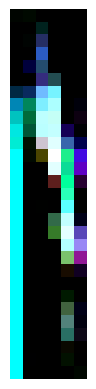

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


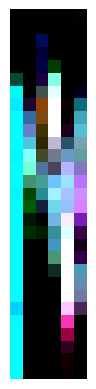

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [16/300], Batch 0/64, Discriminator Loss: 0.7021, Generator Loss: 0.7385
tensor([[ 0.1487],
        [-0.2538],
        [ 0.1872]], requires_grad=True)
tensor([[0.0431],
        [0.2023],
        [0.0496]], requires_grad=True)
mean disc rating of real images: tensor(0.0118)
mean disc rating of fake images: tensor(0.0356)
Epoch: 18 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.37s/it]

real image:


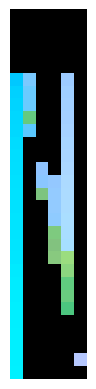

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


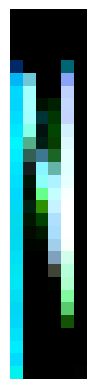

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


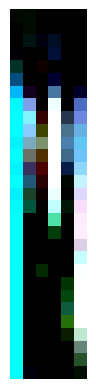

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


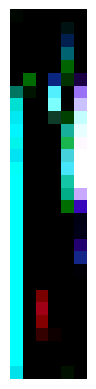

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [17/300], Batch 0/64, Discriminator Loss: 0.6826, Generator Loss: 0.7629
tensor([[ 0.3393],
        [-0.0426],
        [-0.1414]], requires_grad=True)
tensor([[-0.0542],
        [ 0.0213],
        [ 0.3384]], requires_grad=True)
mean disc rating of real images: tensor(0.0696)
mean disc rating of fake images: tensor(0.0042)
Epoch: 19 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


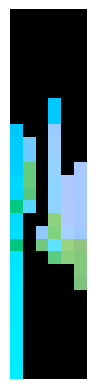

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


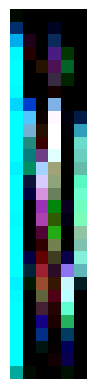

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


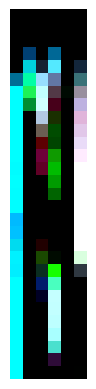

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


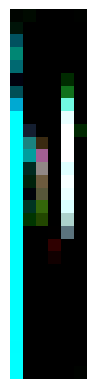

Epoch [18/300], Batch 0/64, Discriminator Loss: 0.6799, Generator Loss: 0.6781
tensor([[ 0.0174],
        [-0.0979],
        [-0.2214]], requires_grad=True)
tensor([[-0.1320],
        [-0.0135],
        [-0.1095]], requires_grad=True)
mean disc rating of real images: tensor(-0.0479)
mean disc rating of fake images: tensor(-0.1272)
Epoch: 20 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.36s/it]

real image:


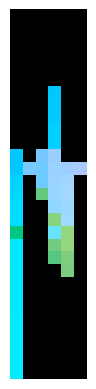

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


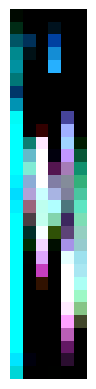

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


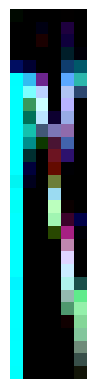

Epoch [19/300], Batch 0/64, Discriminator Loss: 0.6881, Generator Loss: 0.7876
tensor([[-0.0365],
        [ 0.1882],
        [ 0.1343]], requires_grad=True)
tensor([[ 0.2967],
        [ 0.1675],
        [-0.1267]], requires_grad=True)
mean disc rating of real images: tensor(0.1013)
mean disc rating of fake images: tensor(0.0674)
Epoch: 21 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.36s/it]

real image:


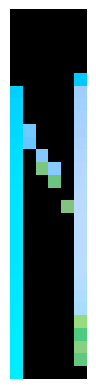

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


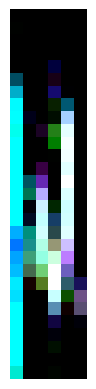

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


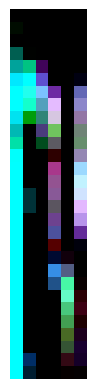

Epoch [20/300], Batch 0/64, Discriminator Loss: 0.6839, Generator Loss: 0.7355
tensor([[-0.1420],
        [ 0.1367],
        [-0.1644]], requires_grad=True)
tensor([[ 0.1210],
        [-0.1205],
        [ 0.0038]], requires_grad=True)
mean disc rating of real images: tensor(0.0812)
mean disc rating of fake images: tensor(0.0236)
Epoch: 22 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


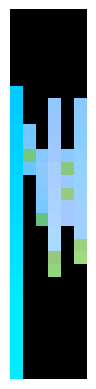

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


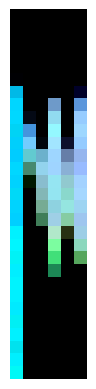

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


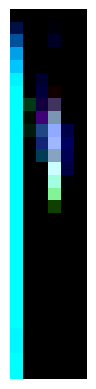

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


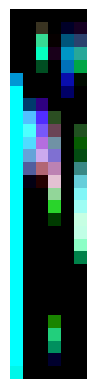

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


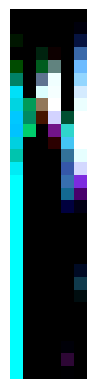

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


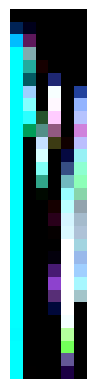

Epoch [21/300], Batch 0/64, Discriminator Loss: 0.6770, Generator Loss: 0.8104
tensor([[0.2749],
        [0.2452],
        [0.1705]], requires_grad=True)
tensor([[ 0.2155],
        [-0.1183],
        [ 0.2142]], requires_grad=True)
mean disc rating of real images: tensor(0.1573)
mean disc rating of fake images: tensor(0.0685)
Epoch: 23 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


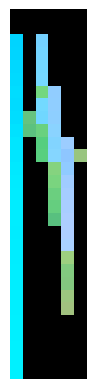

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


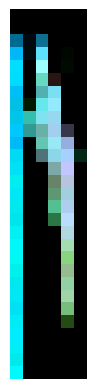

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


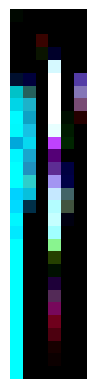

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


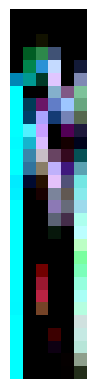

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


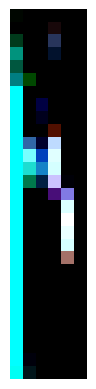

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


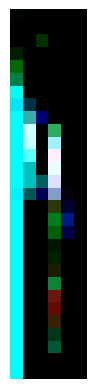

Epoch [22/300], Batch 0/64, Discriminator Loss: 0.6893, Generator Loss: 0.7261
tensor([[0.2878],
        [0.2435],
        [0.2004]], requires_grad=True)
tensor([[ 0.0631],
        [ 0.0474],
        [-0.0212]], requires_grad=True)
mean disc rating of real images: tensor(0.0317)
mean disc rating of fake images: tensor(0.0081)
Epoch: 24 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


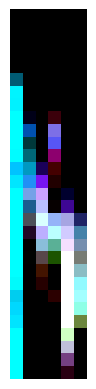

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


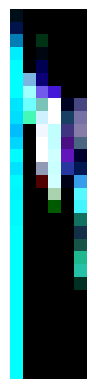

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


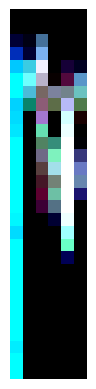

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


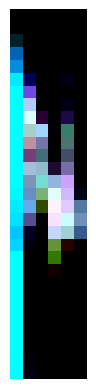

Epoch [23/300], Batch 0/64, Discriminator Loss: 0.6861, Generator Loss: 0.7501
tensor([[-0.2646],
        [-0.0756],
        [-0.0809]], requires_grad=True)
tensor([[-0.1937],
        [-0.3102],
        [-0.5051]], requires_grad=True)
mean disc rating of real images: tensor(0.0085)
mean disc rating of fake images: tensor(-0.0665)
Epoch: 25 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


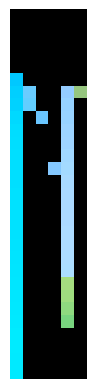

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


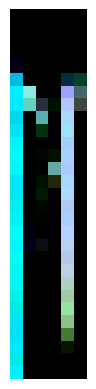

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


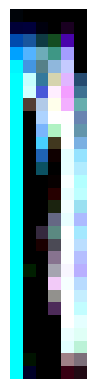

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


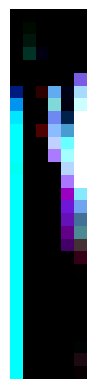

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


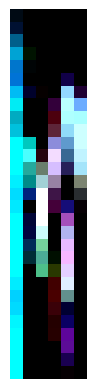

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


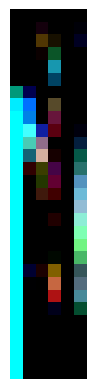

Epoch [24/300], Batch 0/64, Discriminator Loss: 0.6889, Generator Loss: 0.6665
tensor([[-0.0452],
        [-0.0781],
        [-0.0962]], requires_grad=True)
tensor([[-0.3898],
        [-0.0174],
        [-0.3882]], requires_grad=True)
mean disc rating of real images: tensor(-0.1658)
mean disc rating of fake images: tensor(-0.2097)
Epoch: 26 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


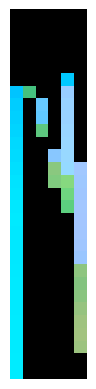

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


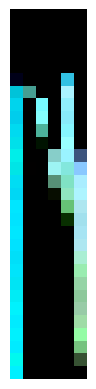

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


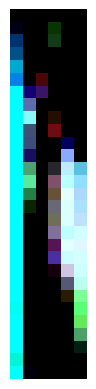

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


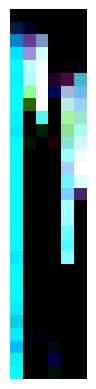

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


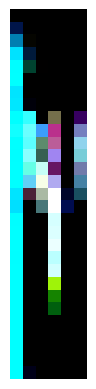

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


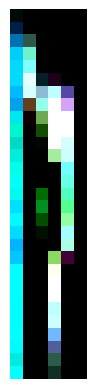

Epoch [25/300], Batch 0/64, Discriminator Loss: 0.6827, Generator Loss: 0.8491
tensor([[0.5722],
        [0.8187],
        [0.0051]], requires_grad=True)
tensor([[ 0.1702],
        [-0.0321],
        [-0.0083]], requires_grad=True)
mean disc rating of real images: tensor(0.1392)
mean disc rating of fake images: tensor(0.0408)
Epoch: 27 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


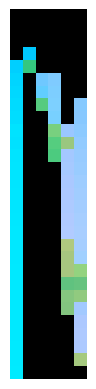

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


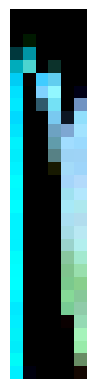

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


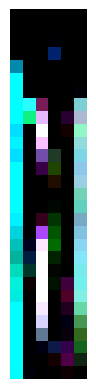

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


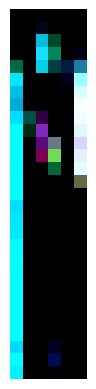

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


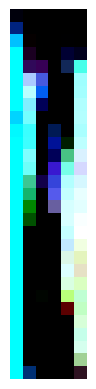

Epoch [26/300], Batch 0/64, Discriminator Loss: 0.7073, Generator Loss: 0.6844
tensor([[ 0.1681],
        [-0.4017],
        [-0.2230]], requires_grad=True)
tensor([[ 0.0772],
        [-0.0908],
        [ 0.1601]], requires_grad=True)
mean disc rating of real images: tensor(-0.0949)
mean disc rating of fake images: tensor(-0.0987)
Epoch: 28 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


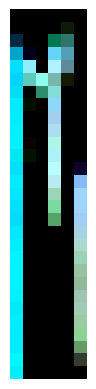

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


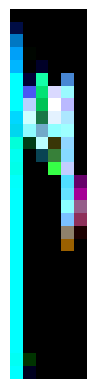

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


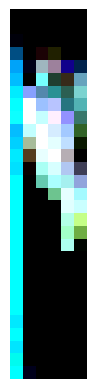

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


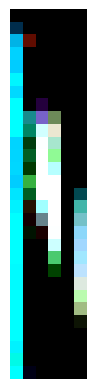

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


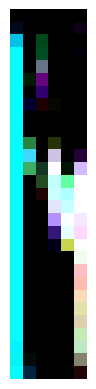

Epoch [27/300], Batch 0/64, Discriminator Loss: 0.6925, Generator Loss: 0.7102
tensor([[-0.1257],
        [ 0.3007],
        [ 0.0131]], requires_grad=True)
tensor([[ 0.0704],
        [-0.0207],
        [-0.2064]], requires_grad=True)
mean disc rating of real images: tensor(-0.1142)
mean disc rating of fake images: tensor(-0.1519)
Epoch: 29 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.37s/it]

real image:


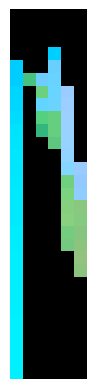

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


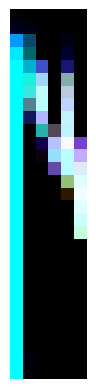

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [28/300], Batch 0/64, Discriminator Loss: 0.6934, Generator Loss: 0.6515
tensor([[-0.1545],
        [-0.0745],
        [-0.1804]], requires_grad=True)
tensor([[-0.4378],
        [ 0.2221],
        [-0.1695]], requires_grad=True)
mean disc rating of real images: tensor(-0.1329)
mean disc rating of fake images: tensor(-0.1614)
Epoch: 30 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


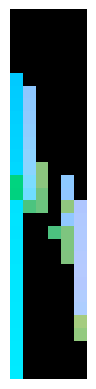

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


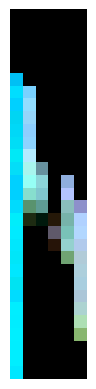

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


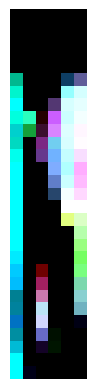

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


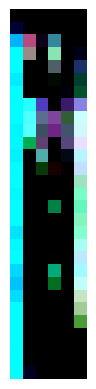

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


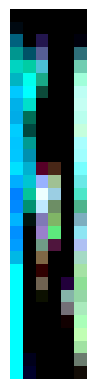

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


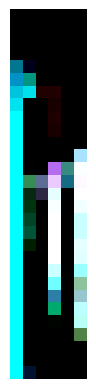

Epoch [29/300], Batch 0/64, Discriminator Loss: 0.6923, Generator Loss: 0.7136
tensor([[ 0.0246],
        [-0.3237],
        [-0.2534]], requires_grad=True)
tensor([[-0.1218],
        [-0.3565],
        [ 0.4971]], requires_grad=True)
mean disc rating of real images: tensor(-0.0088)
mean disc rating of fake images: tensor(-0.0282)
Epoch: 31 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.37s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


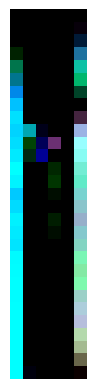

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


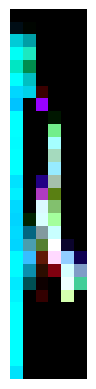

Epoch [30/300], Batch 0/64, Discriminator Loss: 0.6862, Generator Loss: 0.7448
tensor([[ 0.1265],
        [ 0.1768],
        [-0.0214]], requires_grad=True)
tensor([[-0.0280],
        [ 0.2685],
        [ 0.3798]], requires_grad=True)
mean disc rating of real images: tensor(0.0999)
mean disc rating of fake images: tensor(0.0531)
Epoch: 32 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


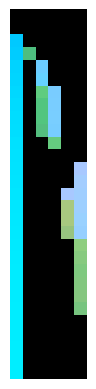

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


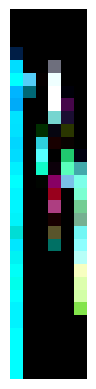

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


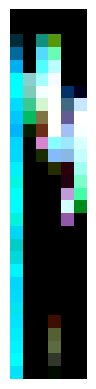

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


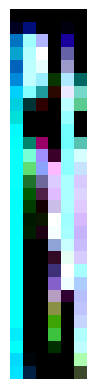

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


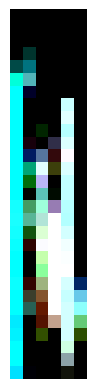

Epoch [31/300], Batch 0/64, Discriminator Loss: 0.7103, Generator Loss: 0.7083
tensor([[ 0.1536],
        [ 0.0075],
        [-0.5673]], requires_grad=True)
tensor([[-0.0815],
        [ 0.2058],
        [ 0.1058]], requires_grad=True)
mean disc rating of real images: tensor(-0.0524)
mean disc rating of fake images: tensor(-0.0109)
Epoch: 33 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:39<00:00,  1.55s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


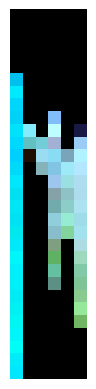

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


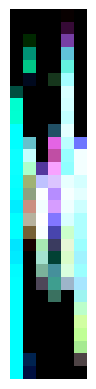

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


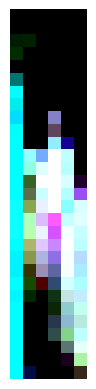

Epoch [32/300], Batch 0/64, Discriminator Loss: 0.6892, Generator Loss: 0.7431
tensor([[-0.0961],
        [ 0.0056],
        [ 0.0091]], requires_grad=True)
tensor([[-0.0195],
        [-0.1932],
        [-0.1047]], requires_grad=True)
mean disc rating of real images: tensor(-0.0215)
mean disc rating of fake images: tensor(-0.0538)
Epoch: 34 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:48<00:00,  1.69s/it]

real image:


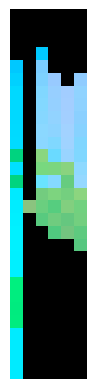

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


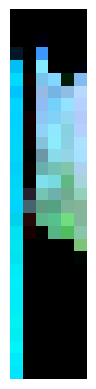

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


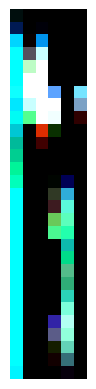

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


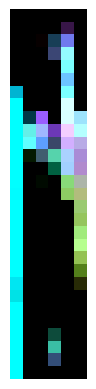

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


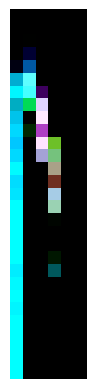

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


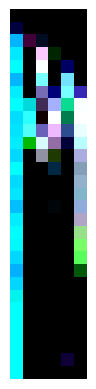

Epoch [33/300], Batch 0/64, Discriminator Loss: 0.6924, Generator Loss: 0.7193
tensor([[-0.1521],
        [-0.2671],
        [-0.2974]], requires_grad=True)
tensor([[-0.3855],
        [-0.0648],
        [ 0.0713]], requires_grad=True)
mean disc rating of real images: tensor(-0.0711)
mean disc rating of fake images: tensor(-0.0996)
Epoch: 35 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:42<00:00,  1.60s/it]

real image:


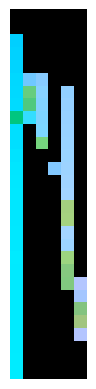

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


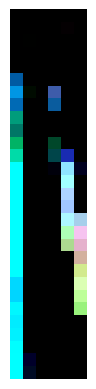

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


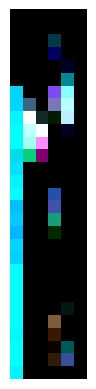

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


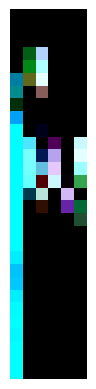

Epoch [34/300], Batch 0/64, Discriminator Loss: 0.6986, Generator Loss: 0.7509
tensor([[-0.0392],
        [-0.0213],
        [ 0.2303]], requires_grad=True)
tensor([[ 0.0616],
        [ 0.2079],
        [-0.0993]], requires_grad=True)
mean disc rating of real images: tensor(0.0723)
mean disc rating of fake images: tensor(0.0806)
Epoch: 36 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:40<00:00,  1.57s/it]

real image:


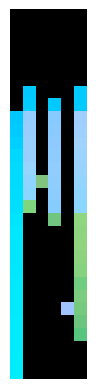

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


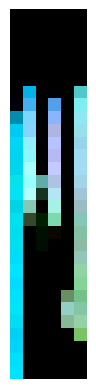

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


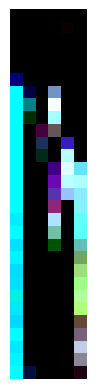

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


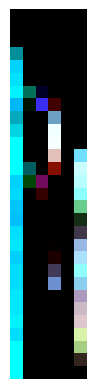

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [35/300], Batch 0/64, Discriminator Loss: 0.6778, Generator Loss: 0.7129
tensor([[-0.0445],
        [-0.3230],
        [-0.0636]], requires_grad=True)
tensor([[-0.0009],
        [-0.1559],
        [ 0.1659]], requires_grad=True)
mean disc rating of real images: tensor(0.0627)
mean disc rating of fake images: tensor(-0.0080)
Epoch: 37 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:41<00:00,  1.58s/it]

real image:


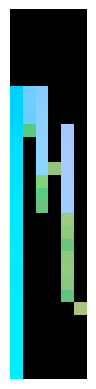

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


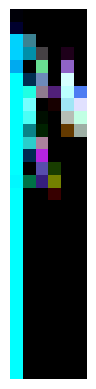

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


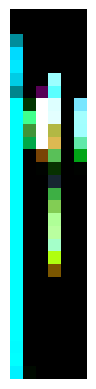

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


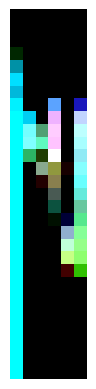

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


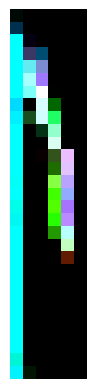

Epoch [36/300], Batch 0/64, Discriminator Loss: 0.6901, Generator Loss: 0.7015
tensor([[ 0.0690],
        [ 0.1877],
        [-0.0631]], requires_grad=True)
tensor([[0.2048],
        [0.0353],
        [0.1419]], requires_grad=True)
mean disc rating of real images: tensor(0.0073)
mean disc rating of fake images: tensor(-0.0134)
Epoch: 38 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:37<00:00,  1.52s/it]

real image:


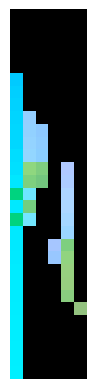

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


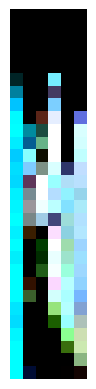

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


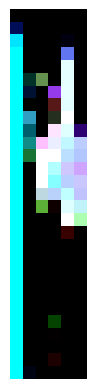

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


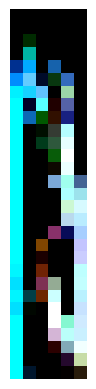

Epoch [37/300], Batch 0/64, Discriminator Loss: 0.6905, Generator Loss: 0.7308
tensor([[ 0.1427],
        [-0.2100],
        [-0.2060]], requires_grad=True)
tensor([[-0.2070],
        [ 0.0228],
        [-0.2381]], requires_grad=True)
mean disc rating of real images: tensor(0.0518)
mean disc rating of fake images: tensor(0.0116)
Epoch: 39 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.48s/it]

real image:


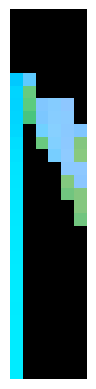

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


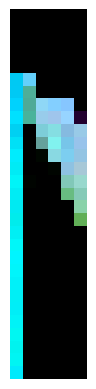

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


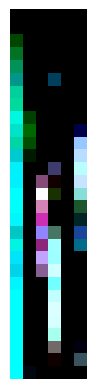

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


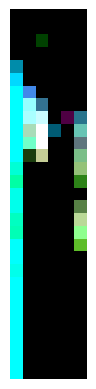

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


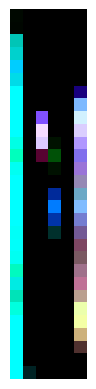

Epoch [38/300], Batch 0/64, Discriminator Loss: 0.6897, Generator Loss: 0.7393
tensor([[ 0.0378],
        [-0.2834],
        [-0.0408]], requires_grad=True)
tensor([[0.0808],
        [0.2748],
        [0.0066]], requires_grad=True)
mean disc rating of real images: tensor(0.0025)
mean disc rating of fake images: tensor(-0.0224)
Epoch: 40 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:42<00:00,  1.60s/it]

real image:


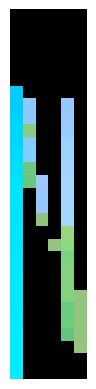

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


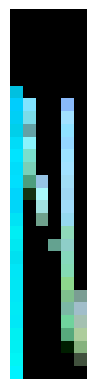

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


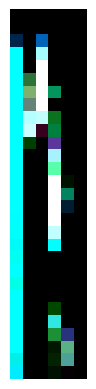

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


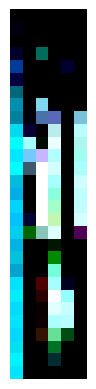

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


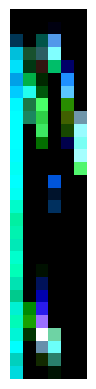

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [39/300], Batch 0/64, Discriminator Loss: 0.7027, Generator Loss: 0.7560
tensor([[0.1135],
        [0.2239],
        [0.5931]], requires_grad=True)
tensor([[ 0.1939],
        [-0.1095],
        [-0.3188]], requires_grad=True)
mean disc rating of real images: tensor(0.0047)
mean disc rating of fake images: tensor(0.0181)
Epoch: 41 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:40<00:00,  1.57s/it]

real image:


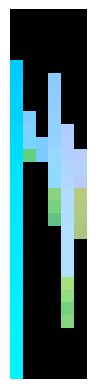

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


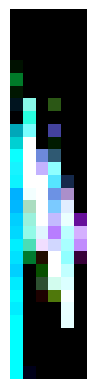

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


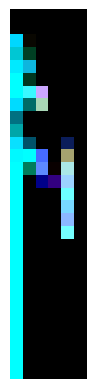

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [40/300], Batch 0/64, Discriminator Loss: 0.6995, Generator Loss: 0.6684
tensor([[ 0.1064],
        [-0.4024],
        [ 0.2812]], requires_grad=True)
tensor([[ 0.1723],
        [-0.0014],
        [ 0.3393]], requires_grad=True)
mean disc rating of real images: tensor(-0.0304)
mean disc rating of fake images: tensor(-0.0185)
Epoch: 42 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:43<00:00,  1.61s/it]

real image:


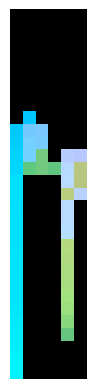

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


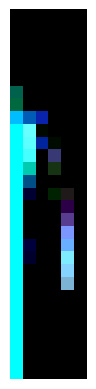

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


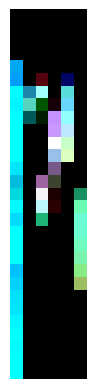

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [41/300], Batch 0/64, Discriminator Loss: 0.6932, Generator Loss: 0.7116
tensor([[-0.1009],
        [ 0.0192],
        [-0.0947]], requires_grad=True)
tensor([[-0.1591],
        [ 0.0342],
        [-0.0654]], requires_grad=True)
mean disc rating of real images: tensor(0.0283)
mean disc rating of fake images: tensor(0.0230)
Epoch: 43 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.50s/it]

real image:


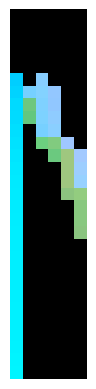

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


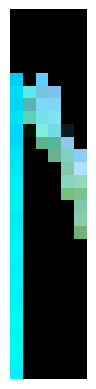

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


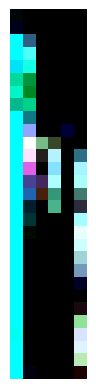

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


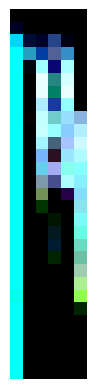

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


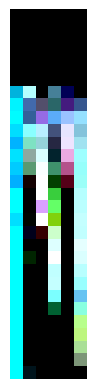

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [42/300], Batch 0/64, Discriminator Loss: 0.6906, Generator Loss: 0.7059
tensor([[ 0.0622],
        [-0.0747],
        [-0.0604]], requires_grad=True)
tensor([[ 0.0466],
        [-0.1863],
        [ 0.0294]], requires_grad=True)
mean disc rating of real images: tensor(0.0251)
mean disc rating of fake images: tensor(0.0102)
Epoch: 44 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.50s/it]

real image:


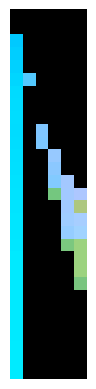

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


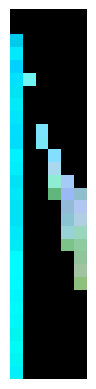

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


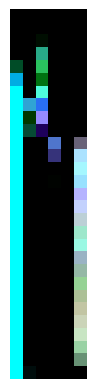

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


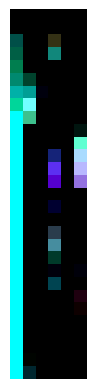

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


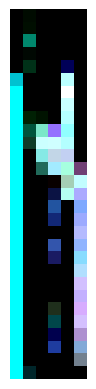

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


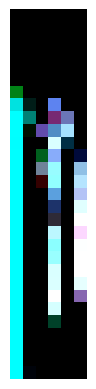

Epoch [43/300], Batch 0/64, Discriminator Loss: 0.6867, Generator Loss: 0.6711
tensor([[-0.0766],
        [-0.0830],
        [-0.2804]], requires_grad=True)
tensor([[-0.1655],
        [ 0.0176],
        [-0.2766]], requires_grad=True)
mean disc rating of real images: tensor(-0.0931)
mean disc rating of fake images: tensor(-0.1350)
Epoch: 45 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:34<00:00,  1.47s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


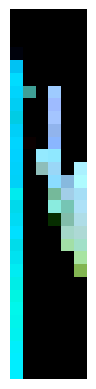

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


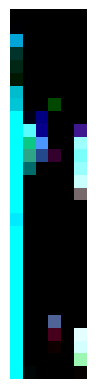

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


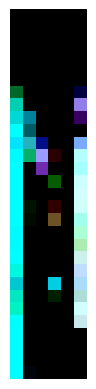

Epoch [44/300], Batch 0/64, Discriminator Loss: 0.6825, Generator Loss: 0.7185
tensor([[ 0.0606],
        [ 0.0550],
        [-0.1672]], requires_grad=True)
tensor([[ 0.0459],
        [-0.3639],
        [-0.1043]], requires_grad=True)
mean disc rating of real images: tensor(0.0313)
mean disc rating of fake images: tensor(-0.0304)
Epoch: 46 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:33<00:00,  1.46s/it]

real image:


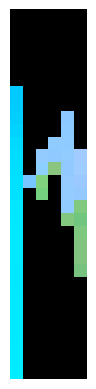

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


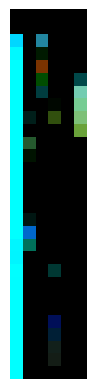

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


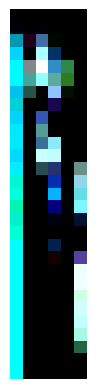

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


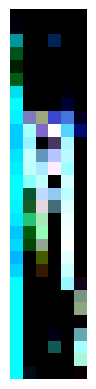

Epoch [45/300], Batch 0/64, Discriminator Loss: 0.6858, Generator Loss: 0.7122
tensor([[ 0.2001],
        [ 0.1442],
        [-0.2701]], requires_grad=True)
tensor([[-0.0304],
        [-0.3194],
        [-0.4673]], requires_grad=True)
mean disc rating of real images: tensor(-0.0743)
mean disc rating of fake images: tensor(-0.1426)
Epoch: 47 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:31<00:00,  1.43s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


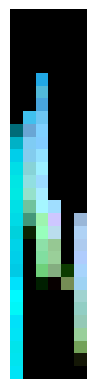

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


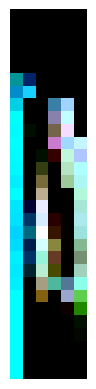

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [46/300], Batch 0/64, Discriminator Loss: 0.6907, Generator Loss: 0.7062
tensor([[ 0.0952],
        [-0.1172],
        [ 0.0931]], requires_grad=True)
tensor([[-0.0764],
        [-0.0990],
        [ 0.0921]], requires_grad=True)
mean disc rating of real images: tensor(0.0591)
mean disc rating of fake images: tensor(0.0375)
Epoch: 48 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:31<00:00,  1.42s/it]

real image:


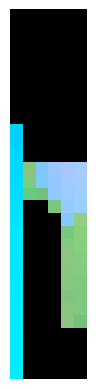

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


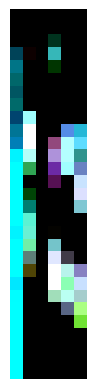

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


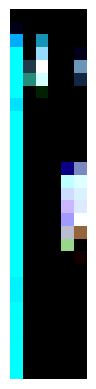

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


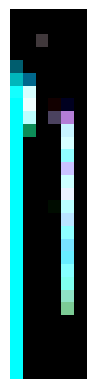

Epoch [47/300], Batch 0/64, Discriminator Loss: 0.6934, Generator Loss: 0.7441
tensor([[ 0.1957],
        [ 0.0585],
        [-0.0279]], requires_grad=True)
tensor([[-0.0633],
        [ 0.1257],
        [ 0.3483]], requires_grad=True)
mean disc rating of real images: tensor(0.0473)
mean disc rating of fake images: tensor(0.0347)
Epoch: 49 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:29<00:00,  1.41s/it]

real image:


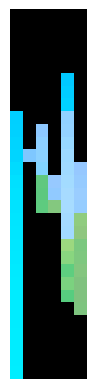

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


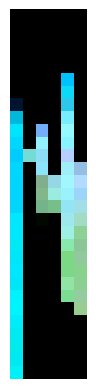

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


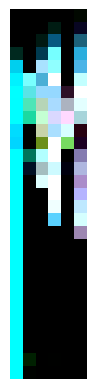

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


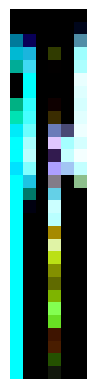

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


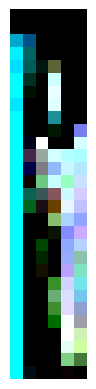

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


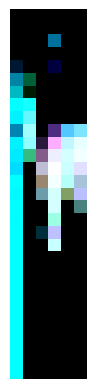

Epoch [48/300], Batch 0/64, Discriminator Loss: 0.6996, Generator Loss: 0.7746
tensor([[0.2356],
        [0.4866],
        [0.2149]], requires_grad=True)
tensor([[ 0.5084],
        [-0.0448],
        [ 0.0441]], requires_grad=True)
mean disc rating of real images: tensor(0.1348)
mean disc rating of fake images: tensor(0.1285)
Epoch: 50 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:30<00:00,  1.41s/it]

real image:


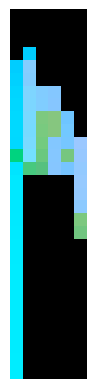

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


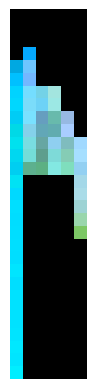

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


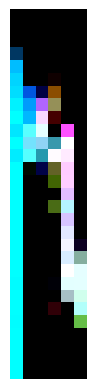

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


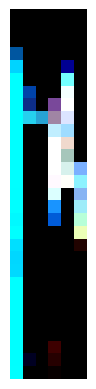

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


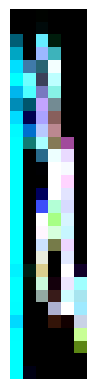

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


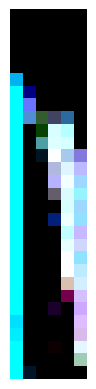

Epoch [49/300], Batch 0/64, Discriminator Loss: 0.6945, Generator Loss: 0.7147
tensor([[-0.0969],
        [ 0.4492],
        [-0.2957]], requires_grad=True)
tensor([[-0.1018],
        [ 0.0729],
        [-0.2865]], requires_grad=True)
mean disc rating of real images: tensor(0.0602)
mean disc rating of fake images: tensor(0.0442)
Epoch: 51 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:30<00:00,  1.41s/it]

real image:


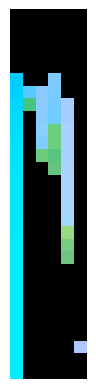

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


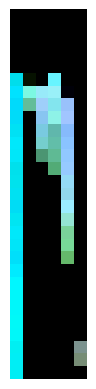

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


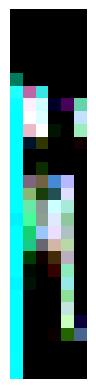

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


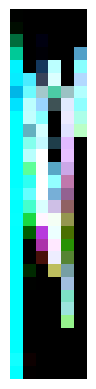

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


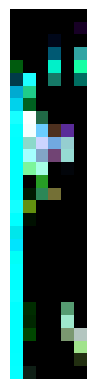

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


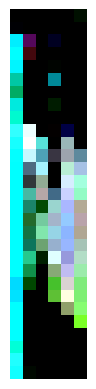

Epoch [50/300], Batch 0/64, Discriminator Loss: 0.7385, Generator Loss: 0.6886
tensor([[-0.2392],
        [-0.3774],
        [-0.2691]], requires_grad=True)
tensor([[-0.1430],
        [-0.5933],
        [-0.3095]], requires_grad=True)
mean disc rating of real images: tensor(-0.2258)
mean disc rating of fake images: tensor(-0.1089)
Epoch: 52 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:30<00:00,  1.42s/it]

real image:


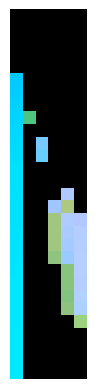

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


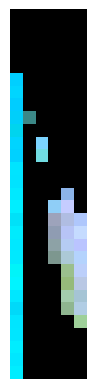

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


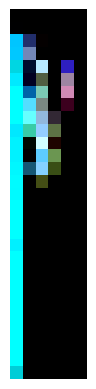

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [51/300], Batch 0/64, Discriminator Loss: 0.6944, Generator Loss: 0.6718
tensor([[ 0.1324],
        [-0.2317],
        [ 0.3596]], requires_grad=True)
tensor([[-0.2022],
        [-0.3418],
        [-0.1811]], requires_grad=True)
mean disc rating of real images: tensor(-0.0763)
mean disc rating of fake images: tensor(-0.1008)
Epoch: 53 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:30<00:00,  1.42s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


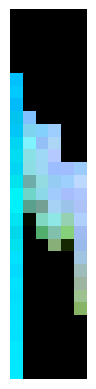

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


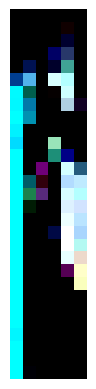

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


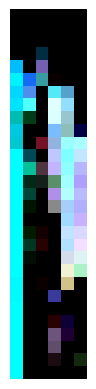

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


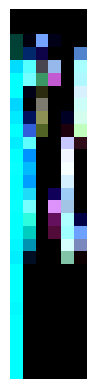

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


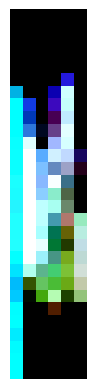

Epoch [52/300], Batch 0/64, Discriminator Loss: 0.6722, Generator Loss: 0.7427
tensor([[0.0607],
        [0.3497],
        [0.5079]], requires_grad=True)
tensor([[-0.1863],
        [-0.1693],
        [ 0.4561]], requires_grad=True)
mean disc rating of real images: tensor(0.0552)
mean disc rating of fake images: tensor(-0.0573)
Epoch: 54 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:28<00:00,  1.38s/it]

real image:


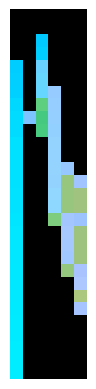

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


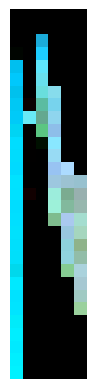

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


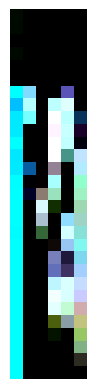

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


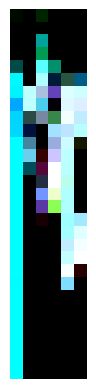

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


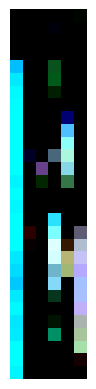

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


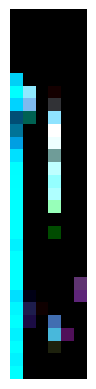

Epoch [53/300], Batch 0/64, Discriminator Loss: 0.6935, Generator Loss: 0.7287
tensor([[0.0816],
        [0.1892],
        [0.0269]], requires_grad=True)
tensor([[ 0.0775],
        [ 0.0334],
        [-0.0229]], requires_grad=True)
mean disc rating of real images: tensor(0.0407)
mean disc rating of fake images: tensor(0.0288)
Epoch: 55 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:28<00:00,  1.39s/it]

real image:


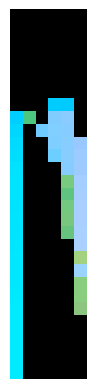

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


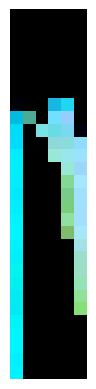

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


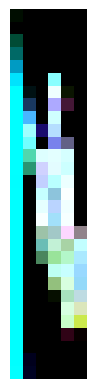

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


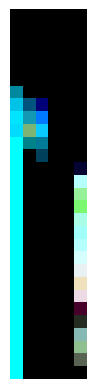

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


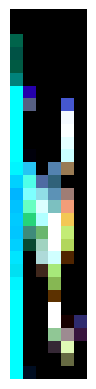

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


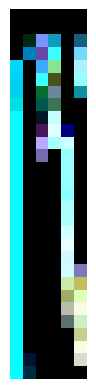

Epoch [54/300], Batch 0/64, Discriminator Loss: 0.6922, Generator Loss: 0.7516
tensor([[ 0.1504],
        [-0.2848],
        [-0.0049]], requires_grad=True)
tensor([[-0.0412],
        [ 0.1715],
        [ 0.3125]], requires_grad=True)
mean disc rating of real images: tensor(0.0398)
mean disc rating of fake images: tensor(0.0192)
Epoch: 56 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:36<00:00,  1.51s/it]

real image:


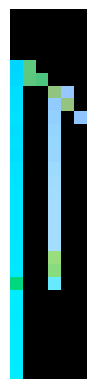

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


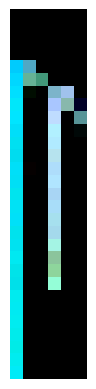

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


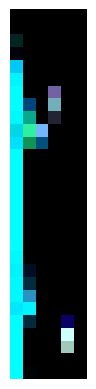

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


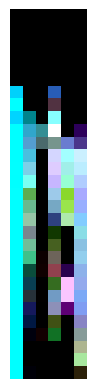

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


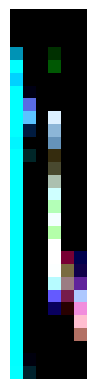

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


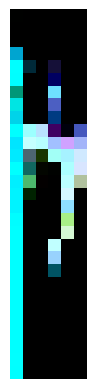

Epoch [55/300], Batch 0/64, Discriminator Loss: 0.6705, Generator Loss: 0.7001
tensor([[-0.1090],
        [ 0.1125],
        [ 0.2470]], requires_grad=True)
tensor([[0.2988],
        [0.1716],
        [0.0583]], requires_grad=True)
mean disc rating of real images: tensor(0.0238)
mean disc rating of fake images: tensor(-0.0852)
Epoch: 57 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:31<00:00,  1.43s/it]

real image:


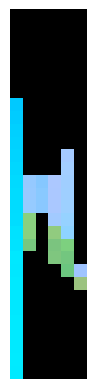

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


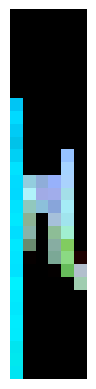

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


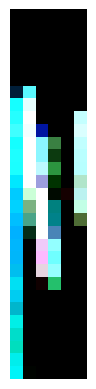

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


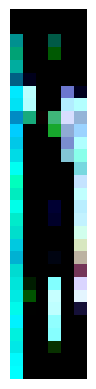

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


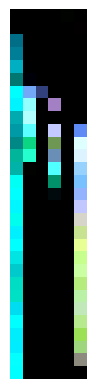

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


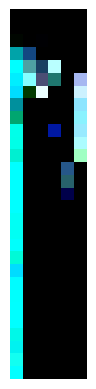

Epoch [56/300], Batch 0/64, Discriminator Loss: 0.6925, Generator Loss: 0.7106
tensor([[-0.0047],
        [-0.0385],
        [-0.0366]], requires_grad=True)
tensor([[-0.0128],
        [ 0.0485],
        [-0.1411]], requires_grad=True)
mean disc rating of real images: tensor(0.0008)
mean disc rating of fake images: tensor(-0.0118)
Epoch: 58 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:32<00:00,  1.45s/it]

real image:


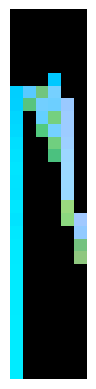

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


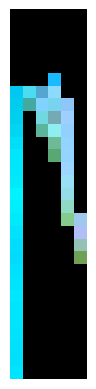

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


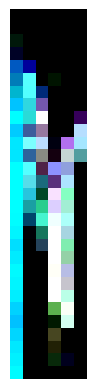

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


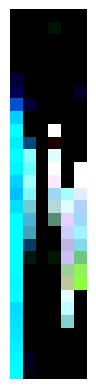

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


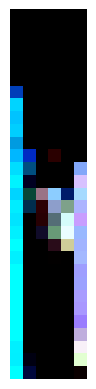

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


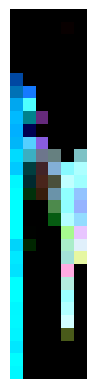

Epoch [57/300], Batch 0/64, Discriminator Loss: 0.6889, Generator Loss: 0.6749
tensor([[-0.0054],
        [ 0.0126],
        [ 0.0524]], requires_grad=True)
tensor([[-0.1661],
        [-0.2164],
        [-0.2162]], requires_grad=True)
mean disc rating of real images: tensor(-0.0242)
mean disc rating of fake images: tensor(-0.0588)
Epoch: 59 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:36<00:00,  1.51s/it]

real image:


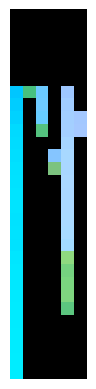

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


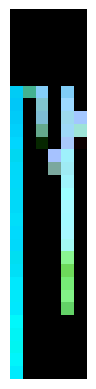

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


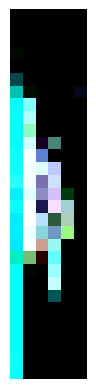

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


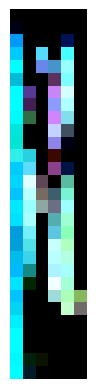

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


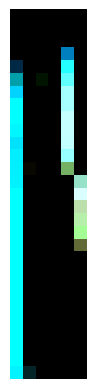

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


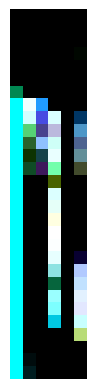

Epoch [58/300], Batch 0/64, Discriminator Loss: 0.7041, Generator Loss: 0.6852
tensor([[-0.0223],
        [-0.1492],
        [ 0.2789]], requires_grad=True)
tensor([[ 0.0739],
        [-0.1277],
        [-0.0240]], requires_grad=True)
mean disc rating of real images: tensor(-0.0701)
mean disc rating of fake images: tensor(-0.0404)
Epoch: 60 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.50s/it]

real image:


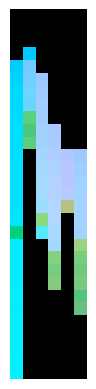

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


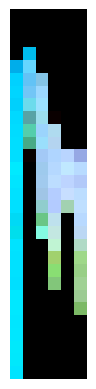

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


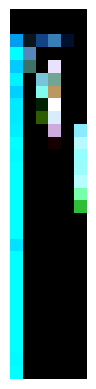

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


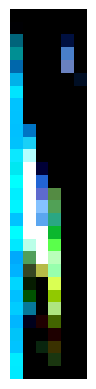

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


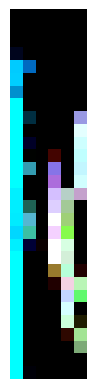

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


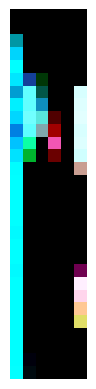

Epoch [59/300], Batch 0/64, Discriminator Loss: 0.6871, Generator Loss: 0.6947
tensor([[ 0.2532],
        [-0.0184],
        [ 0.0598]], requires_grad=True)
tensor([[ 0.1039],
        [ 0.2097],
        [-0.1210]], requires_grad=True)
mean disc rating of real images: tensor(0.0063)
mean disc rating of fake images: tensor(-0.0291)
Epoch: 61 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.49s/it]

real image:


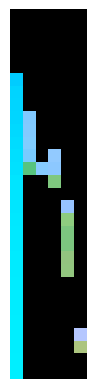

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


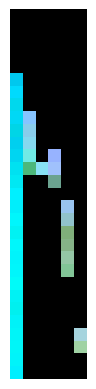

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


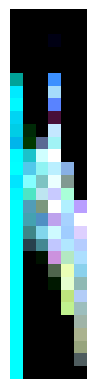

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


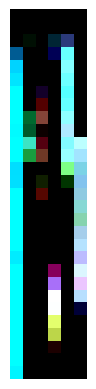

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


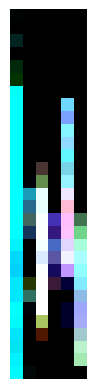

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


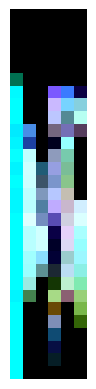

Epoch [60/300], Batch 0/64, Discriminator Loss: 0.6883, Generator Loss: 0.7218
tensor([[0.2068],
        [0.0875],
        [0.3951]], requires_grad=True)
tensor([[ 0.0845],
        [-0.1178],
        [ 0.0112]], requires_grad=True)
mean disc rating of real images: tensor(0.0604)
mean disc rating of fake images: tensor(0.0345)
Epoch: 62 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.48s/it]

real image:


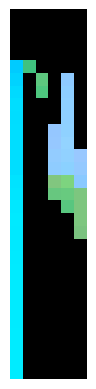

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


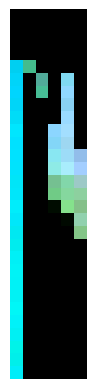

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


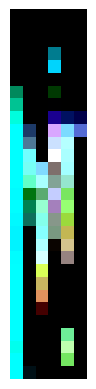

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


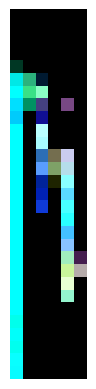

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


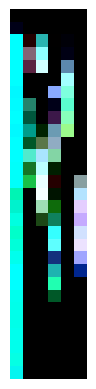

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


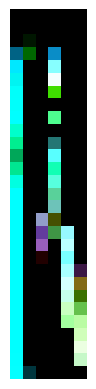

Epoch [61/300], Batch 0/64, Discriminator Loss: 0.6979, Generator Loss: 0.7072
tensor([[-0.0163],
        [ 0.0080],
        [ 0.1376]], requires_grad=True)
tensor([[0.0855],
        [0.0808],
        [0.1378]], requires_grad=True)
mean disc rating of real images: tensor(0.0314)
mean disc rating of fake images: tensor(0.0393)
Epoch: 63 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:34<00:00,  1.48s/it]

real image:


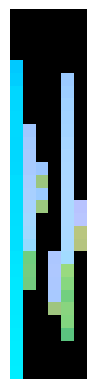

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


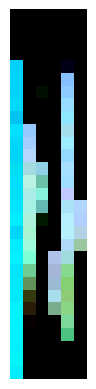

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


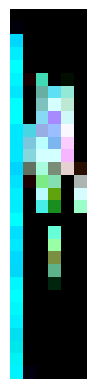

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


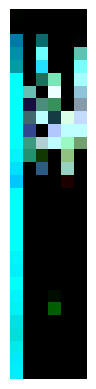

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


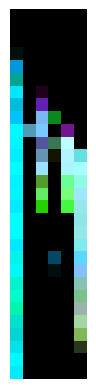

Epoch [62/300], Batch 0/64, Discriminator Loss: 0.7043, Generator Loss: 0.5652
tensor([[ 0.0314],
        [-0.3551],
        [-0.1781]], requires_grad=True)
tensor([[-0.3072],
        [-0.6259],
        [-0.4143]], requires_grad=True)
mean disc rating of real images: tensor(-0.3005)
mean disc rating of fake images: tensor(-0.3162)
Epoch: 64 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.50s/it]

real image:


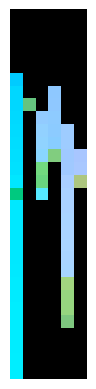

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


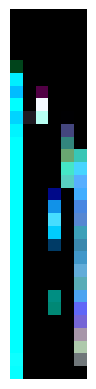

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


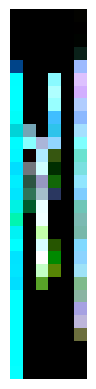

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


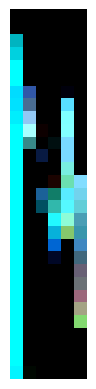

Epoch [63/300], Batch 0/64, Discriminator Loss: 0.6940, Generator Loss: 0.6890
tensor([[-0.2827],
        [-0.0186],
        [ 0.0857]], requires_grad=True)
tensor([[-0.0843],
        [-0.0742],
        [-0.0343]], requires_grad=True)
mean disc rating of real images: tensor(-0.0580)
mean disc rating of fake images: tensor(-0.0622)
Epoch: 65 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:38<00:00,  1.53s/it]

real image:


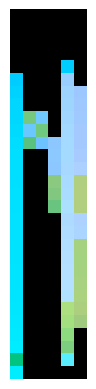

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


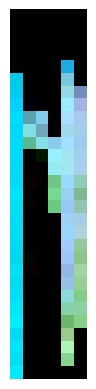

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


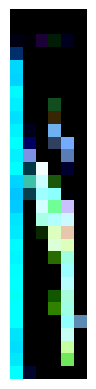

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [64/300], Batch 0/64, Discriminator Loss: 0.6950, Generator Loss: 0.6760
tensor([[-0.5491],
        [ 0.0798],
        [-0.2010]], requires_grad=True)
tensor([[ 0.2458],
        [-0.1673],
        [-0.2168]], requires_grad=True)
mean disc rating of real images: tensor(-0.0605)
mean disc rating of fake images: tensor(-0.0719)
Epoch: 66 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:41<00:00,  1.59s/it]

real image:


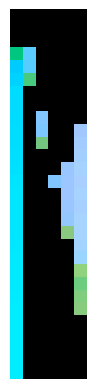

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


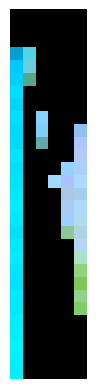

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


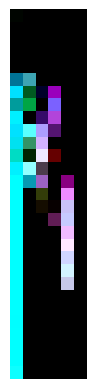

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


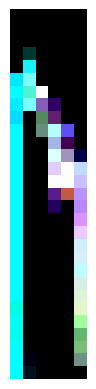

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


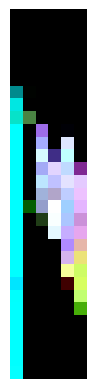

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [65/300], Batch 0/64, Discriminator Loss: 0.6984, Generator Loss: 0.7618
tensor([[ 0.0411],
        [ 0.0432],
        [-0.0103]], requires_grad=True)
tensor([[0.1395],
        [0.0465],
        [0.3021]], requires_grad=True)
mean disc rating of real images: tensor(0.0513)
mean disc rating of fake images: tensor(0.0647)
Epoch: 67 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:39<00:00,  1.55s/it]

real image:


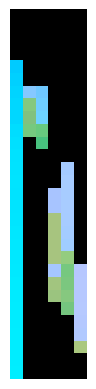

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


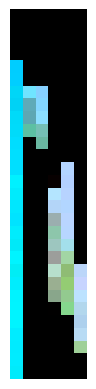

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


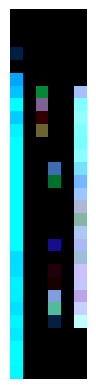

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


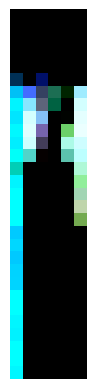

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [66/300], Batch 0/64, Discriminator Loss: 0.6859, Generator Loss: 0.6781
tensor([[ 0.2728],
        [ 0.1675],
        [-0.1926]], requires_grad=True)
tensor([[0.2670],
        [0.1901],
        [0.0046]], requires_grad=True)
mean disc rating of real images: tensor(-0.0019)
mean disc rating of fake images: tensor(-0.0471)
Epoch: 68 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:37<00:00,  1.52s/it]

real image:


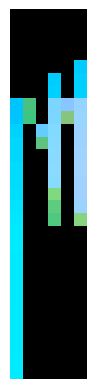

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


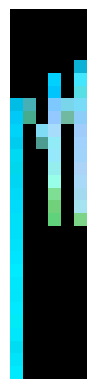

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


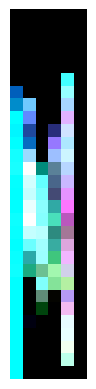

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


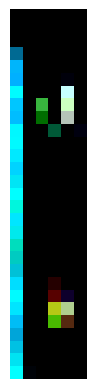

Epoch [67/300], Batch 0/64, Discriminator Loss: 0.6939, Generator Loss: 0.7213
tensor([[-0.1607],
        [-0.0862],
        [-0.0676]], requires_grad=True)
tensor([[ 0.0774],
        [ 0.0629],
        [-0.0992]], requires_grad=True)
mean disc rating of real images: tensor(-0.0206)
mean disc rating of fake images: tensor(-0.0286)
Epoch: 69 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:37<00:00,  1.53s/it]

real image:


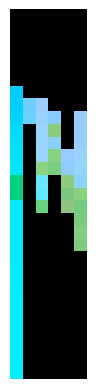

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


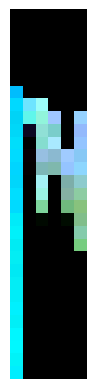

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


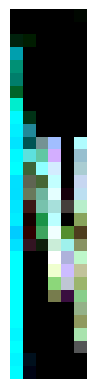

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


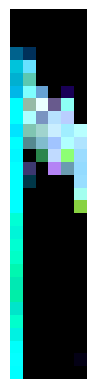

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


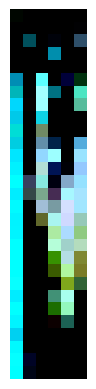

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


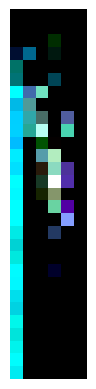

Epoch [68/300], Batch 0/64, Discriminator Loss: 0.6833, Generator Loss: 0.7474
tensor([[-0.2018],
        [-0.1206],
        [ 0.0043]], requires_grad=True)
tensor([[-0.1117],
        [-0.3112],
        [-0.2241]], requires_grad=True)
mean disc rating of real images: tensor(0.0792)
mean disc rating of fake images: tensor(0.0083)
Epoch: 70 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:38<00:00,  1.54s/it]


real image:


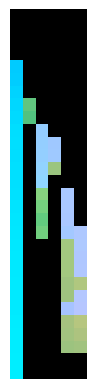

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


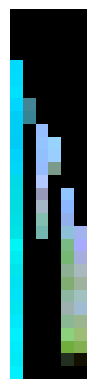

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


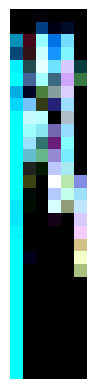

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


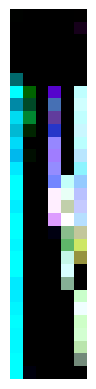

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


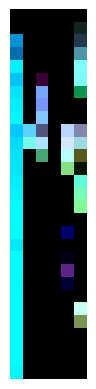

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


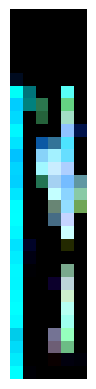

Epoch [69/300], Batch 0/64, Discriminator Loss: 0.6897, Generator Loss: 0.7882
tensor([[-0.1294],
        [-0.2797],
        [ 0.5430]], requires_grad=True)
tensor([[0.2499],
        [0.1250],
        [0.0874]], requires_grad=True)
mean disc rating of real images: tensor(0.0949)
mean disc rating of fake images: tensor(0.0420)
Epoch: 71 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:41<00:00,  1.59s/it]

real image:


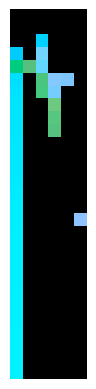

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


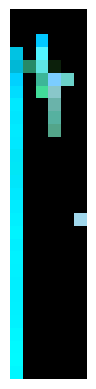

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random created images:


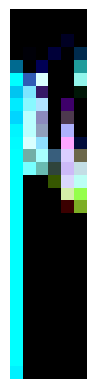

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


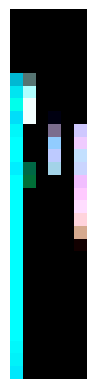

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


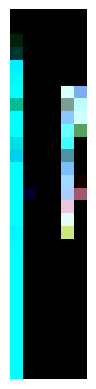

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


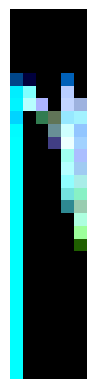

Epoch [70/300], Batch 0/64, Discriminator Loss: 0.6930, Generator Loss: 0.7288
tensor([[-0.0051],
        [ 0.1343],
        [ 0.1442]], requires_grad=True)
tensor([[-0.2879],
        [-0.0044],
        [ 0.4625]], requires_grad=True)
mean disc rating of real images: tensor(-0.0477)
mean disc rating of fake images: tensor(-0.0665)
Epoch: 72 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:46<00:00,  1.66s/it]

real image:


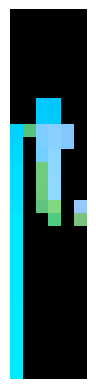

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


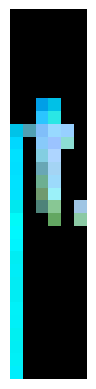

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


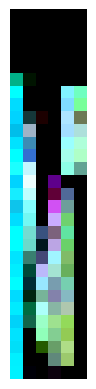

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


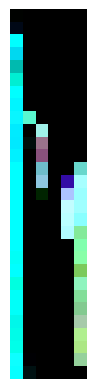

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


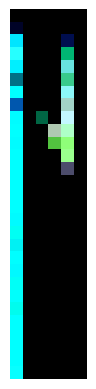

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


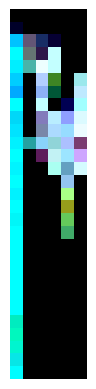

Epoch [71/300], Batch 0/64, Discriminator Loss: 0.6811, Generator Loss: 0.7360
tensor([[0.1627],
        [0.3475],
        [0.1695]], requires_grad=True)
tensor([[0.0615],
        [0.1210],
        [0.0648]], requires_grad=True)
mean disc rating of real images: tensor(0.0819)
mean disc rating of fake images: tensor(0.0133)
Epoch: 73 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:50<00:00,  1.72s/it]

real image:


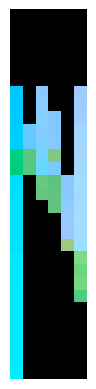

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


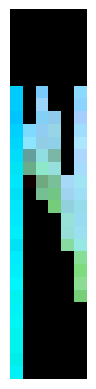

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


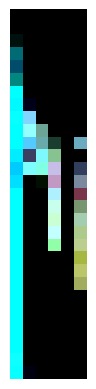

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


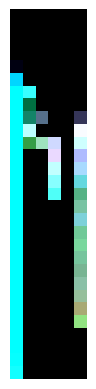

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


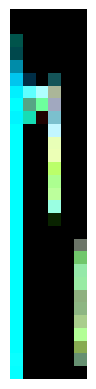

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


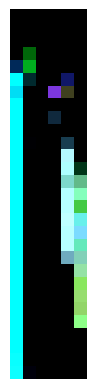

Epoch [72/300], Batch 0/64, Discriminator Loss: 0.6885, Generator Loss: 0.7624
tensor([[0.2236],
        [0.2268],
        [0.4433]], requires_grad=True)
tensor([[0.2537],
        [0.0249],
        [0.1273]], requires_grad=True)
mean disc rating of real images: tensor(0.1381)
mean disc rating of fake images: tensor(0.0981)
Epoch: 74 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:47<00:00,  1.67s/it]

real image:


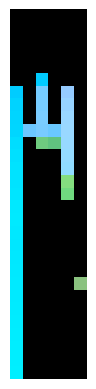

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


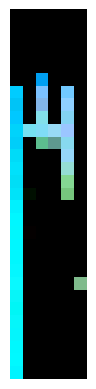

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


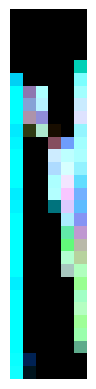

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


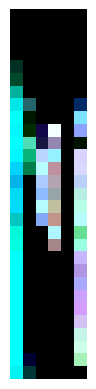

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


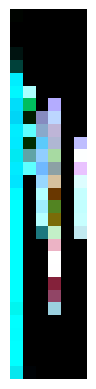

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


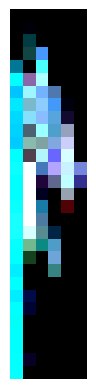

Epoch [73/300], Batch 0/64, Discriminator Loss: 0.6824, Generator Loss: 0.7105
tensor([[ 0.0066],
        [-0.1235],
        [ 0.1047]], requires_grad=True)
tensor([[ 0.0082],
        [ 0.2156],
        [-0.1086]], requires_grad=True)
mean disc rating of real images: tensor(0.0527)
mean disc rating of fake images: tensor(-0.0041)
Epoch: 75 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:41<00:00,  1.59s/it]

real image:


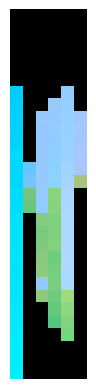

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


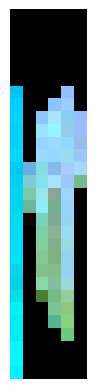

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


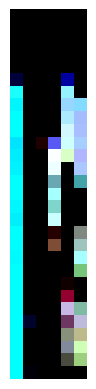

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


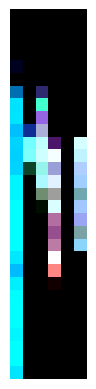

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


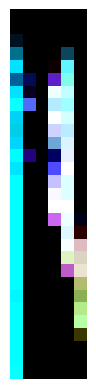

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


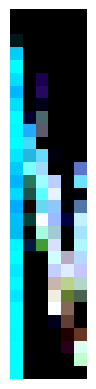

Epoch [74/300], Batch 0/64, Discriminator Loss: 0.6891, Generator Loss: 0.7268
tensor([[ 0.1733],
        [-0.0511],
        [-0.1386]], requires_grad=True)
tensor([[ 0.0228],
        [ 0.1946],
        [-0.3416]], requires_grad=True)
mean disc rating of real images: tensor(0.0227)
mean disc rating of fake images: tensor(-0.0035)
Epoch: 76 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:36<00:00,  1.50s/it]

real image:


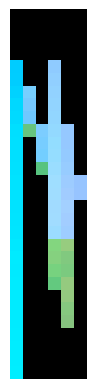

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


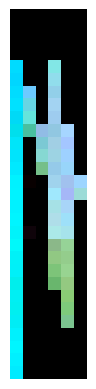

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


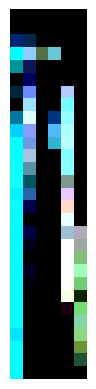

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


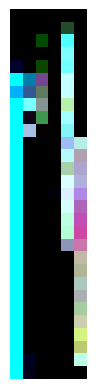

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


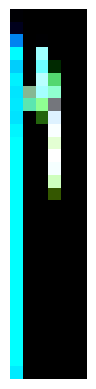

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


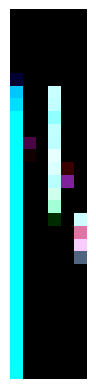

Epoch [75/300], Batch 0/64, Discriminator Loss: 0.6958, Generator Loss: 0.7459
tensor([[0.0769],
        [0.0289],
        [0.0187]], requires_grad=True)
tensor([[-0.2403],
        [ 0.0332],
        [-0.0941]], requires_grad=True)
mean disc rating of real images: tensor(-0.0765)
mean disc rating of fake images: tensor(-0.0785)
Epoch: 77 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:30<00:00,  1.41s/it]

real image:


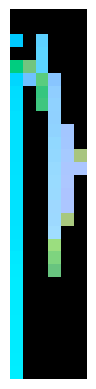

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


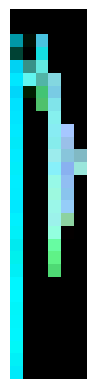

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


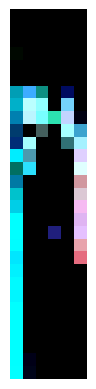

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


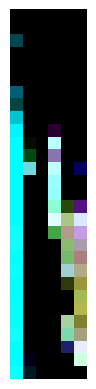

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


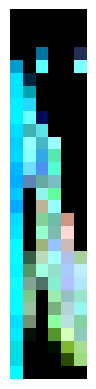

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


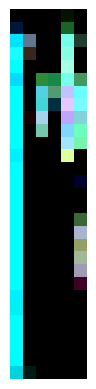

Epoch [76/300], Batch 0/64, Discriminator Loss: 0.6819, Generator Loss: 0.7756
tensor([[-0.0968],
        [-0.0322],
        [-0.0553]], requires_grad=True)
tensor([[ 0.2366],
        [-0.4273],
        [ 0.0066]], requires_grad=True)
mean disc rating of real images: tensor(0.0755)
mean disc rating of fake images: tensor(0.0167)
Epoch: 78 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:29<00:00,  1.40s/it]

real image:


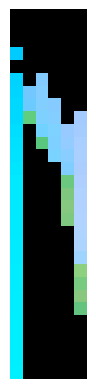

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


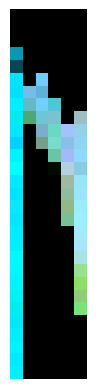

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


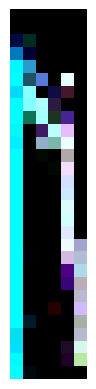

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


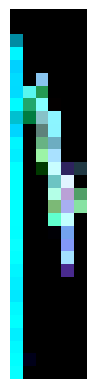

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


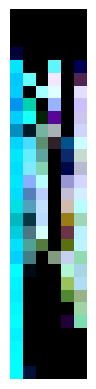

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


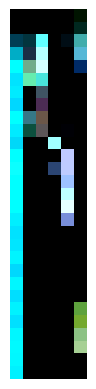

Epoch [77/300], Batch 0/64, Discriminator Loss: 0.6804, Generator Loss: 0.6955
tensor([[ 0.2731],
        [-0.3054],
        [ 0.1311]], requires_grad=True)
tensor([[ 0.3161],
        [-0.3061],
        [ 0.1843]], requires_grad=True)
mean disc rating of real images: tensor(-0.0195)
mean disc rating of fake images: tensor(-0.0875)
Epoch: 79 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:33<00:00,  1.46s/it]

real image:


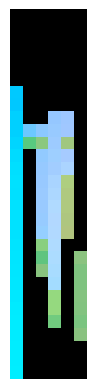

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


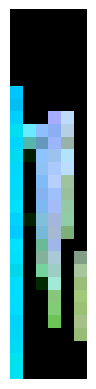

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


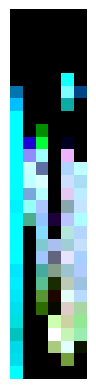

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


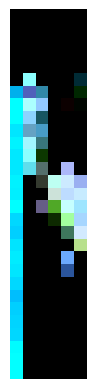

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


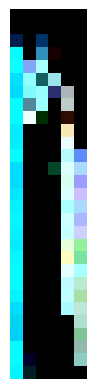

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


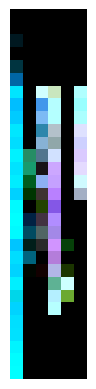

Epoch [78/300], Batch 0/64, Discriminator Loss: 0.6906, Generator Loss: 0.7281
tensor([[0.0301],
        [0.2602],
        [0.2126]], requires_grad=True)
tensor([[ 0.0271],
        [ 0.1836],
        [-0.0455]], requires_grad=True)
mean disc rating of real images: tensor(0.0319)
mean disc rating of fake images: tensor(0.0062)
Epoch: 80 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:33<00:00,  1.46s/it]

real image:


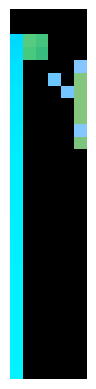

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


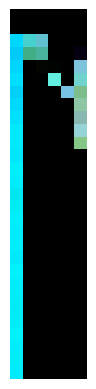

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


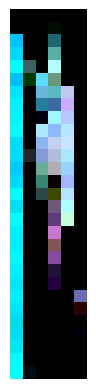

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


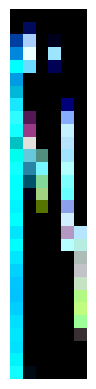

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


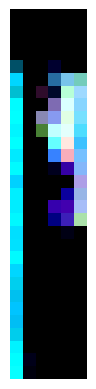

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


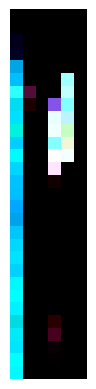

Epoch [79/300], Batch 0/64, Discriminator Loss: 0.6813, Generator Loss: 0.7084
tensor([[ 0.4389],
        [-0.2667],
        [-0.5047]], requires_grad=True)
tensor([[ 0.0598],
        [ 0.0058],
        [-0.2571]], requires_grad=True)
mean disc rating of real images: tensor(-0.0601)
mean disc rating of fake images: tensor(-0.1313)
Epoch: 81 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.49s/it]

real image:


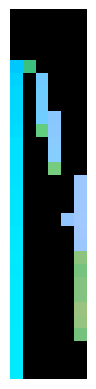

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


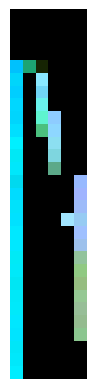

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


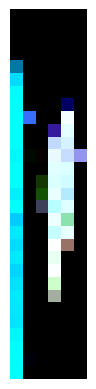

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


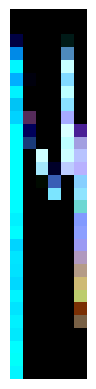

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


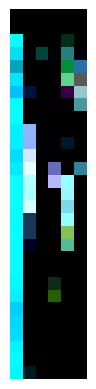

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


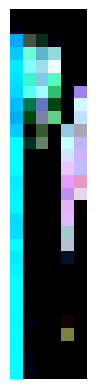

Epoch [80/300], Batch 0/64, Discriminator Loss: 0.6903, Generator Loss: 0.7371
tensor([[-0.1098],
        [-0.0633],
        [ 0.5114]], requires_grad=True)
tensor([[-0.4188],
        [-0.0052],
        [-0.1381]], requires_grad=True)
mean disc rating of real images: tensor(-0.0306)
mean disc rating of fake images: tensor(-0.0751)
Epoch: 82 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:38<00:00,  1.53s/it]

real image:


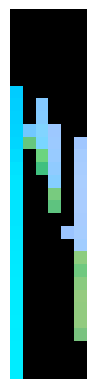

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


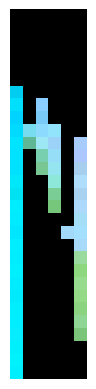

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


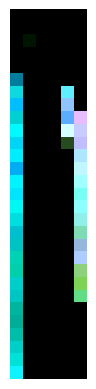

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


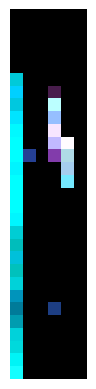

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


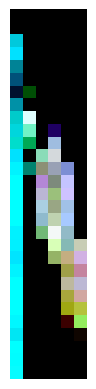

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


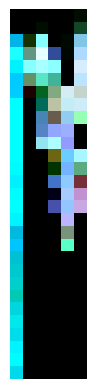

Epoch [81/300], Batch 0/64, Discriminator Loss: 0.6835, Generator Loss: 0.7240
tensor([[0.0518],
        [0.1184],
        [0.2802]], requires_grad=True)
tensor([[ 0.2016],
        [-0.0198],
        [ 0.4775]], requires_grad=True)
mean disc rating of real images: tensor(0.1563)
mean disc rating of fake images: tensor(0.0907)
Epoch: 83 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:34<00:00,  1.47s/it]

real image:


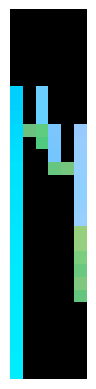

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


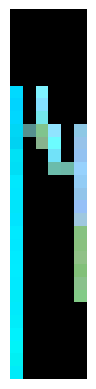

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


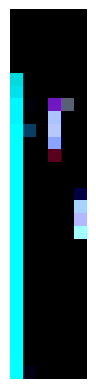

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


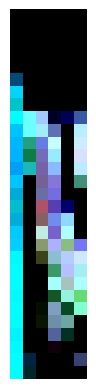

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


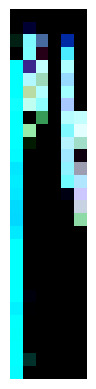

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [82/300], Batch 0/64, Discriminator Loss: 0.6928, Generator Loss: 0.6004
tensor([[-0.2810],
        [-0.2947],
        [-0.5793]], requires_grad=True)
tensor([[-0.4235],
        [-0.1645],
        [-0.5210]], requires_grad=True)
mean disc rating of real images: tensor(-0.2517)
mean disc rating of fake images: tensor(-0.3147)
Epoch: 84 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:32<00:00,  1.45s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


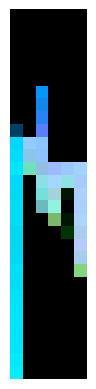

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


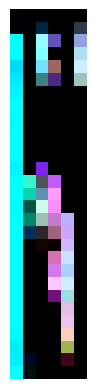

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


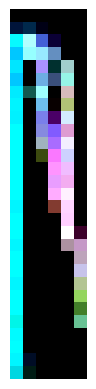

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


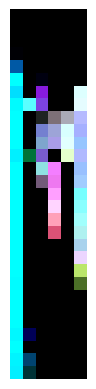

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [83/300], Batch 0/64, Discriminator Loss: 0.7102, Generator Loss: 0.6998
tensor([[-0.0651],
        [-0.3267],
        [-0.1167]], requires_grad=True)
tensor([[-0.1418],
        [-0.1440],
        [-0.2397]], requires_grad=True)
mean disc rating of real images: tensor(-0.0874)
mean disc rating of fake images: tensor(-0.0354)
Epoch: 85 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:34<00:00,  1.48s/it]

real image:


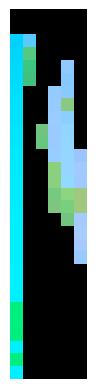

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


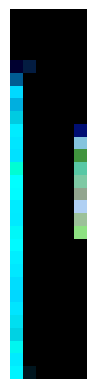

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


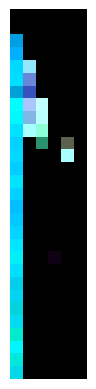

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


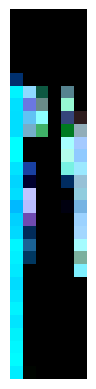

Epoch [84/300], Batch 0/64, Discriminator Loss: 0.6933, Generator Loss: 0.6141
tensor([[-0.6542],
        [ 0.0796],
        [-0.2995]], requires_grad=True)
tensor([[ 0.0812],
        [-0.1327],
        [ 0.3293]], requires_grad=True)
mean disc rating of real images: tensor(-0.1722)
mean disc rating of fake images: tensor(-0.2270)
Epoch: 86 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:37<00:00,  1.52s/it]

real image:


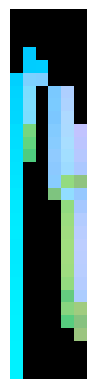

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


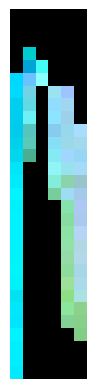

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


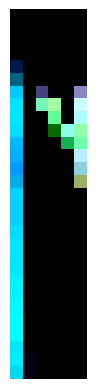

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


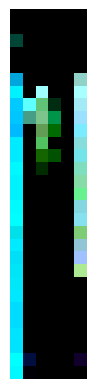

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


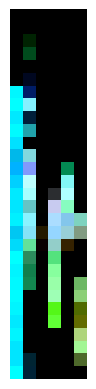

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


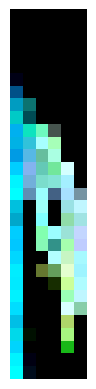

Epoch [85/300], Batch 0/64, Discriminator Loss: 0.6928, Generator Loss: 0.7033
tensor([[-0.0366],
        [-0.3361],
        [-0.0163]], requires_grad=True)
tensor([[-0.1032],
        [-0.2672],
        [-0.3968]], requires_grad=True)
mean disc rating of real images: tensor(-0.0582)
mean disc rating of fake images: tensor(-0.0775)
Epoch: 87 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:40<00:00,  1.57s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


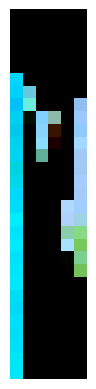

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


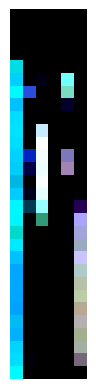

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


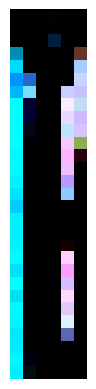

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


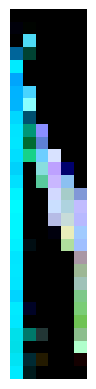

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


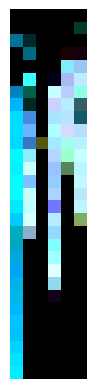

Epoch [86/300], Batch 0/64, Discriminator Loss: 0.6987, Generator Loss: 0.7748
tensor([[-0.0186],
        [ 0.1162],
        [ 0.0366]], requires_grad=True)
tensor([[-0.2525],
        [ 0.0023],
        [ 0.0010]], requires_grad=True)
mean disc rating of real images: tensor(0.0515)
mean disc rating of fake images: tensor(0.0507)
Epoch: 88 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:36<00:00,  1.51s/it]

real image:


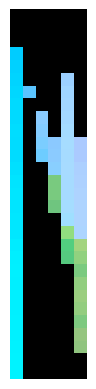

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


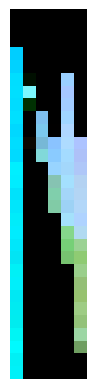

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


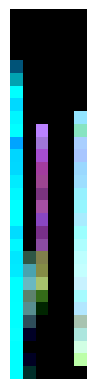

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


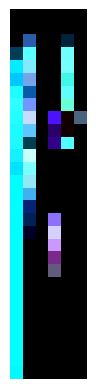

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


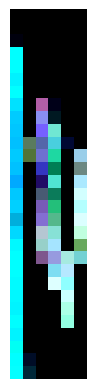

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [87/300], Batch 0/64, Discriminator Loss: 0.6828, Generator Loss: 0.7207
tensor([[-0.0695],
        [-0.1222],
        [-0.3775]], requires_grad=True)
tensor([[-0.0192],
        [-0.4850],
        [-0.0051]], requires_grad=True)
mean disc rating of real images: tensor(-0.1412)
mean disc rating of fake images: tensor(-0.2178)
Epoch: 89 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.49s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


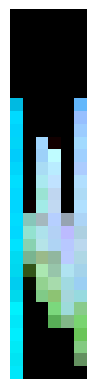

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


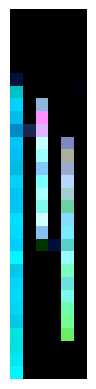

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [88/300], Batch 0/64, Discriminator Loss: 0.7008, Generator Loss: 0.4677
tensor([[-0.0996],
        [-0.1007],
        [-0.5502]], requires_grad=True)
tensor([[-0.6035],
        [-0.6248],
        [-0.4759]], requires_grad=True)
mean disc rating of real images: tensor(-0.3824)
mean disc rating of fake images: tensor(-0.4649)
Epoch: 90 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:36<00:00,  1.51s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


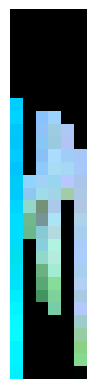

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


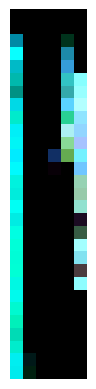

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


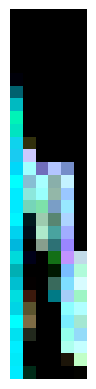

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


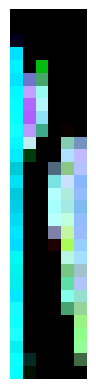

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


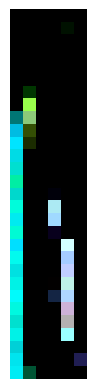

Epoch [89/300], Batch 0/64, Discriminator Loss: 0.6818, Generator Loss: 0.7568
tensor([[ 0.1350],
        [ 0.0941],
        [-0.0203]], requires_grad=True)
tensor([[-0.2516],
        [ 0.0197],
        [-0.1339]], requires_grad=True)
mean disc rating of real images: tensor(0.1003)
mean disc rating of fake images: tensor(0.0417)
Epoch: 91 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.50s/it]

real image:


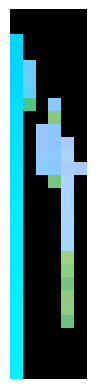

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


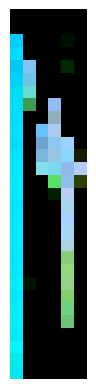

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


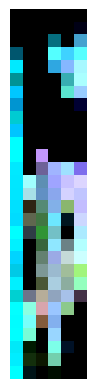

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


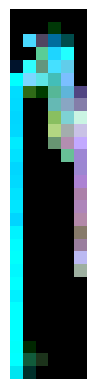

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


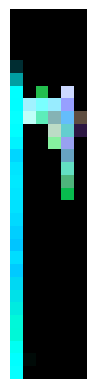

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


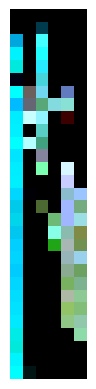

Epoch [90/300], Batch 0/64, Discriminator Loss: 0.6849, Generator Loss: 0.7683
tensor([[-0.0899],
        [ 0.2801],
        [ 0.0008]], requires_grad=True)
tensor([[-0.1687],
        [ 0.1063],
        [-0.0483]], requires_grad=True)
mean disc rating of real images: tensor(0.1280)
mean disc rating of fake images: tensor(0.0729)
Epoch: 92 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.50s/it]

real image:


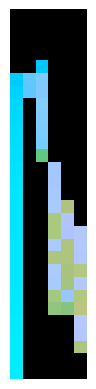

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


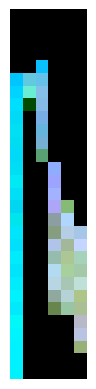

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


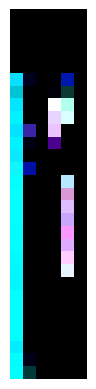

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


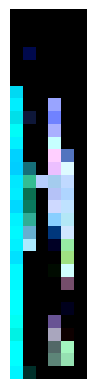

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


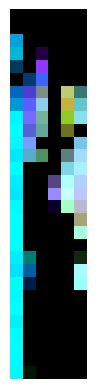

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


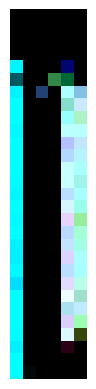

Epoch [91/300], Batch 0/64, Discriminator Loss: 0.6876, Generator Loss: 0.7182
tensor([[-0.0736],
        [-0.0642],
        [-0.0890]], requires_grad=True)
tensor([[ 0.0321],
        [-0.1770],
        [-0.0868]], requires_grad=True)
mean disc rating of real images: tensor(-0.0781)
mean disc rating of fake images: tensor(-0.1211)
Epoch: 93 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.49s/it]

real image:


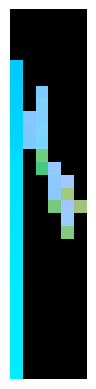

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


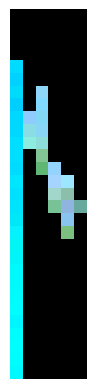

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


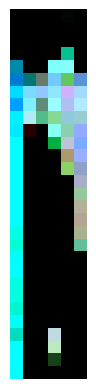

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


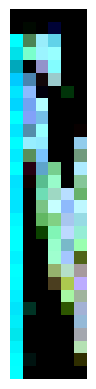

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


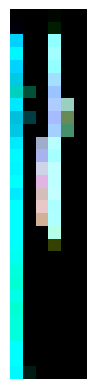

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


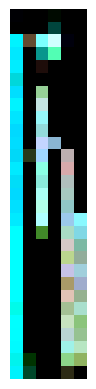

Epoch [92/300], Batch 0/64, Discriminator Loss: 0.6904, Generator Loss: 0.7201
tensor([[ 0.2102],
        [-0.4553],
        [-0.1659]], requires_grad=True)
tensor([[-0.4341],
        [-0.2269],
        [-0.5204]], requires_grad=True)
mean disc rating of real images: tensor(-0.1356)
mean disc rating of fake images: tensor(-0.1992)
Epoch: 94 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:33<00:00,  1.45s/it]

real image:


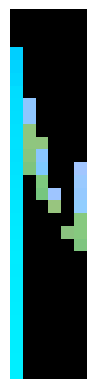

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


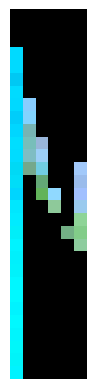

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


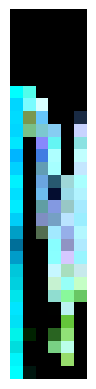

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


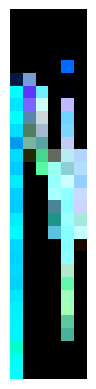

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


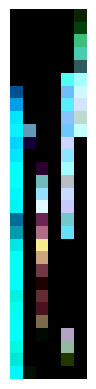

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


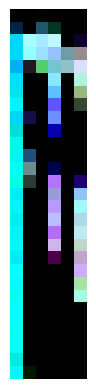

Epoch [93/300], Batch 0/64, Discriminator Loss: 0.6757, Generator Loss: 0.7364
tensor([[-0.0118],
        [-0.1501],
        [-0.0960]], requires_grad=True)
tensor([[ 0.0136],
        [-0.2164],
        [-0.0123]], requires_grad=True)
mean disc rating of real images: tensor(-0.0112)
mean disc rating of fake images: tensor(-0.1033)
Epoch: 95 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:34<00:00,  1.48s/it]

real image:


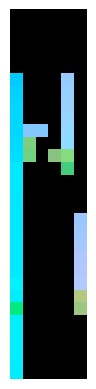

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


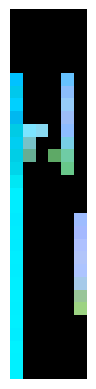

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


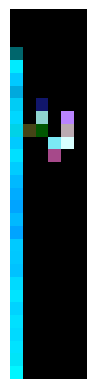

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


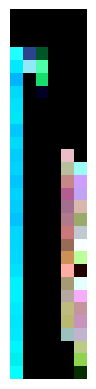

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


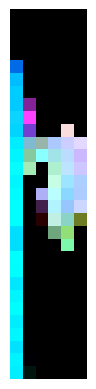

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


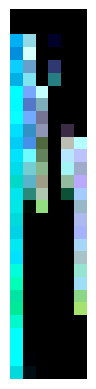

Epoch [94/300], Batch 0/64, Discriminator Loss: 0.7065, Generator Loss: 0.9813
tensor([[0.1573],
        [0.1193],
        [0.5461]], requires_grad=True)
tensor([[0.6188],
        [0.3909],
        [0.0676]], requires_grad=True)
mean disc rating of real images: tensor(0.3645)
mean disc rating of fake images: tensor(0.3357)
Epoch: 96 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:32<00:00,  1.44s/it]

real image:


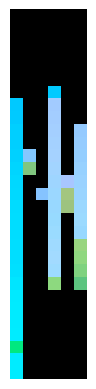

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


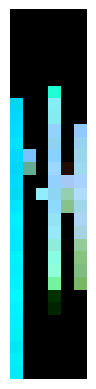

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


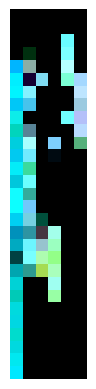

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


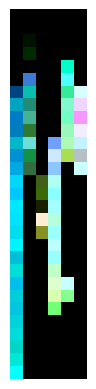

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


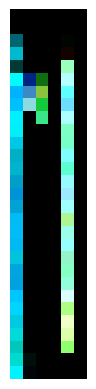

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


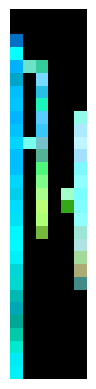

Epoch [95/300], Batch 0/64, Discriminator Loss: 0.6898, Generator Loss: 0.6245
tensor([[-0.3108],
        [-0.0099],
        [-0.0929]], requires_grad=True)
tensor([[-0.3617],
        [ 0.1749],
        [ 0.0395]], requires_grad=True)
mean disc rating of real images: tensor(-0.1019)
mean disc rating of fake images: tensor(-0.1383)
Epoch: 97 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.49s/it]

real image:


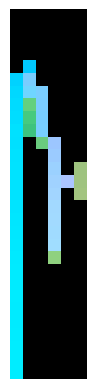

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


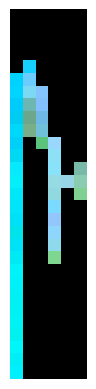

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


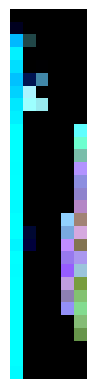

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


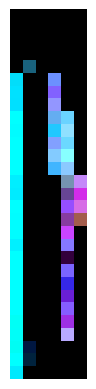

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


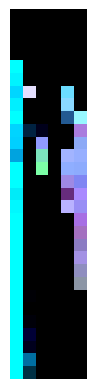

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


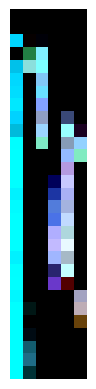

Epoch [96/300], Batch 0/64, Discriminator Loss: 0.6911, Generator Loss: 0.7936
tensor([[ 0.6013],
        [ 0.5826],
        [-0.1539]], requires_grad=True)
tensor([[ 0.0119],
        [-0.0304],
        [-0.1788]], requires_grad=True)
mean disc rating of real images: tensor(0.0687)
mean disc rating of fake images: tensor(0.0224)
Epoch: 98 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:34<00:00,  1.48s/it]

real image:


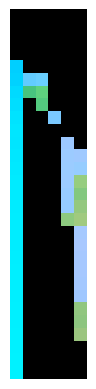

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


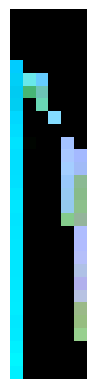

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


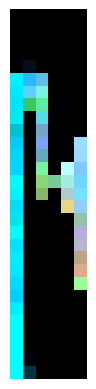

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


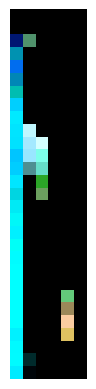

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


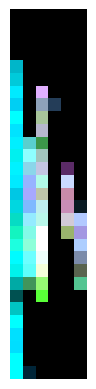

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


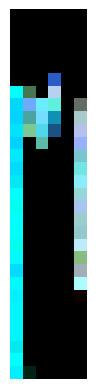

Epoch [97/300], Batch 0/64, Discriminator Loss: 0.6708, Generator Loss: 0.7560
tensor([[ 0.2270],
        [ 0.4892],
        [-0.1412]], requires_grad=True)
tensor([[ 0.1972],
        [ 0.0107],
        [-0.1710]], requires_grad=True)
mean disc rating of real images: tensor(0.1273)
mean disc rating of fake images: tensor(0.0167)
Epoch: 99 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:40<00:00,  1.57s/it]

real image:


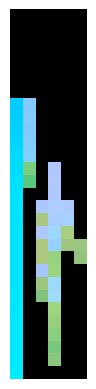

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


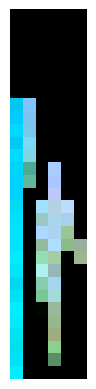

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random created images:


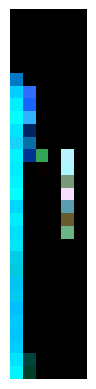

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


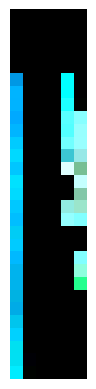

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


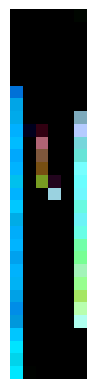

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


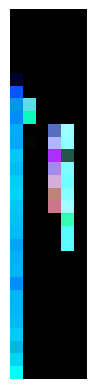

Epoch [98/300], Batch 0/64, Discriminator Loss: 0.6823, Generator Loss: 0.7768
tensor([[-0.1628],
        [ 0.3311],
        [ 0.2120]], requires_grad=True)
tensor([[0.5510],
        [0.3426],
        [0.2223]], requires_grad=True)
mean disc rating of real images: tensor(0.0974)
mean disc rating of fake images: tensor(0.0277)
Epoch: 100 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:40<00:00,  1.58s/it]

real image:


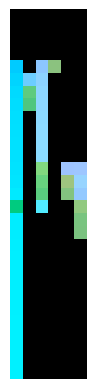

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


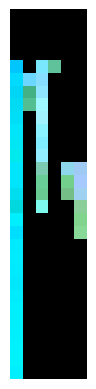

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random created images:


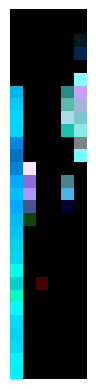

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


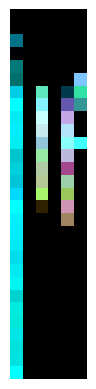

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


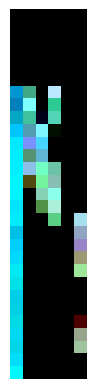

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


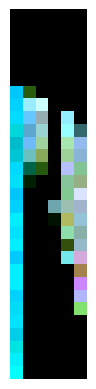

Epoch [99/300], Batch 0/64, Discriminator Loss: 0.6846, Generator Loss: 0.7855
tensor([[0.0991],
        [0.3472],
        [0.4563]], requires_grad=True)
tensor([[0.4034],
        [0.2432],
        [0.0933]], requires_grad=True)
mean disc rating of real images: tensor(0.1814)
mean disc rating of fake images: tensor(0.1047)
Epoch: 101 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:38<00:00,  1.55s/it]

real image:


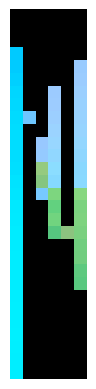

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


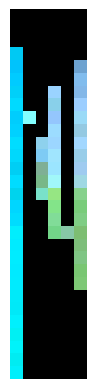

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


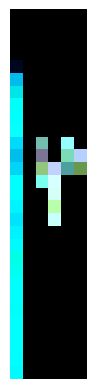

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


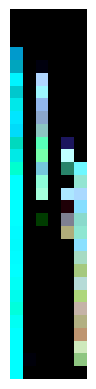

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


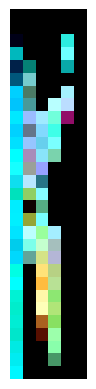

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


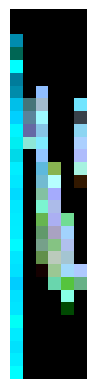

Epoch [100/300], Batch 0/64, Discriminator Loss: 0.6845, Generator Loss: 0.6636
tensor([[-0.4514],
        [-0.1723],
        [-0.1266]], requires_grad=True)
tensor([[-0.5575],
        [-0.4281],
        [ 0.3628]], requires_grad=True)
mean disc rating of real images: tensor(-0.3089)
mean disc rating of fake images: tensor(-0.4377)
Epoch: 102 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:39<00:00,  1.55s/it]

real image:


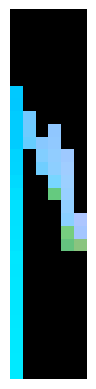

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


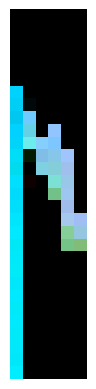

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


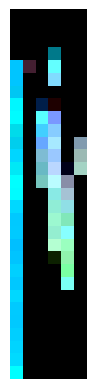

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


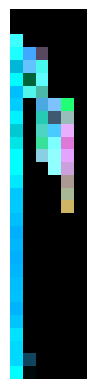

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [101/300], Batch 0/64, Discriminator Loss: 0.6708, Generator Loss: 0.9287
tensor([[0.5328],
        [0.5741],
        [0.3069]], requires_grad=True)
tensor([[0.1710],
        [0.2736],
        [0.3213]], requires_grad=True)
mean disc rating of real images: tensor(0.3332)
mean disc rating of fake images: tensor(0.1948)
Epoch: 103 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:39<00:00,  1.55s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


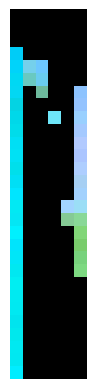

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


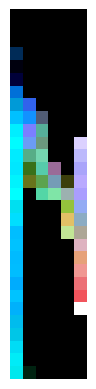

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


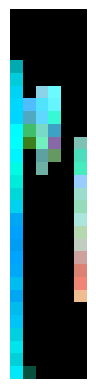

Epoch [102/300], Batch 0/64, Discriminator Loss: 0.6736, Generator Loss: 0.8429
tensor([[-0.1137],
        [ 0.5820],
        [ 0.1220]], requires_grad=True)
tensor([[ 0.2577],
        [ 0.0789],
        [-0.0116]], requires_grad=True)
mean disc rating of real images: tensor(0.2622)
mean disc rating of fake images: tensor(0.1314)
Epoch: 104 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:28<00:00,  1.39s/it]

real image:


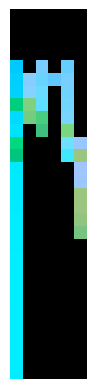

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


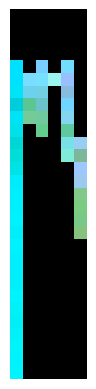

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


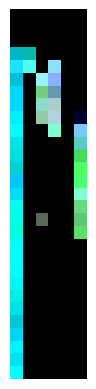

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


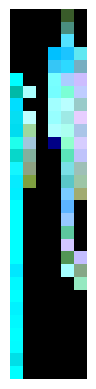

Epoch [103/300], Batch 0/64, Discriminator Loss: 0.6765, Generator Loss: 0.7950
tensor([[ 0.3320],
        [-0.3673],
        [ 0.0727]], requires_grad=True)
tensor([[0.0640],
        [0.1650],
        [0.0821]], requires_grad=True)
mean disc rating of real images: tensor(0.1134)
mean disc rating of fake images: tensor(0.0131)
Epoch: 105 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


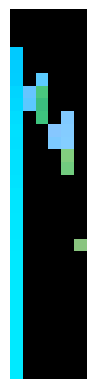

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


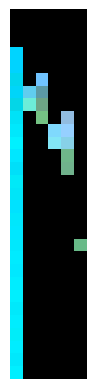

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


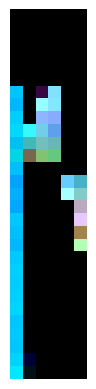

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


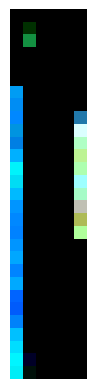

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


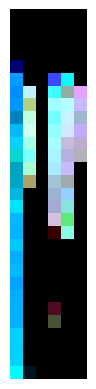

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


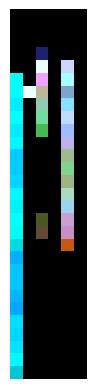

Epoch [104/300], Batch 0/64, Discriminator Loss: 0.6596, Generator Loss: 0.7835
tensor([[0.1697],
        [0.0222],
        [0.5111]], requires_grad=True)
tensor([[-0.1880],
        [ 0.0233],
        [-0.3985]], requires_grad=True)
mean disc rating of real images: tensor(0.1224)
mean disc rating of fake images: tensor(-0.0442)
Epoch: 106 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.36s/it]

real image:


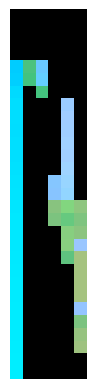

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


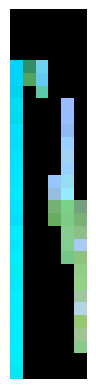

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


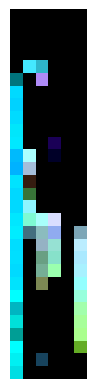

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


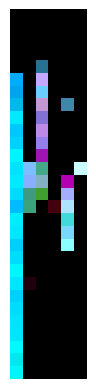

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


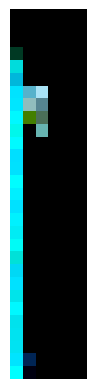

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [105/300], Batch 0/64, Discriminator Loss: 0.6555, Generator Loss: 0.7574
tensor([[ 0.3620],
        [ 0.2123],
        [-0.1681]], requires_grad=True)
tensor([[ 0.2166],
        [ 0.1468],
        [-0.0190]], requires_grad=True)
mean disc rating of real images: tensor(0.0717)
mean disc rating of fake images: tensor(-0.1079)
Epoch: 107 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


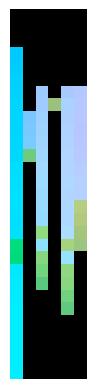

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


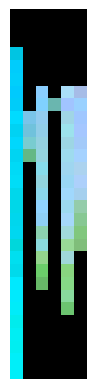

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


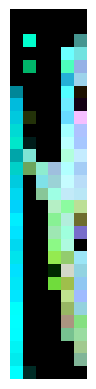

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


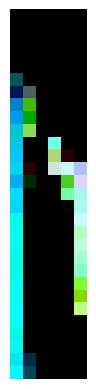

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [106/300], Batch 0/64, Discriminator Loss: 0.6711, Generator Loss: 0.7807
tensor([[ 0.7263],
        [-0.0304],
        [ 0.2241]], requires_grad=True)
tensor([[-0.3356],
        [-0.0539],
        [ 0.1108]], requires_grad=True)
mean disc rating of real images: tensor(0.1638)
mean disc rating of fake images: tensor(0.0368)
Epoch: 108 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


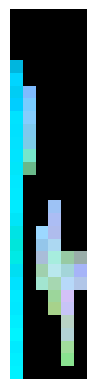

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


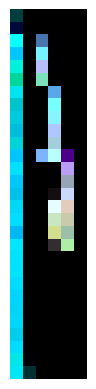

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


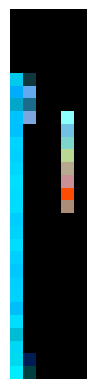

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


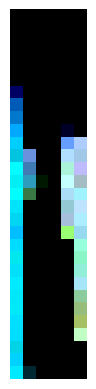

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [107/300], Batch 0/64, Discriminator Loss: 0.6662, Generator Loss: 0.8604
tensor([[-0.0223],
        [ 0.4578],
        [ 0.0284]], requires_grad=True)
tensor([[-0.2107],
        [ 0.3727],
        [ 0.3716]], requires_grad=True)
mean disc rating of real images: tensor(0.2183)
mean disc rating of fake images: tensor(0.0543)
Epoch: 109 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


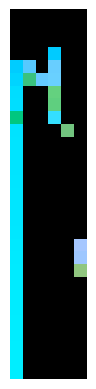

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


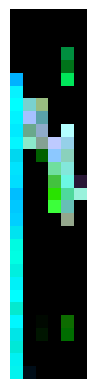

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


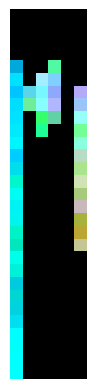

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


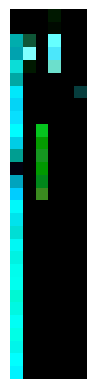

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


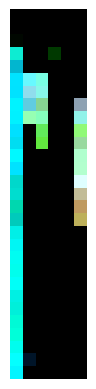

Epoch [108/300], Batch 0/64, Discriminator Loss: 0.6739, Generator Loss: 0.7756
tensor([[ 0.6405],
        [-0.4894],
        [ 0.0804]], requires_grad=True)
tensor([[ 0.0922],
        [-0.0422],
        [-0.6261]], requires_grad=True)
mean disc rating of real images: tensor(0.0482)
mean disc rating of fake images: tensor(-0.0799)
Epoch: 110 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


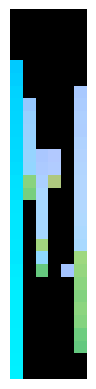

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


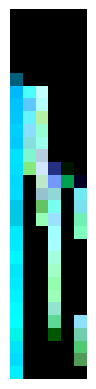

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


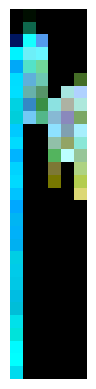

Epoch [109/300], Batch 0/64, Discriminator Loss: 0.6784, Generator Loss: 1.0432
tensor([[0.5465],
        [0.7363],
        [1.0596]], requires_grad=True)
tensor([[0.3983],
        [0.3286],
        [0.3490]], requires_grad=True)
mean disc rating of real images: tensor(0.6832)
mean disc rating of fake images: tensor(0.4355)
Epoch: 111 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


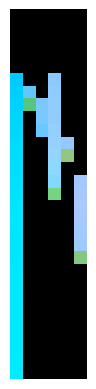

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


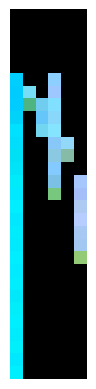

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


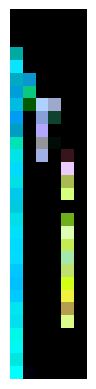

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


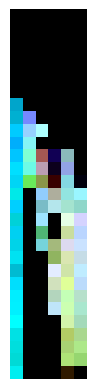

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


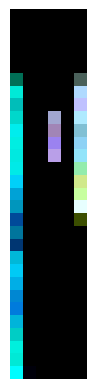

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


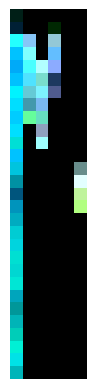

Epoch [110/300], Batch 0/64, Discriminator Loss: 0.6591, Generator Loss: 0.7945
tensor([[ 0.2086],
        [-0.2280],
        [ 0.5524]], requires_grad=True)
tensor([[-0.8786],
        [ 0.3388],
        [-0.4125]], requires_grad=True)
mean disc rating of real images: tensor(0.0513)
mean disc rating of fake images: tensor(-0.1560)
Epoch: 112 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


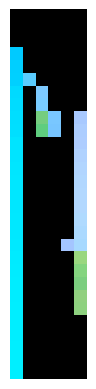

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


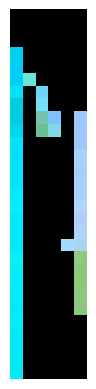

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


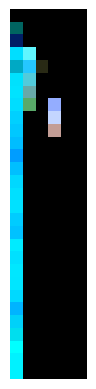

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


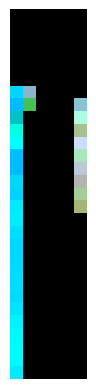

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


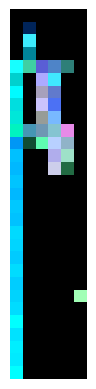

Epoch [111/300], Batch 0/64, Discriminator Loss: 0.6870, Generator Loss: 0.5965
tensor([[ 0.0913],
        [-0.4016],
        [ 0.1973]], requires_grad=True)
tensor([[ 0.4022],
        [-0.0384],
        [-0.4445]], requires_grad=True)
mean disc rating of real images: tensor(-0.2501)
mean disc rating of fake images: tensor(-0.4042)
Epoch: 113 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


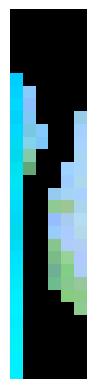

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


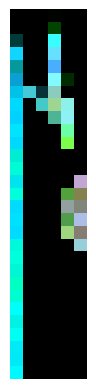

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


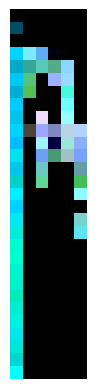

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


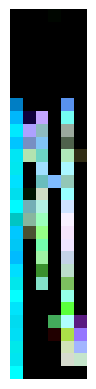

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


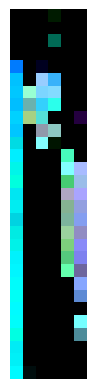

Epoch [112/300], Batch 0/64, Discriminator Loss: 0.6574, Generator Loss: 0.8451
tensor([[0.3150],
        [0.4560],
        [0.4934]], requires_grad=True)
tensor([[-0.6761],
        [ 0.3539],
        [ 0.1999]], requires_grad=True)
mean disc rating of real images: tensor(0.1216)
mean disc rating of fake images: tensor(-0.1005)
Epoch: 114 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


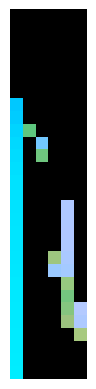

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


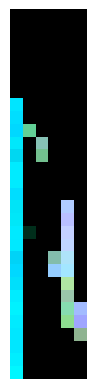

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


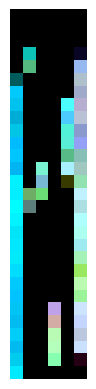

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


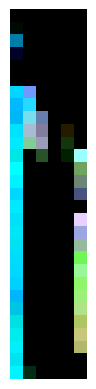

Epoch [113/300], Batch 0/64, Discriminator Loss: 0.6616, Generator Loss: 0.9836
tensor([[ 0.6880],
        [ 0.3409],
        [-0.2910]], requires_grad=True)
tensor([[ 0.7484],
        [ 0.6764],
        [-0.1239]], requires_grad=True)
mean disc rating of real images: tensor(0.3650)
mean disc rating of fake images: tensor(0.1257)
Epoch: 115 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


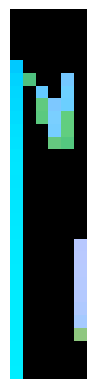

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


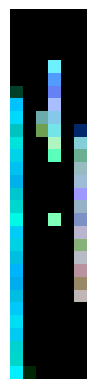

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


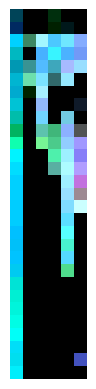

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


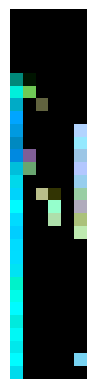

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


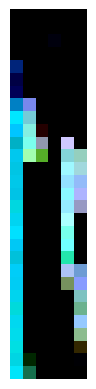

Epoch [114/300], Batch 0/64, Discriminator Loss: 0.6693, Generator Loss: 0.8228
tensor([[ 0.2448],
        [-0.3082],
        [ 0.2354]], requires_grad=True)
tensor([[-0.8649],
        [-0.2071],
        [-0.4571]], requires_grad=True)
mean disc rating of real images: tensor(0.1353)
mean disc rating of fake images: tensor(-0.0408)
Epoch: 116 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


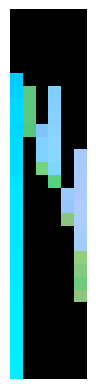

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


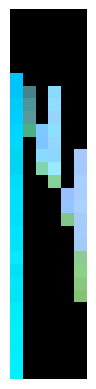

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


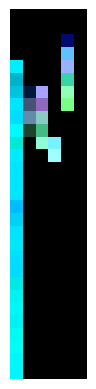

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


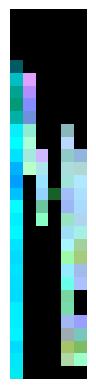

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


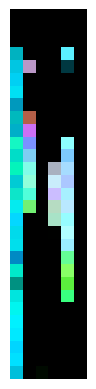

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


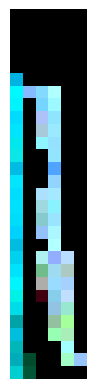

Epoch [115/300], Batch 0/64, Discriminator Loss: 0.6467, Generator Loss: 0.8739
tensor([[ 0.2284],
        [-0.0736],
        [ 0.3684]], requires_grad=True)
tensor([[ 0.2111],
        [-0.1267],
        [ 0.0780]], requires_grad=True)
mean disc rating of real images: tensor(0.1978)
mean disc rating of fake images: tensor(-0.0725)
Epoch: 117 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


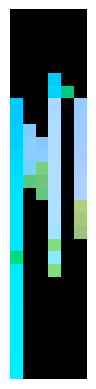

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


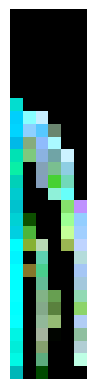

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


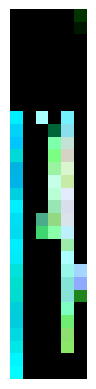

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


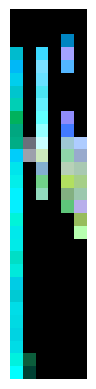

Epoch [116/300], Batch 0/64, Discriminator Loss: 0.6492, Generator Loss: 0.8545
tensor([[-0.0700],
        [ 0.4640],
        [ 0.2777]], requires_grad=True)
tensor([[ 0.1829],
        [-0.0880],
        [-0.2337]], requires_grad=True)
mean disc rating of real images: tensor(0.2571)
mean disc rating of fake images: tensor(-0.0152)
Epoch: 118 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


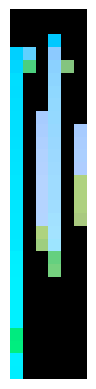

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


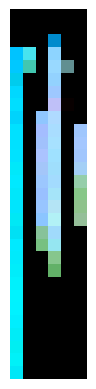

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


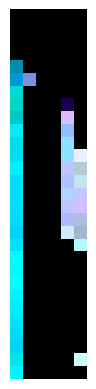

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


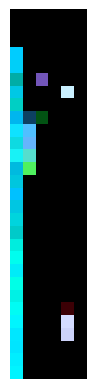

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


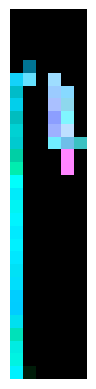

Epoch [117/300], Batch 0/64, Discriminator Loss: 0.6751, Generator Loss: 0.8026
tensor([[ 0.3263],
        [ 0.3699],
        [-0.2611]], requires_grad=True)
tensor([[-0.7448],
        [ 0.9296],
        [-0.5367]], requires_grad=True)
mean disc rating of real images: tensor(0.0177)
mean disc rating of fake images: tensor(-0.1826)
Epoch: 119 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


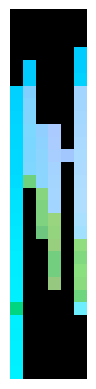

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


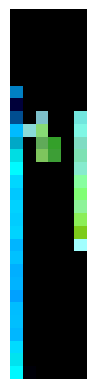

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


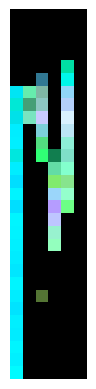

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


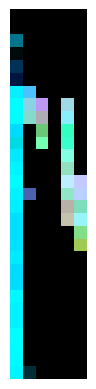

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


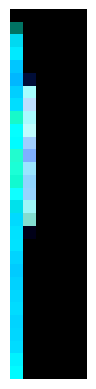

Epoch [118/300], Batch 0/64, Discriminator Loss: 0.6600, Generator Loss: 1.0142
tensor([[-0.0973],
        [-0.0259],
        [ 0.6112]], requires_grad=True)
tensor([[ 0.7952],
        [ 0.6030],
        [-0.1062]], requires_grad=True)
mean disc rating of real images: tensor(0.4799)
mean disc rating of fake images: tensor(0.1946)
Epoch: 120 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


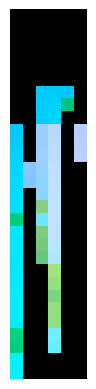

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


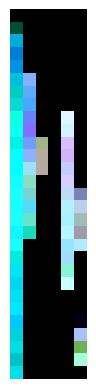

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


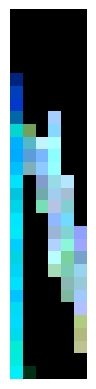

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


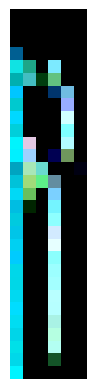

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


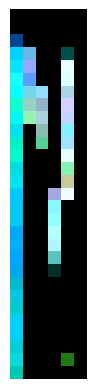

Epoch [119/300], Batch 0/64, Discriminator Loss: 0.6517, Generator Loss: 0.6956
tensor([[ 0.0153],
        [ 0.7819],
        [-0.0463]], requires_grad=True)
tensor([[-0.2619],
        [-0.3565],
        [-0.1854]], requires_grad=True)
mean disc rating of real images: tensor(-0.0731)
mean disc rating of fake images: tensor(-0.3296)
Epoch: 121 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


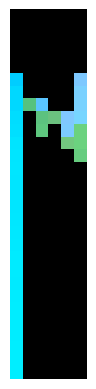

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


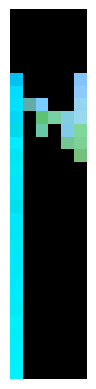

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


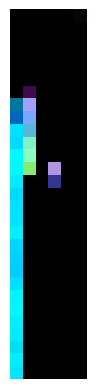

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


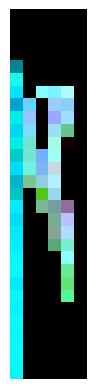

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


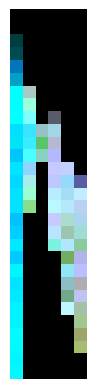

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


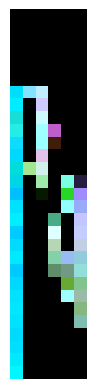

Epoch [120/300], Batch 0/64, Discriminator Loss: 0.6193, Generator Loss: 0.7756
tensor([[-0.2357],
        [ 0.0731],
        [ 0.1393]], requires_grad=True)
tensor([[-0.1978],
        [ 0.4927],
        [-0.6754]], requires_grad=True)
mean disc rating of real images: tensor(0.1353)
mean disc rating of fake images: tensor(-0.2742)
Epoch: 122 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


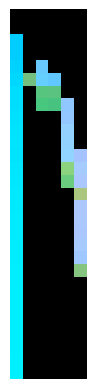

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


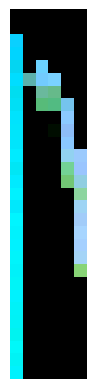

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


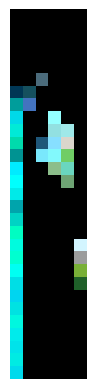

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


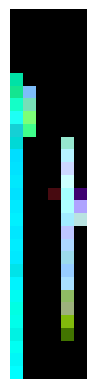

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


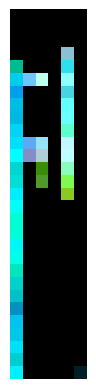

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


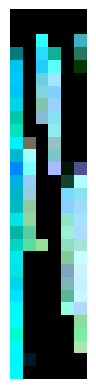

Epoch [121/300], Batch 0/64, Discriminator Loss: 0.6369, Generator Loss: 0.8487
tensor([[0.9123],
        [0.0771],
        [0.2319]], requires_grad=True)
tensor([[-0.7274],
        [-0.0439],
        [-0.5492]], requires_grad=True)
mean disc rating of real images: tensor(0.1719)
mean disc rating of fake images: tensor(-0.1809)
Epoch: 123 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


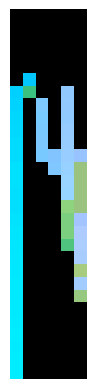

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


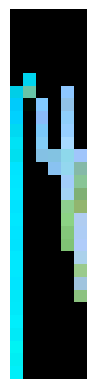

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


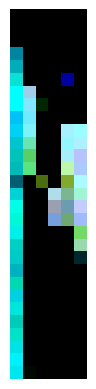

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


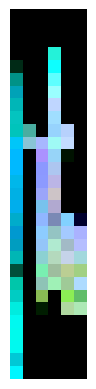

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


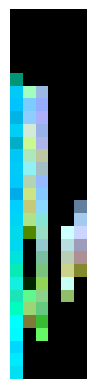

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


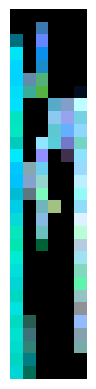

Epoch [122/300], Batch 0/64, Discriminator Loss: 0.6259, Generator Loss: 0.8343
tensor([[0.2558],
        [0.1905],
        [0.7204]], requires_grad=True)
tensor([[ 0.7406],
        [-0.4545],
        [ 0.1340]], requires_grad=True)
mean disc rating of real images: tensor(0.2670)
mean disc rating of fake images: tensor(-0.1132)
Epoch: 124 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


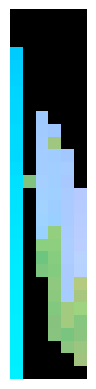

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


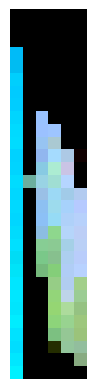

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


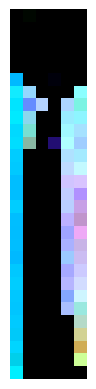

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


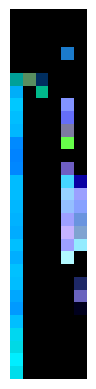

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


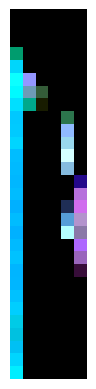

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


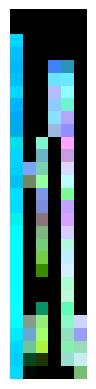

Epoch [123/300], Batch 0/64, Discriminator Loss: 0.7609, Generator Loss: 1.1657
tensor([[0.3631],
        [1.4944],
        [1.2672]], requires_grad=True)
tensor([[0.9858],
        [1.6870],
        [0.7571]], requires_grad=True)
mean disc rating of real images: tensor(1.1598)
mean disc rating of fake images: tensor(0.8340)
Epoch: 125 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


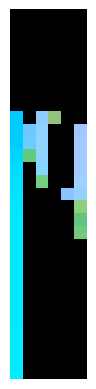

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


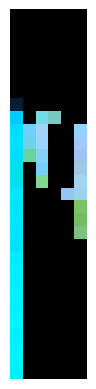

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


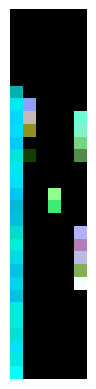

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


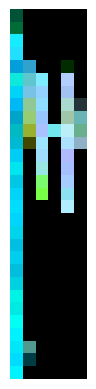

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


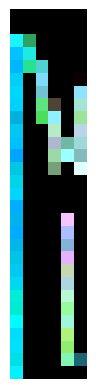

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


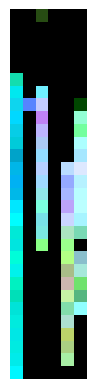

Epoch [124/300], Batch 0/64, Discriminator Loss: 0.6731, Generator Loss: 0.7841
tensor([[-0.2199],
        [ 0.2308],
        [-0.7011]], requires_grad=True)
tensor([[ 0.9316],
        [-0.2661],
        [ 0.7327]], requires_grad=True)
mean disc rating of real images: tensor(0.1987)
mean disc rating of fake images: tensor(-0.0075)
Epoch: 126 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


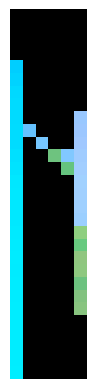

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


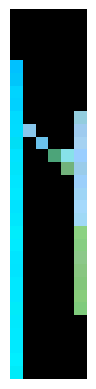

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


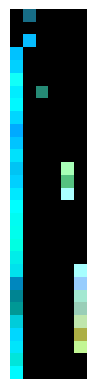

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


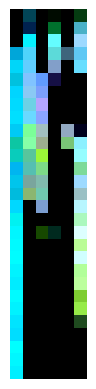

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


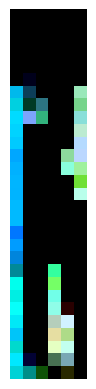

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


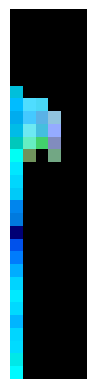

Epoch [125/300], Batch 0/64, Discriminator Loss: 0.6272, Generator Loss: 0.7994
tensor([[ 0.1575],
        [-0.5447],
        [-0.5731]], requires_grad=True)
tensor([[ 0.3472],
        [-0.4676],
        [-0.8588]], requires_grad=True)
mean disc rating of real images: tensor(0.0678)
mean disc rating of fake images: tensor(-0.2941)
Epoch: 127 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


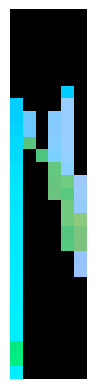

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


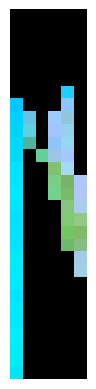

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


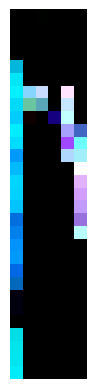

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


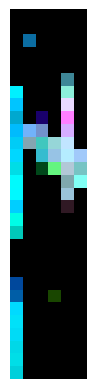

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


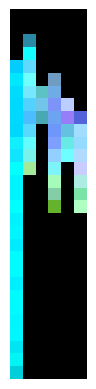

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


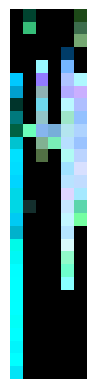

Epoch [126/300], Batch 0/64, Discriminator Loss: 0.6335, Generator Loss: 0.7771
tensor([[ 0.2710],
        [-0.1365],
        [ 0.0994]], requires_grad=True)
tensor([[-0.5870],
        [ 0.4578],
        [-0.0013]], requires_grad=True)
mean disc rating of real images: tensor(0.1014)
mean disc rating of fake images: tensor(-0.2282)
Epoch: 128 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


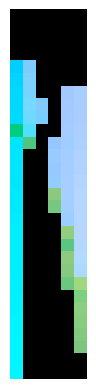

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


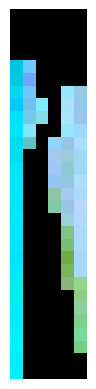

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


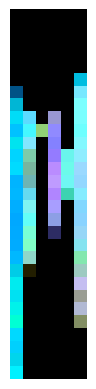

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


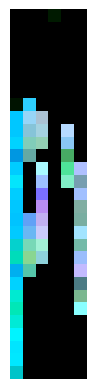

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


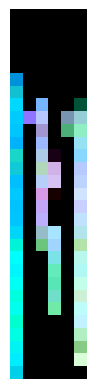

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


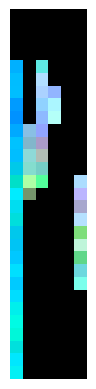

Epoch [127/300], Batch 0/64, Discriminator Loss: 0.6726, Generator Loss: 1.0895
tensor([[0.0618],
        [1.1644],
        [0.6413]], requires_grad=True)
tensor([[ 1.0186],
        [ 0.0671],
        [-0.1810]], requires_grad=True)
mean disc rating of real images: tensor(0.5638)
mean disc rating of fake images: tensor(0.2648)
Epoch: 129 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


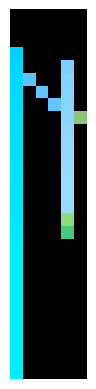

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


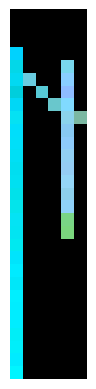

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


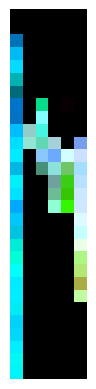

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


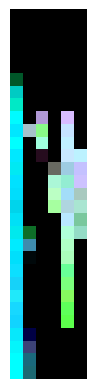

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


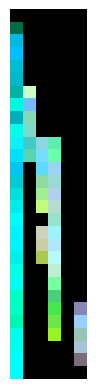

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


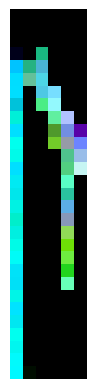

Epoch [128/300], Batch 0/64, Discriminator Loss: 0.6521, Generator Loss: 0.7705
tensor([[-0.1927],
        [ 0.2827],
        [-0.4573]], requires_grad=True)
tensor([[-0.6061],
        [-0.1416],
        [-0.5609]], requires_grad=True)
mean disc rating of real images: tensor(-0.0075)
mean disc rating of fake images: tensor(-0.2556)
Epoch: 130 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


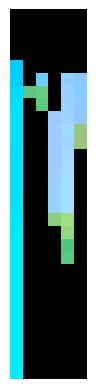

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


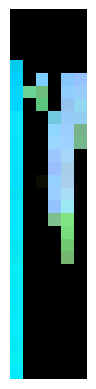

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


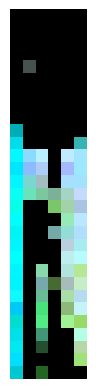

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


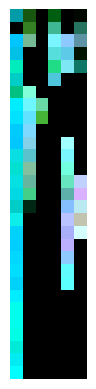

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


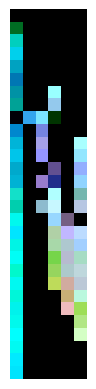

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


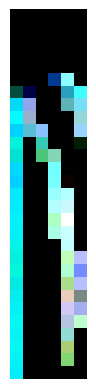

Epoch [129/300], Batch 0/64, Discriminator Loss: 0.6256, Generator Loss: 1.0275
tensor([[ 0.3138],
        [-0.0606],
        [ 0.0426]], requires_grad=True)
tensor([[0.0679],
        [0.4613],
        [0.1428]], requires_grad=True)
mean disc rating of real images: tensor(0.5064)
mean disc rating of fake images: tensor(0.0610)
Epoch: 131 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


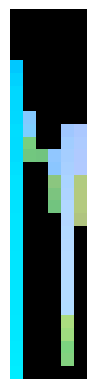

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


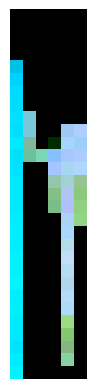

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


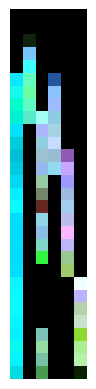

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [130/300], Batch 0/64, Discriminator Loss: 0.6558, Generator Loss: 0.7520
tensor([[-0.1322],
        [-0.1528],
        [-0.3836]], requires_grad=True)
tensor([[-0.1180],
        [-0.5346],
        [ 0.0488]], requires_grad=True)
mean disc rating of real images: tensor(-0.0388)
mean disc rating of fake images: tensor(-0.2989)
Epoch: 132 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


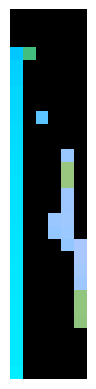

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


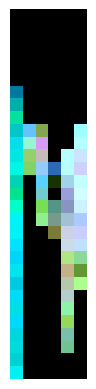

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


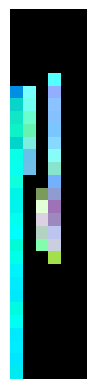

Epoch [131/300], Batch 0/64, Discriminator Loss: 0.6537, Generator Loss: 0.7333
tensor([[-0.3527],
        [-0.4244],
        [ 0.1053]], requires_grad=True)
tensor([[ 0.0843],
        [-0.9170],
        [ 0.2838]], requires_grad=True)
mean disc rating of real images: tensor(-0.0261)
mean disc rating of fake images: tensor(-0.3082)
Epoch: 133 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


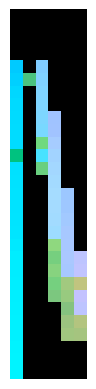

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


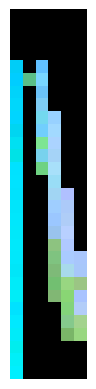

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


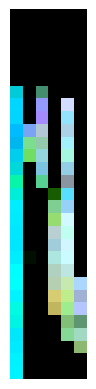

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


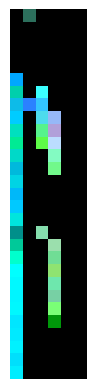

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


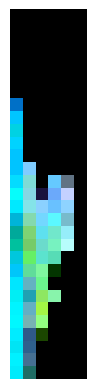

Epoch [132/300], Batch 0/64, Discriminator Loss: 0.6508, Generator Loss: 1.0239
tensor([[ 0.6283],
        [-0.3210],
        [ 0.5471]], requires_grad=True)
tensor([[ 0.1589],
        [ 0.3941],
        [-0.1109]], requires_grad=True)
mean disc rating of real images: tensor(0.4543)
mean disc rating of fake images: tensor(0.1233)
Epoch: 134 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


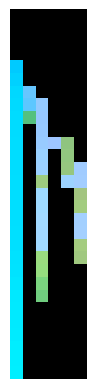

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


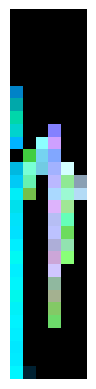

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


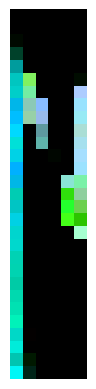

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [133/300], Batch 0/64, Discriminator Loss: 0.6418, Generator Loss: 0.7881
tensor([[0.7931],
        [1.0572],
        [0.9013]], requires_grad=True)
tensor([[-0.1884],
        [-0.6620],
        [ 0.7253]], requires_grad=True)
mean disc rating of real images: tensor(0.1340)
mean disc rating of fake images: tensor(-0.2239)
Epoch: 135 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


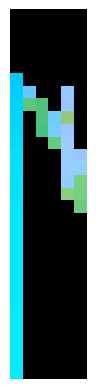

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


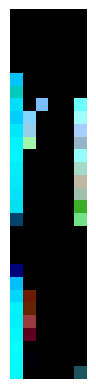

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


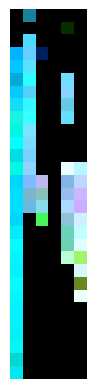

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


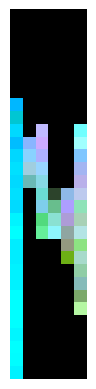

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


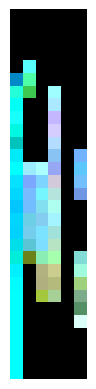

Epoch [134/300], Batch 0/64, Discriminator Loss: 0.6491, Generator Loss: 0.9399
tensor([[ 0.0256],
        [-0.0731],
        [ 0.0549]], requires_grad=True)
tensor([[ 0.7145],
        [-0.4083],
        [ 0.1207]], requires_grad=True)
mean disc rating of real images: tensor(0.1691)
mean disc rating of fake images: tensor(-0.1382)
Epoch: 136 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


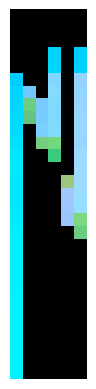

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


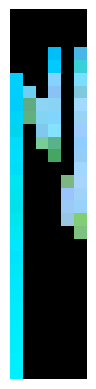

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


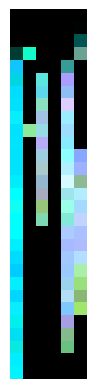

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


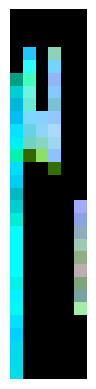

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


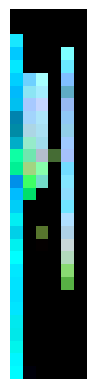

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


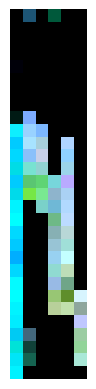

Epoch [135/300], Batch 0/64, Discriminator Loss: 0.6680, Generator Loss: 1.0570
tensor([[ 0.3604],
        [ 0.1195],
        [-0.0436]], requires_grad=True)
tensor([[1.0925],
        [0.7642],
        [0.8721]], requires_grad=True)
mean disc rating of real images: tensor(0.4431)
mean disc rating of fake images: tensor(0.1622)
Epoch: 137 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


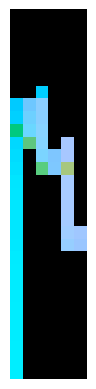

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


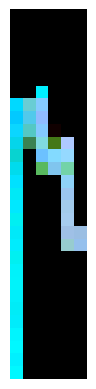

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


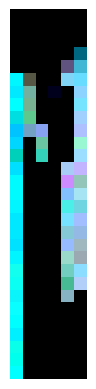

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


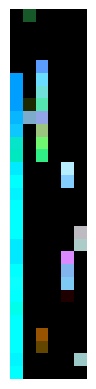

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


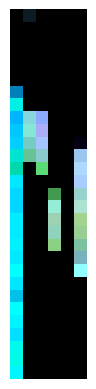

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


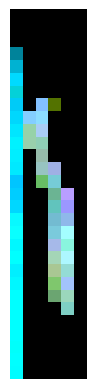

Epoch [136/300], Batch 0/64, Discriminator Loss: 0.6244, Generator Loss: 0.8762
tensor([[-0.1120],
        [-0.2041],
        [ 0.0232]], requires_grad=True)
tensor([[-1.3212],
        [ 0.1505],
        [ 0.2130]], requires_grad=True)
mean disc rating of real images: tensor(0.0457)
mean disc rating of fake images: tensor(-0.4174)
Epoch: 138 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


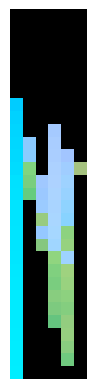

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


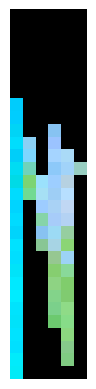

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


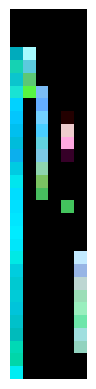

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


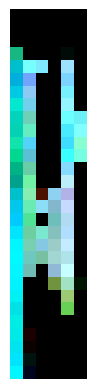

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


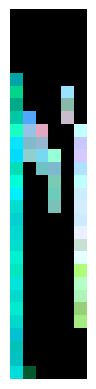

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


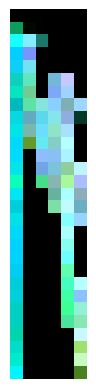

Epoch [137/300], Batch 0/64, Discriminator Loss: 0.6211, Generator Loss: 1.2346
tensor([[0.3952],
        [1.1749],
        [1.2116]], requires_grad=True)
tensor([[-0.3551],
        [ 0.4994],
        [ 0.4405]], requires_grad=True)
mean disc rating of real images: tensor(0.7407)
mean disc rating of fake images: tensor(0.1932)
Epoch: 139 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


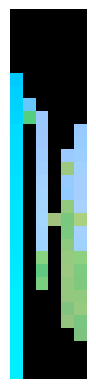

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


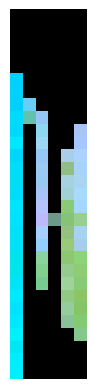

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


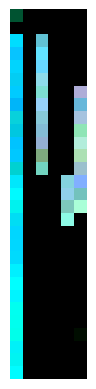

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


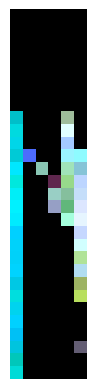

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


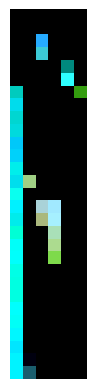

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


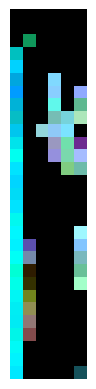

Epoch [138/300], Batch 0/64, Discriminator Loss: 0.6391, Generator Loss: 0.9014
tensor([[0.1931],
        [0.0092],
        [0.7770]], requires_grad=True)
tensor([[ 0.3491],
        [ 0.3992],
        [-1.2982]], requires_grad=True)
mean disc rating of real images: tensor(0.2909)
mean disc rating of fake images: tensor(-0.0451)
Epoch: 140 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


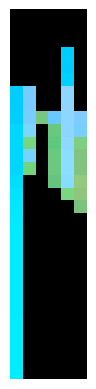

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


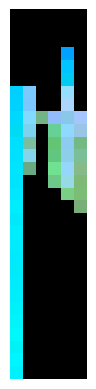

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random created images:


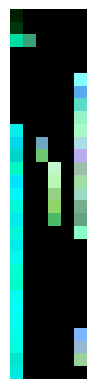

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


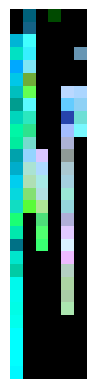

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


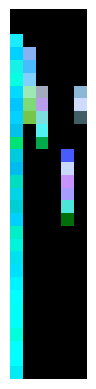

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


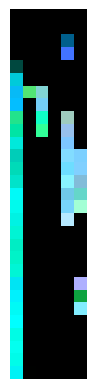

Epoch [139/300], Batch 0/64, Discriminator Loss: 0.6403, Generator Loss: 1.1559
tensor([[1.3455],
        [1.1947],
        [1.0975]], requires_grad=True)
tensor([[ 0.2329],
        [-0.3666],
        [-0.0290]], requires_grad=True)
mean disc rating of real images: tensor(0.5494)
mean disc rating of fake images: tensor(0.1433)
Epoch: 141 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


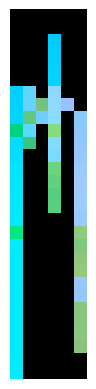

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


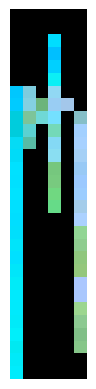

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


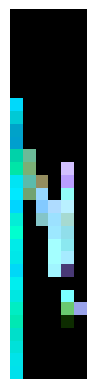

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


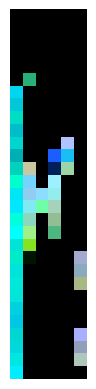

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


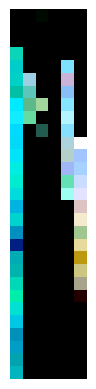

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


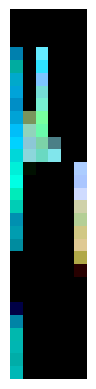

Epoch [140/300], Batch 0/64, Discriminator Loss: 0.6598, Generator Loss: 1.2107
tensor([[ 0.7043],
        [ 0.7509],
        [-0.1669]], requires_grad=True)
tensor([[0.8009],
        [0.8672],
        [0.4984]], requires_grad=True)
mean disc rating of real images: tensor(0.6708)
mean disc rating of fake images: tensor(0.2770)
Epoch: 142 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


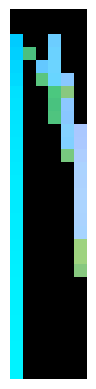

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


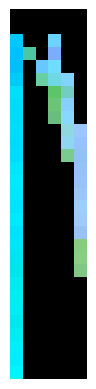

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


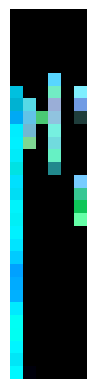

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


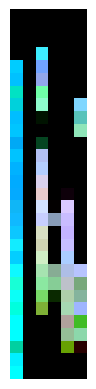

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


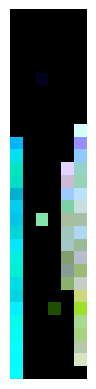

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


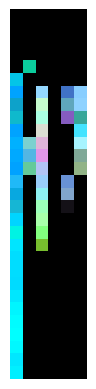

Epoch [141/300], Batch 0/64, Discriminator Loss: 0.7096, Generator Loss: 0.7392
tensor([[ 0.2496],
        [-0.6439],
        [-0.5035]], requires_grad=True)
tensor([[-0.8929],
        [-1.2113],
        [-1.0033]], requires_grad=True)
mean disc rating of real images: tensor(-0.6186)
mean disc rating of fake images: tensor(-1.0273)
Epoch: 143 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


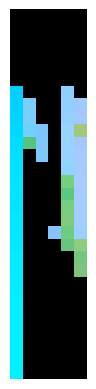

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


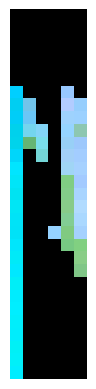

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


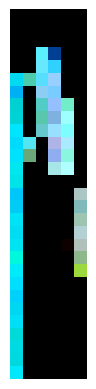

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


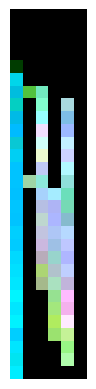

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


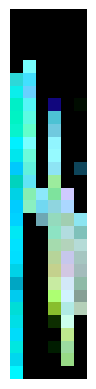

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


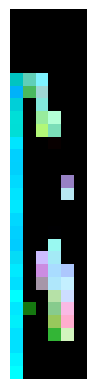

Epoch [142/300], Batch 0/64, Discriminator Loss: 0.6430, Generator Loss: 1.0571
tensor([[-0.3345],
        [ 0.0054],
        [-0.0622]], requires_grad=True)
tensor([[-0.1493],
        [ 0.1943],
        [-0.4924]], requires_grad=True)
mean disc rating of real images: tensor(0.3463)
mean disc rating of fake images: tensor(-0.0633)
Epoch: 144 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


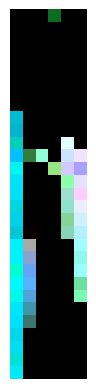

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


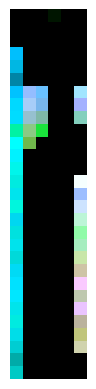

Epoch [143/300], Batch 0/64, Discriminator Loss: 0.6250, Generator Loss: 0.6839
tensor([[-0.4426],
        [-0.1663],
        [-0.2881]], requires_grad=True)
tensor([[-0.3532],
        [-0.1794],
        [-0.3294]], requires_grad=True)
mean disc rating of real images: tensor(-0.1037)
mean disc rating of fake images: tensor(-0.5931)
Epoch: 145 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


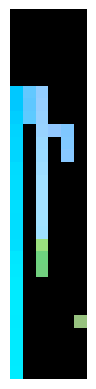

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


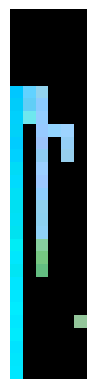

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


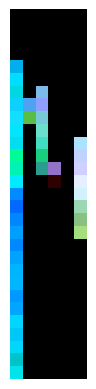

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [144/300], Batch 0/64, Discriminator Loss: 0.6366, Generator Loss: 0.6966
tensor([[ 0.7124],
        [-0.8742],
        [ 0.6046]], requires_grad=True)
tensor([[-0.5797],
        [ 0.1305],
        [-0.2779]], requires_grad=True)
mean disc rating of real images: tensor(0.0830)
mean disc rating of fake images: tensor(-0.2533)
Epoch: 146 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


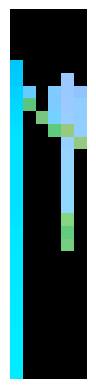

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


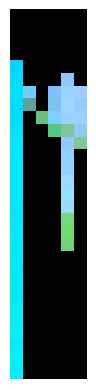

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


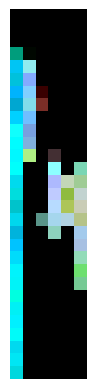

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


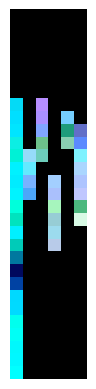

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [145/300], Batch 0/64, Discriminator Loss: 0.6330, Generator Loss: 0.8432
tensor([[-0.1927],
        [-0.0854],
        [ 0.2833]], requires_grad=True)
tensor([[ 0.0552],
        [-0.2898],
        [ 0.5873]], requires_grad=True)
mean disc rating of real images: tensor(-0.0535)
mean disc rating of fake images: tensor(-0.4859)
Epoch: 147 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


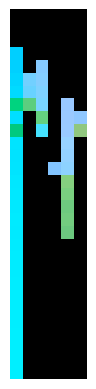

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


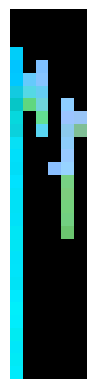

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


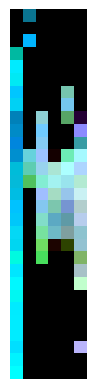

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


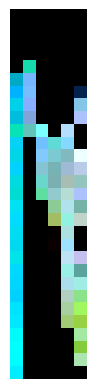

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


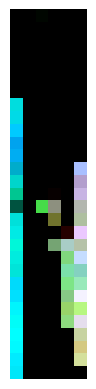

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


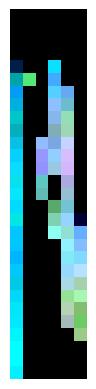

Epoch [146/300], Batch 0/64, Discriminator Loss: 0.6503, Generator Loss: 0.6504
tensor([[-0.9686],
        [ 0.2400],
        [-0.3684]], requires_grad=True)
tensor([[-0.9048],
        [-1.0159],
        [-0.9518]], requires_grad=True)
mean disc rating of real images: tensor(-0.3598)
mean disc rating of fake images: tensor(-0.8461)
Epoch: 148 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


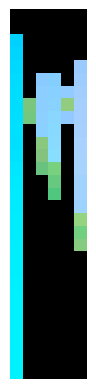

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


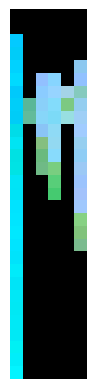

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random created images:


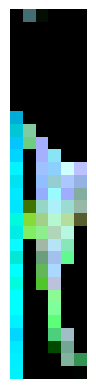

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


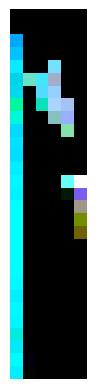

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


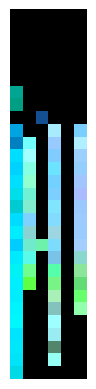

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


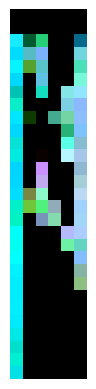

Epoch [147/300], Batch 0/64, Discriminator Loss: 0.6315, Generator Loss: 0.8116
tensor([[-0.1798],
        [ 0.5293],
        [ 1.0401]], requires_grad=True)
tensor([[-0.1803],
        [-0.8511],
        [-0.9721]], requires_grad=True)
mean disc rating of real images: tensor(0.0606)
mean disc rating of fake images: tensor(-0.3813)
Epoch: 149 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


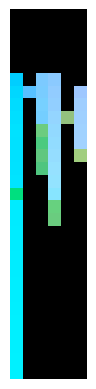

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


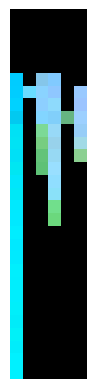

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


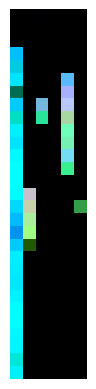

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


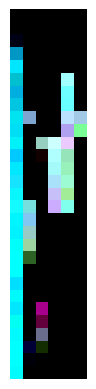

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


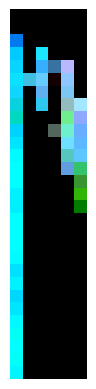

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


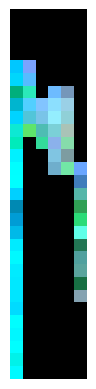

Epoch [148/300], Batch 0/64, Discriminator Loss: 0.6203, Generator Loss: 0.9550
tensor([[ 0.9400],
        [ 0.6462],
        [-0.0399]], requires_grad=True)
tensor([[ 0.9212],
        [-0.8707],
        [-0.8428]], requires_grad=True)
mean disc rating of real images: tensor(0.4936)
mean disc rating of fake images: tensor(-0.0378)
Epoch: 150 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


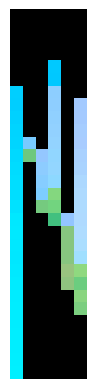

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


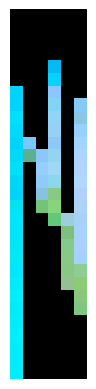

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


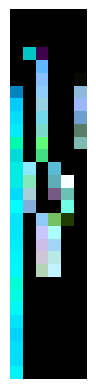

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


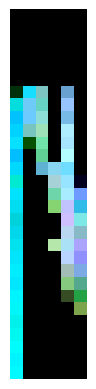

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


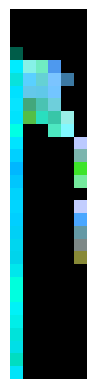

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


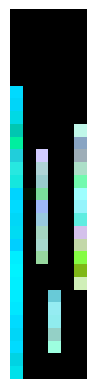

Epoch [149/300], Batch 0/64, Discriminator Loss: 0.6181, Generator Loss: 0.7680
tensor([[-1.0377],
        [-0.0953],
        [ 1.2090]], requires_grad=True)
tensor([[-0.2523],
        [ 0.2933],
        [-0.6090]], requires_grad=True)
mean disc rating of real images: tensor(-0.0686)
mean disc rating of fake images: tensor(-0.6320)
Epoch: 151 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.36s/it]

real image:


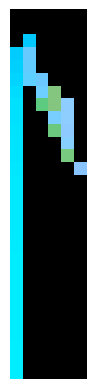

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


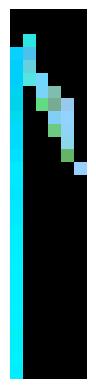

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


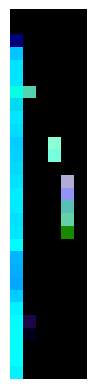

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


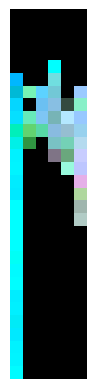

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


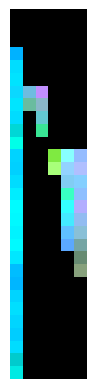

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


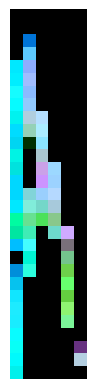

Epoch [150/300], Batch 0/64, Discriminator Loss: 0.6156, Generator Loss: 0.9212
tensor([[ 0.7428],
        [ 0.1047],
        [-0.4665]], requires_grad=True)
tensor([[ 0.1586],
        [-0.3306],
        [ 0.2904]], requires_grad=True)
mean disc rating of real images: tensor(0.2519)
mean disc rating of fake images: tensor(-0.2499)
Epoch: 152 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.37s/it]

real image:


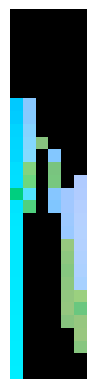

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


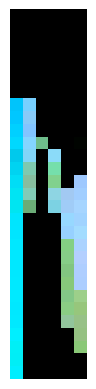

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


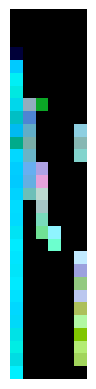

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


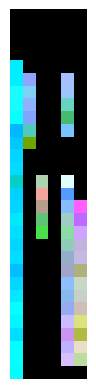

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


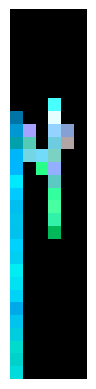

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


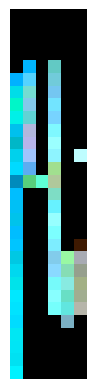

Epoch [151/300], Batch 0/64, Discriminator Loss: 0.7143, Generator Loss: 1.5366
tensor([[0.2507],
        [1.1022],
        [0.6351]], requires_grad=True)
tensor([[-0.5301],
        [-0.9934],
        [ 0.5273]], requires_grad=True)
mean disc rating of real images: tensor(0.9539)
mean disc rating of fake images: tensor(0.5811)
Epoch: 153 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.37s/it]

real image:


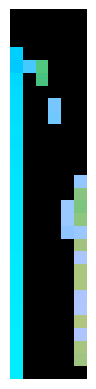

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


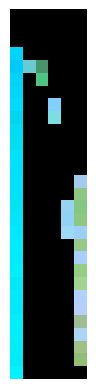

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


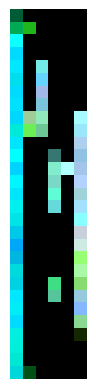

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


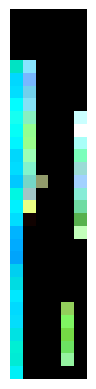

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


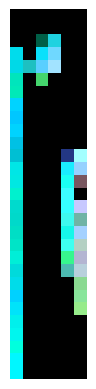

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


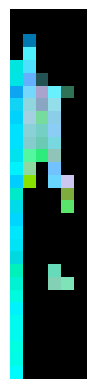

Epoch [152/300], Batch 0/64, Discriminator Loss: 0.6399, Generator Loss: 0.9688
tensor([[ 0.9056],
        [ 0.4024],
        [-0.5626]], requires_grad=True)
tensor([[-0.5227],
        [-1.2298],
        [-0.1734]], requires_grad=True)
mean disc rating of real images: tensor(0.2849)
mean disc rating of fake images: tensor(-0.1068)
Epoch: 154 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


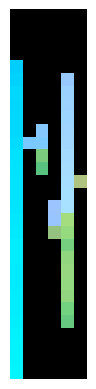

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


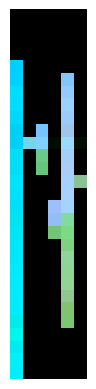

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


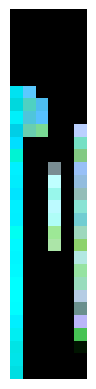

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


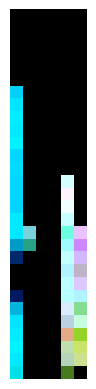

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


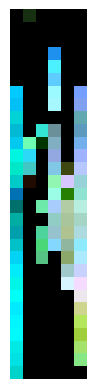

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


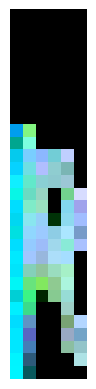

Epoch [153/300], Batch 0/64, Discriminator Loss: 0.6501, Generator Loss: 0.7313
tensor([[0.1127],
        [1.3538],
        [1.7701]], requires_grad=True)
tensor([[-0.5458],
        [-0.4190],
        [ 1.1135]], requires_grad=True)
mean disc rating of real images: tensor(-0.0431)
mean disc rating of fake images: tensor(-0.4959)
Epoch: 155 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


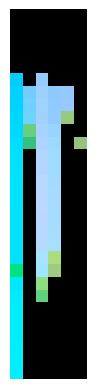

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


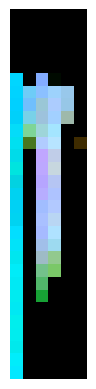

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


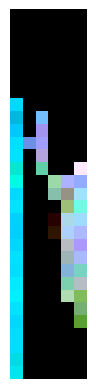

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


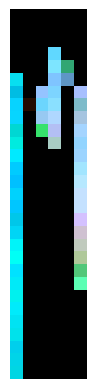

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


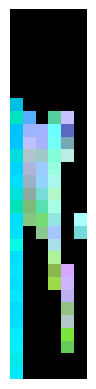

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


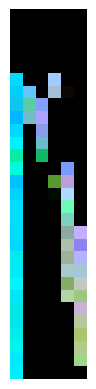

Epoch [154/300], Batch 0/64, Discriminator Loss: 0.6599, Generator Loss: 0.8773
tensor([[ 1.0717],
        [-0.1266],
        [ 0.1164]], requires_grad=True)
tensor([[-0.2470],
        [-0.1461],
        [-1.1311]], requires_grad=True)
mean disc rating of real images: tensor(0.0875)
mean disc rating of fake images: tensor(-0.2618)
Epoch: 156 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


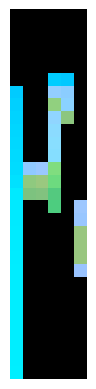

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


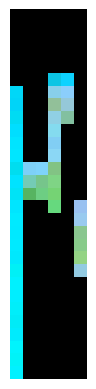

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


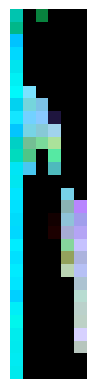

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


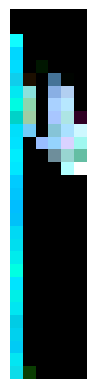

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


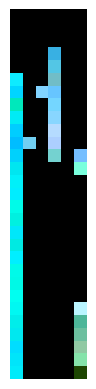

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


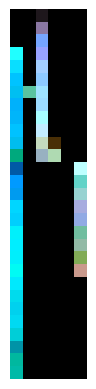

Epoch [155/300], Batch 0/64, Discriminator Loss: 0.6386, Generator Loss: 1.2992
tensor([[0.3232],
        [0.6253],
        [1.1458]], requires_grad=True)
tensor([[ 0.5174],
        [ 0.2894],
        [-1.1355]], requires_grad=True)
mean disc rating of real images: tensor(0.7592)
mean disc rating of fake images: tensor(0.2053)
Epoch: 157 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


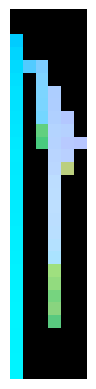

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


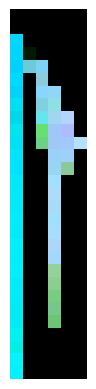

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


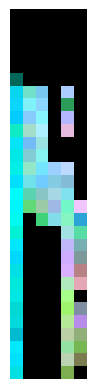

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


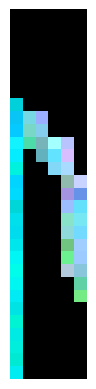

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


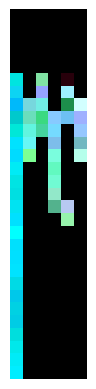

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


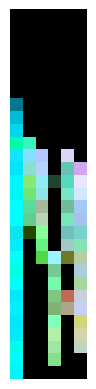

Epoch [156/300], Batch 0/64, Discriminator Loss: 0.6033, Generator Loss: 0.8671
tensor([[0.7666],
        [0.5862],
        [0.2750]], requires_grad=True)
tensor([[-0.0642],
        [ 0.0586],
        [-0.9231]], requires_grad=True)
mean disc rating of real images: tensor(0.3440)
mean disc rating of fake images: tensor(-0.2241)
Epoch: 158 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


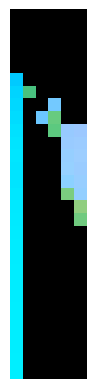

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


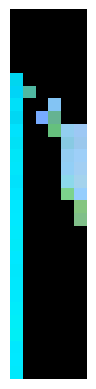

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


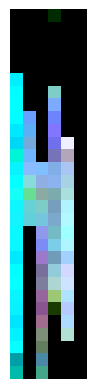

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


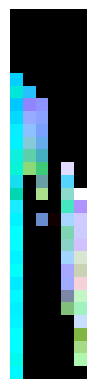

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


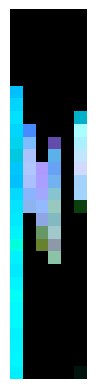

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


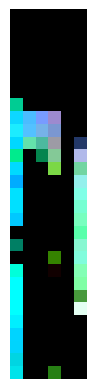

Epoch [157/300], Batch 0/64, Discriminator Loss: 0.6484, Generator Loss: 1.5938
tensor([[0.9191],
        [0.7791],
        [1.2622]], requires_grad=True)
tensor([[ 0.1486],
        [-0.6984],
        [-0.3586]], requires_grad=True)
mean disc rating of real images: tensor(0.9819)
mean disc rating of fake images: tensor(0.4002)
Epoch: 159 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


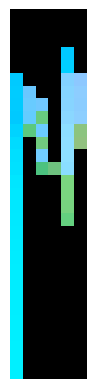

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


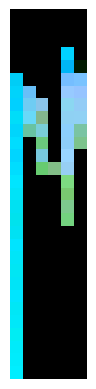

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


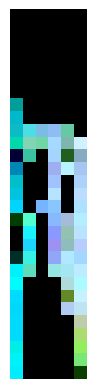

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


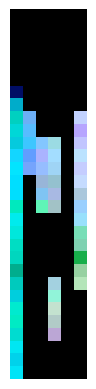

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


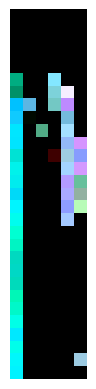

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


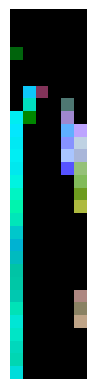

Epoch [158/300], Batch 0/64, Discriminator Loss: 0.6255, Generator Loss: 1.0135
tensor([[-0.5028],
        [ 0.0558],
        [ 0.0448]], requires_grad=True)
tensor([[-1.9105],
        [-1.9670],
        [-0.9232]], requires_grad=True)
mean disc rating of real images: tensor(-0.2560)
mean disc rating of fake images: tensor(-0.9215)
Epoch: 160 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


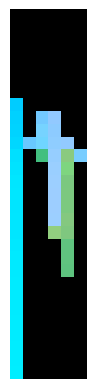

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


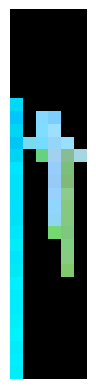

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


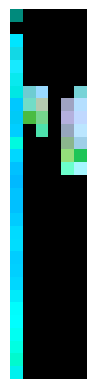

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


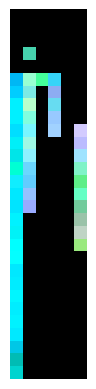

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


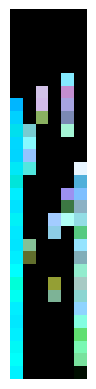

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


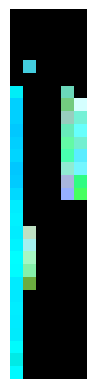

Epoch [159/300], Batch 0/64, Discriminator Loss: 0.6496, Generator Loss: 0.6820
tensor([[ 0.2243],
        [-0.3204],
        [-0.2157]], requires_grad=True)
tensor([[-0.6116],
        [-1.0159],
        [ 2.5659]], requires_grad=True)
mean disc rating of real images: tensor(-0.0096)
mean disc rating of fake images: tensor(-0.4916)
Epoch: 161 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


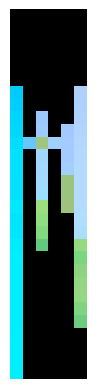

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


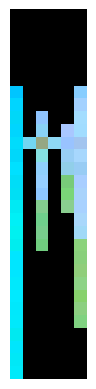

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


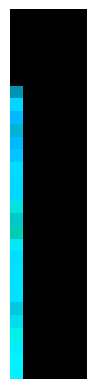

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


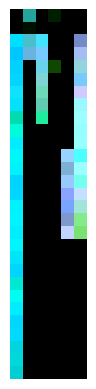

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


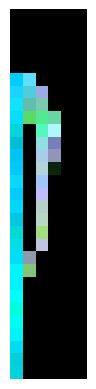

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


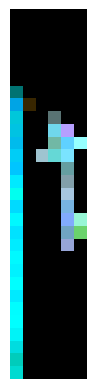

Epoch [160/300], Batch 0/64, Discriminator Loss: 0.6474, Generator Loss: 1.2328
tensor([[1.6377],
        [1.0547],
        [0.3744]], requires_grad=True)
tensor([[0.1082],
        [0.5757],
        [0.0058]], requires_grad=True)
mean disc rating of real images: tensor(0.6348)
mean disc rating of fake images: tensor(0.1680)
Epoch: 162 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


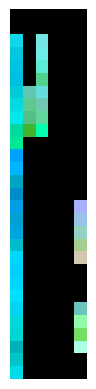

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


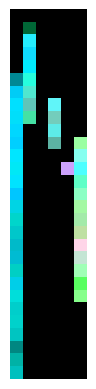

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


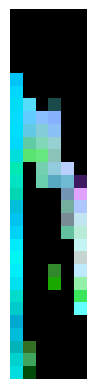

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


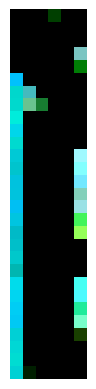

Epoch [161/300], Batch 0/64, Discriminator Loss: 0.6276, Generator Loss: 0.7572
tensor([[-0.8287],
        [-0.5677],
        [ 0.0314]], requires_grad=True)
tensor([[ 0.0248],
        [-0.8839],
        [-0.9441]], requires_grad=True)
mean disc rating of real images: tensor(-0.0811)
mean disc rating of fake images: tensor(-0.6144)
Epoch: 163 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


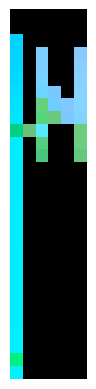

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


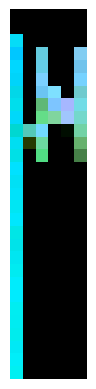

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


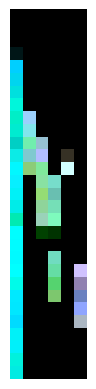

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


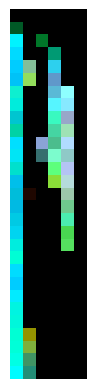

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


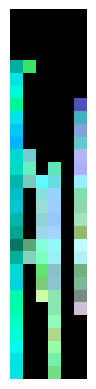

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


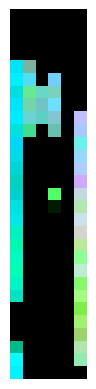

Epoch [162/300], Batch 0/64, Discriminator Loss: 0.6138, Generator Loss: 0.9388
tensor([[-0.3011],
        [ 0.0080],
        [-0.6128]], requires_grad=True)
tensor([[-0.3770],
        [ 0.2748],
        [-1.8434]], requires_grad=True)
mean disc rating of real images: tensor(0.1710)
mean disc rating of fake images: tensor(-0.4356)
Epoch: 164 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


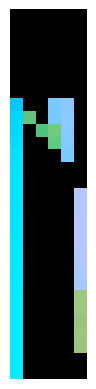

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


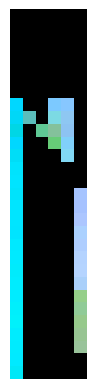

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


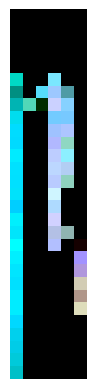

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


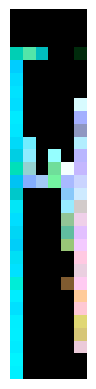

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


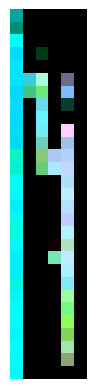

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


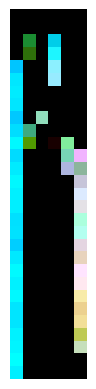

Epoch [163/300], Batch 0/64, Discriminator Loss: 0.5736, Generator Loss: 0.8900
tensor([[0.7019],
        [0.6849],
        [0.5941]], requires_grad=True)
tensor([[ 0.3407],
        [ 0.0876],
        [-0.0127]], requires_grad=True)
mean disc rating of real images: tensor(0.3599)
mean disc rating of fake images: tensor(-0.4028)
Epoch: 165 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


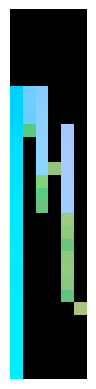

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


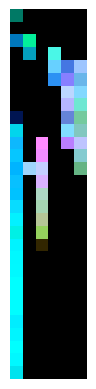

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


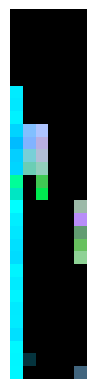

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


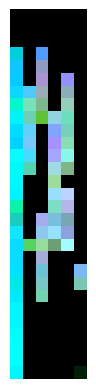

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [164/300], Batch 0/64, Discriminator Loss: 0.6069, Generator Loss: 1.0686
tensor([[0.6560],
        [0.4001],
        [0.2464]], requires_grad=True)
tensor([[ 0.7824],
        [ 0.1512],
        [-0.3156]], requires_grad=True)
mean disc rating of real images: tensor(0.3233)
mean disc rating of fake images: tensor(-0.3154)
Epoch: 166 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


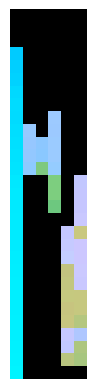

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


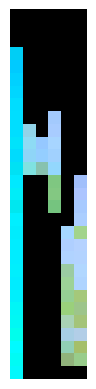

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


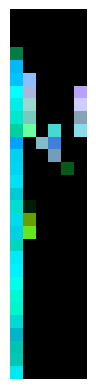

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


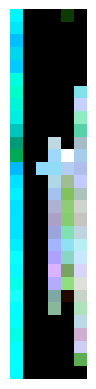

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


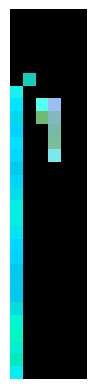

Epoch [165/300], Batch 0/64, Discriminator Loss: 0.6323, Generator Loss: 1.0544
tensor([[ 0.2052],
        [-0.1949],
        [ 0.8999]], requires_grad=True)
tensor([[-0.0209],
        [ 0.1978],
        [-0.1614]], requires_grad=True)
mean disc rating of real images: tensor(0.5517)
mean disc rating of fake images: tensor(0.0569)
Epoch: 167 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


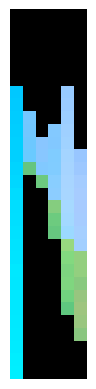

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


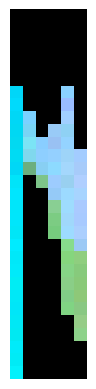

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


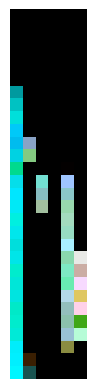

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


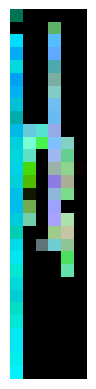

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


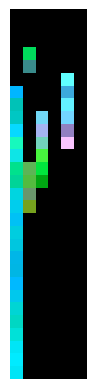

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


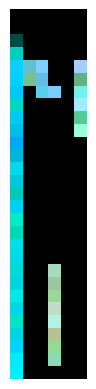

Epoch [166/300], Batch 0/64, Discriminator Loss: 0.6220, Generator Loss: 1.4334
tensor([[0.7879],
        [0.7183],
        [0.8209]], requires_grad=True)
tensor([[-1.8689],
        [-1.1082],
        [ 1.0160]], requires_grad=True)
mean disc rating of real images: tensor(0.9224)
mean disc rating of fake images: tensor(0.1681)
Epoch: 168 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


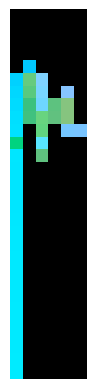

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


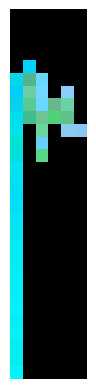

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


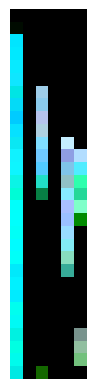

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


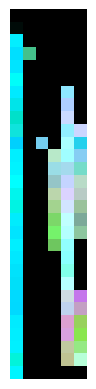

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


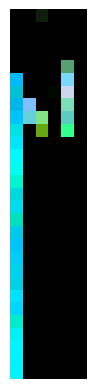

Epoch [167/300], Batch 0/64, Discriminator Loss: 0.5985, Generator Loss: 0.9500
tensor([[ 0.1803],
        [ 0.0881],
        [-0.2390]], requires_grad=True)
tensor([[-1.4993],
        [-0.4269],
        [-0.6745]], requires_grad=True)
mean disc rating of real images: tensor(0.1551)
mean disc rating of fake images: tensor(-0.4772)
Epoch: 169 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


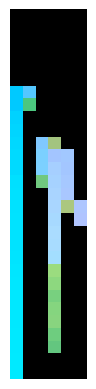

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


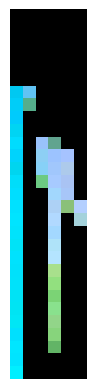

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


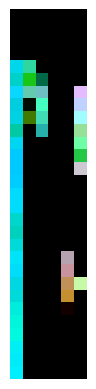

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


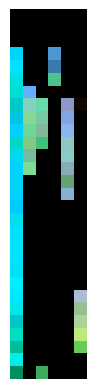

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


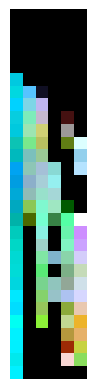

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


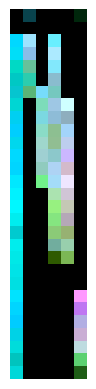

Epoch [168/300], Batch 0/64, Discriminator Loss: 0.6123, Generator Loss: 0.8102
tensor([[-0.0756],
        [-0.0693],
        [-0.7239]], requires_grad=True)
tensor([[-0.5795],
        [-0.2084],
        [ 0.0127]], requires_grad=True)
mean disc rating of real images: tensor(0.0892)
mean disc rating of fake images: tensor(-0.4656)
Epoch: 170 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


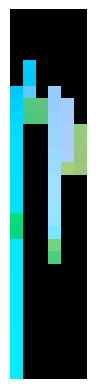

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


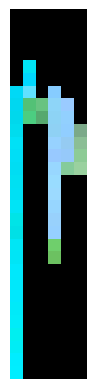

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


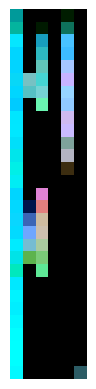

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


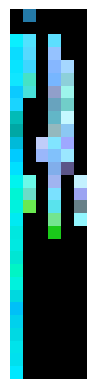

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


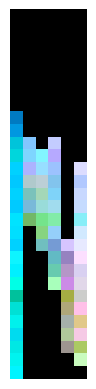

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


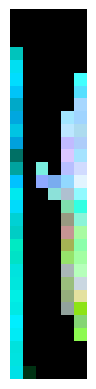

Epoch [169/300], Batch 0/64, Discriminator Loss: 0.6446, Generator Loss: 0.7283
tensor([[-0.7825],
        [ 0.1586],
        [-0.0780]], requires_grad=True)
tensor([[-0.4908],
        [-0.9140],
        [-0.6554]], requires_grad=True)
mean disc rating of real images: tensor(-0.0714)
mean disc rating of fake images: tensor(-0.5449)
Epoch: 171 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


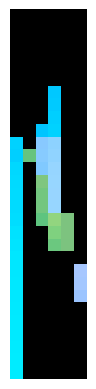

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


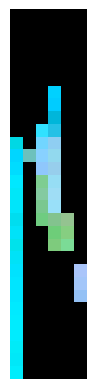

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


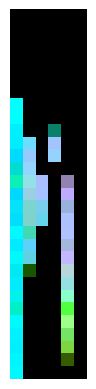

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


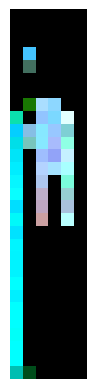

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


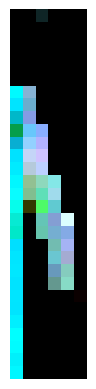

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


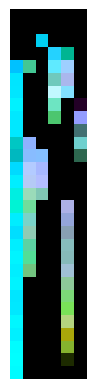

Epoch [170/300], Batch 0/64, Discriminator Loss: 0.6052, Generator Loss: 1.0120
tensor([[-0.3722],
        [ 0.3627],
        [ 0.0561]], requires_grad=True)
tensor([[-0.9371],
        [-0.0209],
        [ 0.5393]], requires_grad=True)
mean disc rating of real images: tensor(0.3400)
mean disc rating of fake images: tensor(-0.2595)
Epoch: 172 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


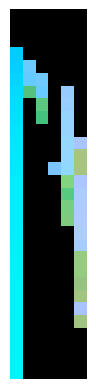

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


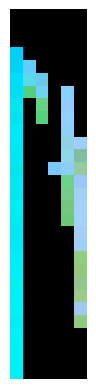

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


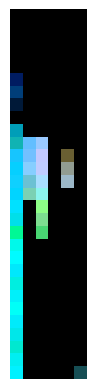

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


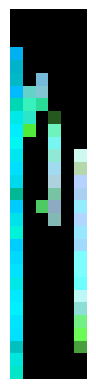

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


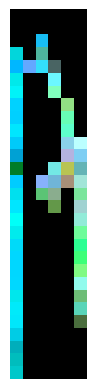

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


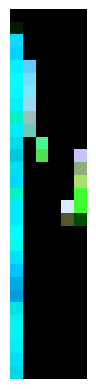

Epoch [171/300], Batch 0/64, Discriminator Loss: 0.5860, Generator Loss: 0.9907
tensor([[0.0254],
        [1.4174],
        [0.1811]], requires_grad=True)
tensor([[ 0.2974],
        [-0.9457],
        [-0.7532]], requires_grad=True)
mean disc rating of real images: tensor(0.3696)
mean disc rating of fake images: tensor(-0.3307)
Epoch: 173 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


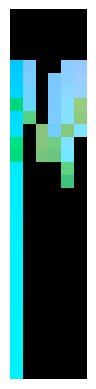

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


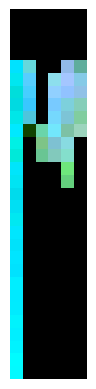

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


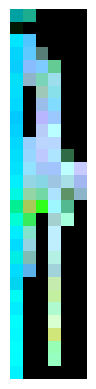

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


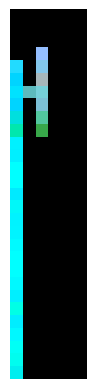

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


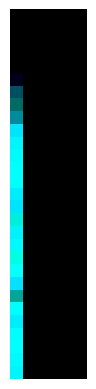

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


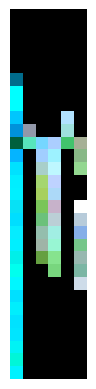

Epoch [172/300], Batch 0/64, Discriminator Loss: 0.5734, Generator Loss: 0.9011
tensor([[-0.5187],
        [-0.3582],
        [-0.2743]], requires_grad=True)
tensor([[-0.0260],
        [-3.4804],
        [-1.4479]], requires_grad=True)
mean disc rating of real images: tensor(0.1665)
mean disc rating of fake images: tensor(-0.6164)
Epoch: 174 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.36s/it]

real image:


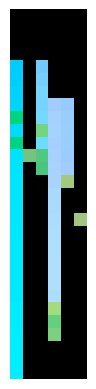

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


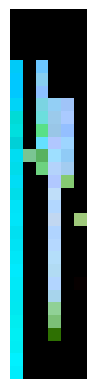

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


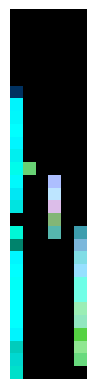

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


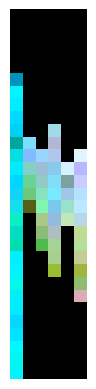

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


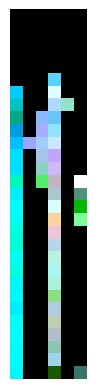

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


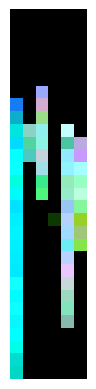

Epoch [173/300], Batch 0/64, Discriminator Loss: 0.6127, Generator Loss: 1.0790
tensor([[0.6678],
        [0.2602],
        [1.0704]], requires_grad=True)
tensor([[-0.1311],
        [ 0.7289],
        [ 0.1375]], requires_grad=True)
mean disc rating of real images: tensor(0.4166)
mean disc rating of fake images: tensor(-0.2186)
Epoch: 175 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


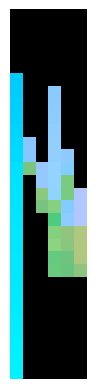

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


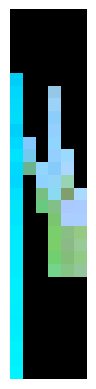

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


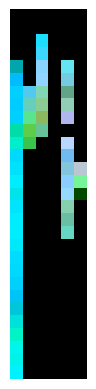

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


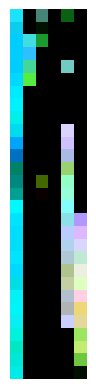

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


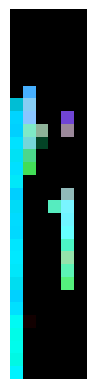

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


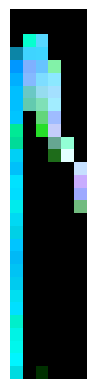

Epoch [174/300], Batch 0/64, Discriminator Loss: 0.6127, Generator Loss: 0.8125
tensor([[ 0.2773],
        [-0.0665],
        [-0.4696]], requires_grad=True)
tensor([[-0.1500],
        [-0.5849],
        [-0.4899]], requires_grad=True)
mean disc rating of real images: tensor(-0.0914)
mean disc rating of fake images: tensor(-0.7118)
Epoch: 176 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


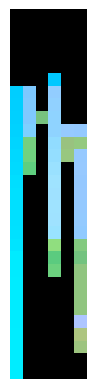

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


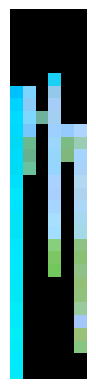

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


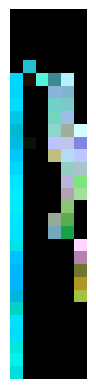

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


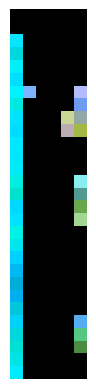

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


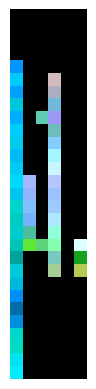

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


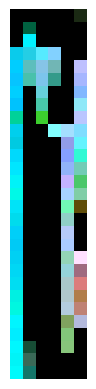

Epoch [175/300], Batch 0/64, Discriminator Loss: 0.6372, Generator Loss: 0.8212
tensor([[-0.0293],
        [-0.0108],
        [ 0.8540]], requires_grad=True)
tensor([[-0.9155],
        [-1.5645],
        [-0.3829]], requires_grad=True)
mean disc rating of real images: tensor(-0.1284)
mean disc rating of fake images: tensor(-0.7658)
Epoch: 177 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


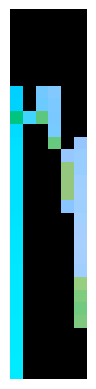

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


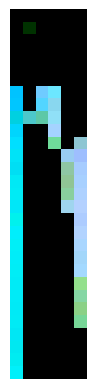

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


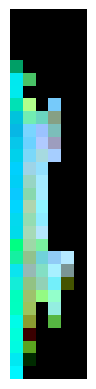

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


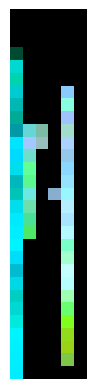

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


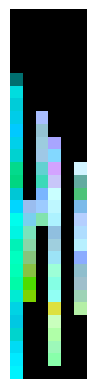

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


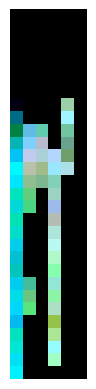

Epoch [176/300], Batch 0/64, Discriminator Loss: 0.6296, Generator Loss: 0.9222
tensor([[1.0362],
        [0.4048],
        [0.1239]], requires_grad=True)
tensor([[ 0.0038],
        [-0.0261],
        [ 0.7217]], requires_grad=True)
mean disc rating of real images: tensor(0.1495)
mean disc rating of fake images: tensor(-0.4424)
Epoch: 178 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


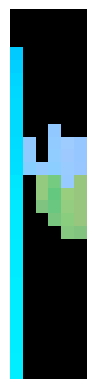

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


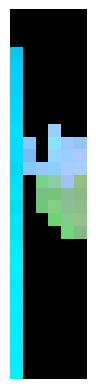

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


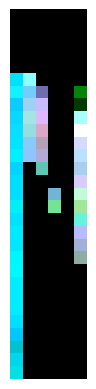

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


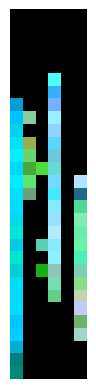

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


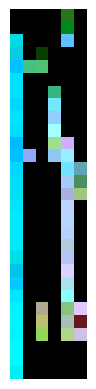

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


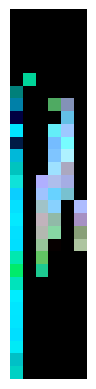

Epoch [177/300], Batch 0/64, Discriminator Loss: 0.5976, Generator Loss: 1.1972
tensor([[0.8358],
        [1.2604],
        [0.6142]], requires_grad=True)
tensor([[ 0.3521],
        [-0.8522],
        [ 0.5070]], requires_grad=True)
mean disc rating of real images: tensor(0.7291)
mean disc rating of fake images: tensor(0.0093)
Epoch: 179 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


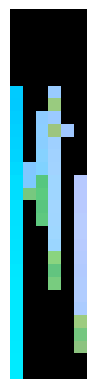

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


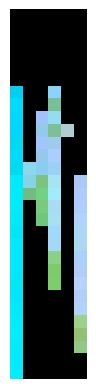

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


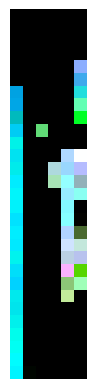

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


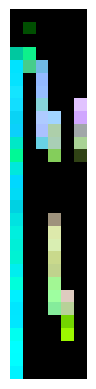

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


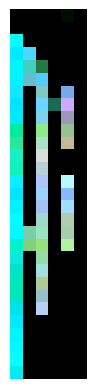

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


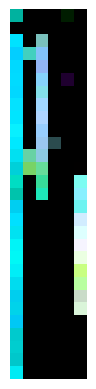

Epoch [178/300], Batch 0/64, Discriminator Loss: 0.5830, Generator Loss: 1.1201
tensor([[1.1358],
        [0.6657],
        [2.5839]], requires_grad=True)
tensor([[0.1738],
        [0.2275],
        [0.1216]], requires_grad=True)
mean disc rating of real images: tensor(0.5152)
mean disc rating of fake images: tensor(-0.2932)
Epoch: 180 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


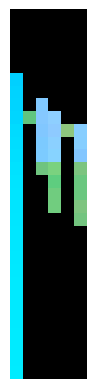

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


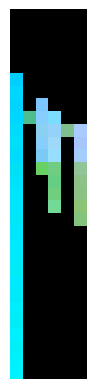

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


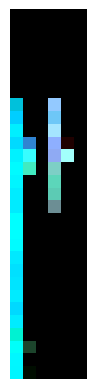

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


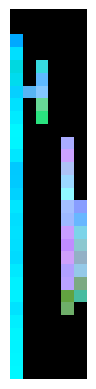

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


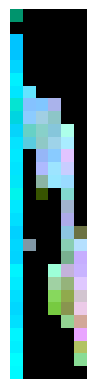

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


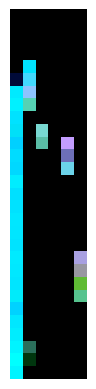

Epoch [179/300], Batch 0/64, Discriminator Loss: 0.5998, Generator Loss: 1.1143
tensor([[8.2398e-01],
        [1.1117e+00],
        [2.8336e-05]], requires_grad=True)
tensor([[-1.3965],
        [-0.7587],
        [ 0.1423]], requires_grad=True)
mean disc rating of real images: tensor(0.4798)
mean disc rating of fake images: tensor(-0.1891)
Epoch: 181 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


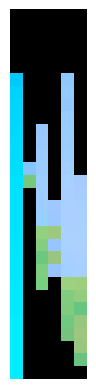

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


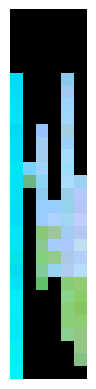

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


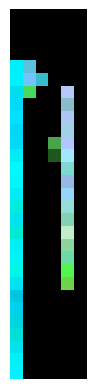

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


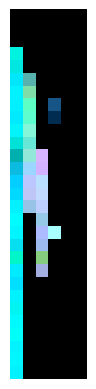

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


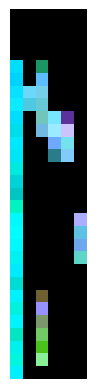

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


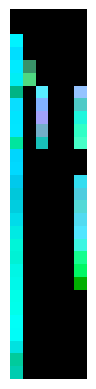

Epoch [180/300], Batch 0/64, Discriminator Loss: 0.6047, Generator Loss: 1.2854
tensor([[0.1041],
        [0.2049],
        [1.0019]], requires_grad=True)
tensor([[-0.3764],
        [ 0.1873],
        [-1.3552]], requires_grad=True)
mean disc rating of real images: tensor(0.4855)
mean disc rating of fake images: tensor(-0.1873)
Epoch: 182 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


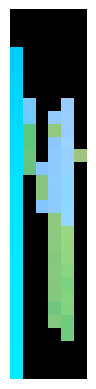

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


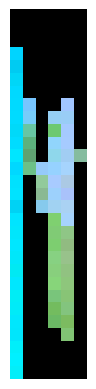

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


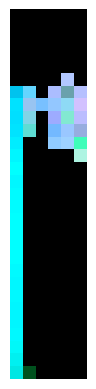

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


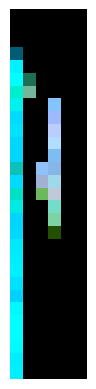

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


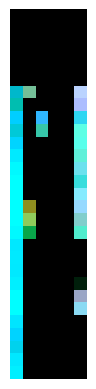

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


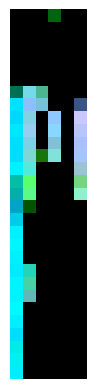

Epoch [181/300], Batch 0/64, Discriminator Loss: 0.6285, Generator Loss: 1.2166
tensor([[ 0.3202],
        [-0.7112],
        [ 0.4089]], requires_grad=True)
tensor([[-0.5117],
        [-0.6601],
        [-0.2548]], requires_grad=True)
mean disc rating of real images: tensor(0.6933)
mean disc rating of fake images: tensor(0.0767)
Epoch: 183 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


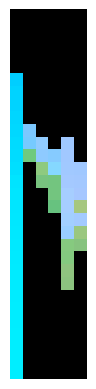

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


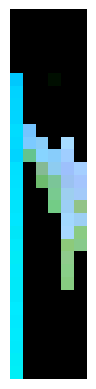

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


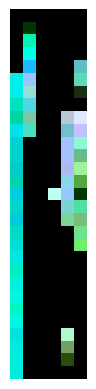

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


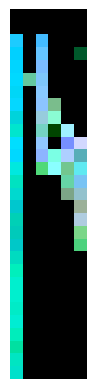

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


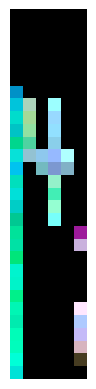

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


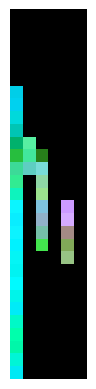

Epoch [182/300], Batch 0/64, Discriminator Loss: 0.5687, Generator Loss: 1.2543
tensor([[-0.2573],
        [ 0.2659],
        [-0.7289]], requires_grad=True)
tensor([[-1.1074],
        [-0.1883],
        [ 0.0472]], requires_grad=True)
mean disc rating of real images: tensor(0.7618)
mean disc rating of fake images: tensor(-0.1170)
Epoch: 184 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.36s/it]

real image:


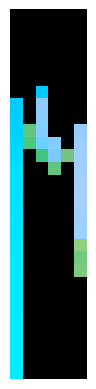

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


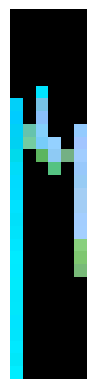

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


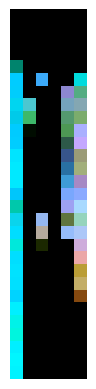

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


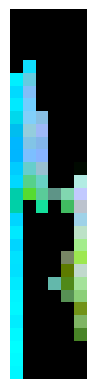

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


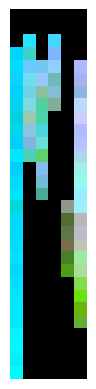

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


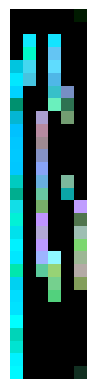

Epoch [183/300], Batch 0/64, Discriminator Loss: 0.5865, Generator Loss: 1.3710
tensor([[1.1762],
        [1.4273],
        [1.1703]], requires_grad=True)
tensor([[ 0.1322],
        [ 0.6353],
        [-1.2986]], requires_grad=True)
mean disc rating of real images: tensor(1.0655)
mean disc rating of fake images: tensor(0.1266)
Epoch: 185 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


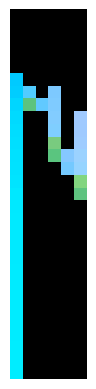

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


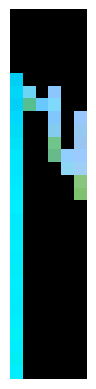

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


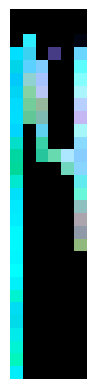

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


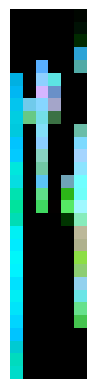

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


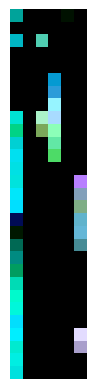

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


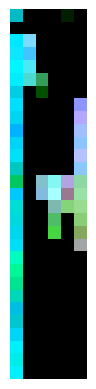

Epoch [184/300], Batch 0/64, Discriminator Loss: 0.5902, Generator Loss: 1.1843
tensor([[1.5549],
        [0.4842],
        [0.4931]], requires_grad=True)
tensor([[-0.9593],
        [-0.6563],
        [ 1.3158]], requires_grad=True)
mean disc rating of real images: tensor(0.6276)
mean disc rating of fake images: tensor(-0.1581)
Epoch: 186 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


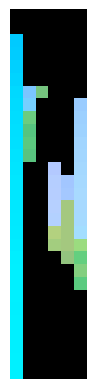

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


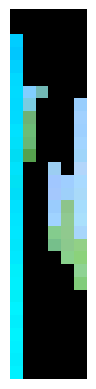

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


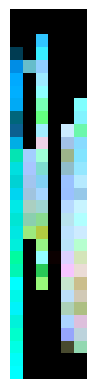

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


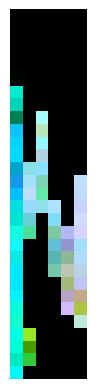

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


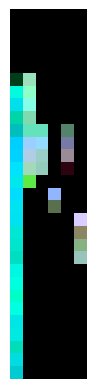

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


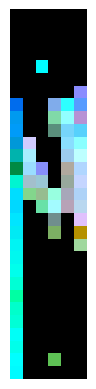

Epoch [185/300], Batch 0/64, Discriminator Loss: 0.5672, Generator Loss: 1.0295
tensor([[-1.0070],
        [-0.4410],
        [-0.7680]], requires_grad=True)
tensor([[ 0.3254],
        [-0.4469],
        [-2.4709]], requires_grad=True)
mean disc rating of real images: tensor(0.1833)
mean disc rating of fake images: tensor(-0.9521)
Epoch: 187 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


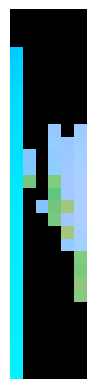

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


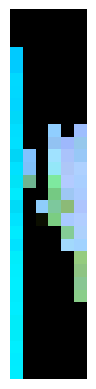

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


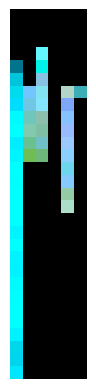

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


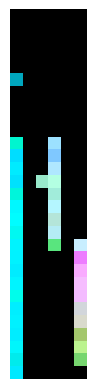

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


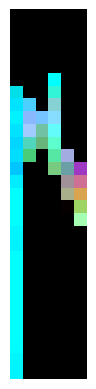

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


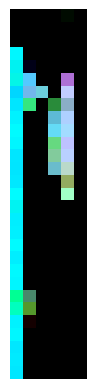

Epoch [186/300], Batch 0/64, Discriminator Loss: 0.6119, Generator Loss: 0.9999
tensor([[-0.1032],
        [ 0.1647],
        [-0.0685]], requires_grad=True)
tensor([[-0.0745],
        [ 0.8676],
        [-1.4399]], requires_grad=True)
mean disc rating of real images: tensor(-0.0056)
mean disc rating of fake images: tensor(-0.7366)
Epoch: 188 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


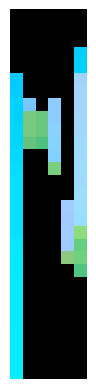

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


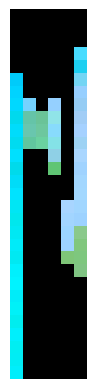

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


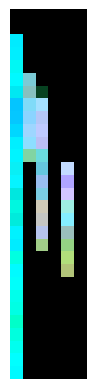

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


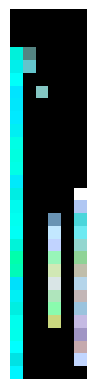

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


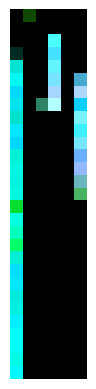

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


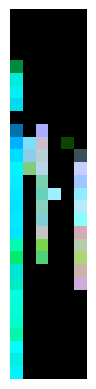

Epoch [187/300], Batch 0/64, Discriminator Loss: 0.5682, Generator Loss: 1.0540
tensor([[0.1865],
        [0.7077],
        [0.1170]], requires_grad=True)
tensor([[-1.9537],
        [-0.2728],
        [-2.0019]], requires_grad=True)
mean disc rating of real images: tensor(0.2732)
mean disc rating of fake images: tensor(-0.6535)
Epoch: 189 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


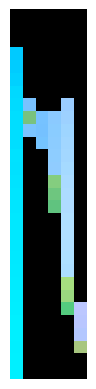

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


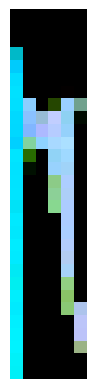

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


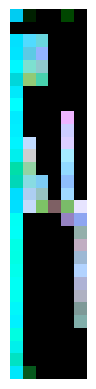

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


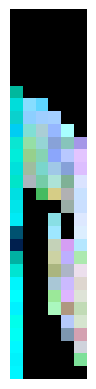

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


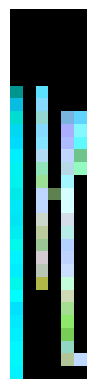

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


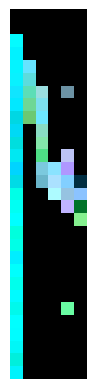

Epoch [188/300], Batch 0/64, Discriminator Loss: 0.6167, Generator Loss: 0.8678
tensor([[-0.4464],
        [-0.9509],
        [-1.2027]], requires_grad=True)
tensor([[-1.5625],
        [-1.0762],
        [-1.9685]], requires_grad=True)
mean disc rating of real images: tensor(-0.2779)
mean disc rating of fake images: tensor(-1.1270)
Epoch: 190 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


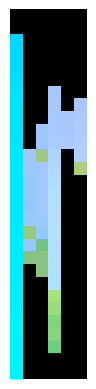

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


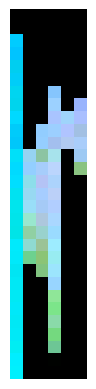

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


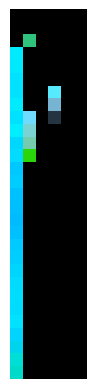

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


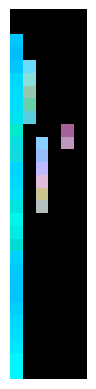

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


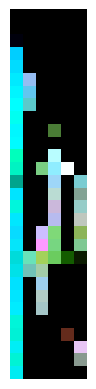

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


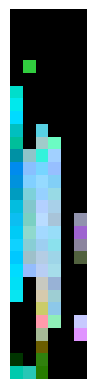

Epoch [189/300], Batch 0/64, Discriminator Loss: 0.6737, Generator Loss: 0.6073
tensor([[-0.6013],
        [ 1.2010],
        [-0.2237]], requires_grad=True)
tensor([[-0.7526],
        [ 0.6182],
        [-0.0164]], requires_grad=True)
mean disc rating of real images: tensor(-0.4768)
mean disc rating of fake images: tensor(-1.0987)
Epoch: 191 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:28<00:00,  1.38s/it]

real image:


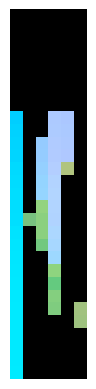

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


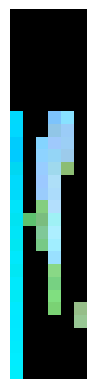

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


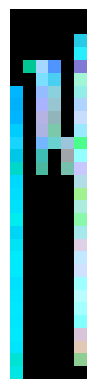

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


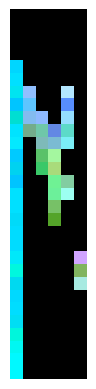

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


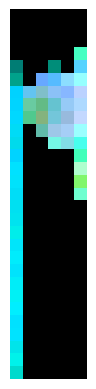

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


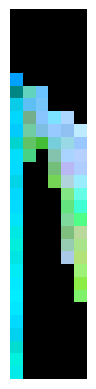

Epoch [190/300], Batch 0/64, Discriminator Loss: 0.6333, Generator Loss: 1.0184
tensor([[ 0.0616],
        [-1.1358],
        [ 0.7526]], requires_grad=True)
tensor([[-0.4717],
        [-1.1956],
        [-0.0412]], requires_grad=True)
mean disc rating of real images: tensor(-0.0622)
mean disc rating of fake images: tensor(-0.7921)
Epoch: 192 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


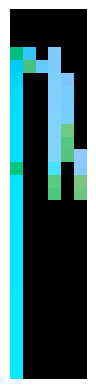

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


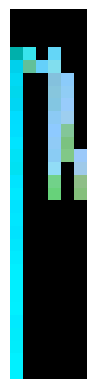

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


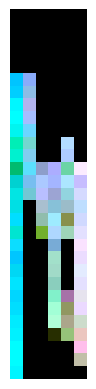

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


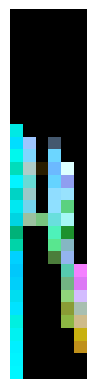

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


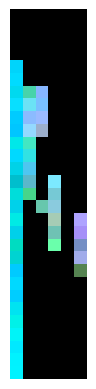

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


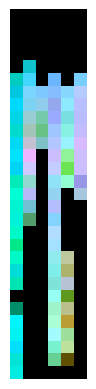

Epoch [191/300], Batch 0/64, Discriminator Loss: 0.5983, Generator Loss: 1.1017
tensor([[ 0.3722],
        [-0.5992],
        [ 3.1798]], requires_grad=True)
tensor([[-0.8284],
        [-0.0266],
        [ 0.6031]], requires_grad=True)
mean disc rating of real images: tensor(0.5897)
mean disc rating of fake images: tensor(-0.1994)
Epoch: 193 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


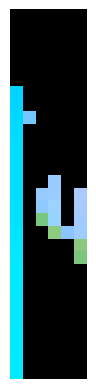

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


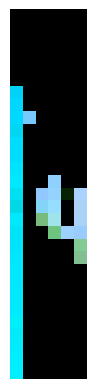

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


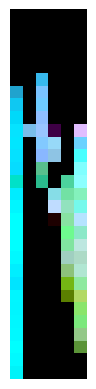

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


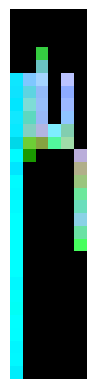

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


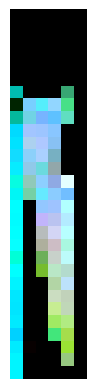

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


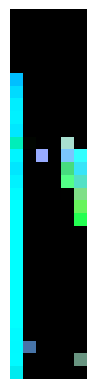

Epoch [192/300], Batch 0/64, Discriminator Loss: 0.5792, Generator Loss: 1.0264
tensor([[-0.6973],
        [ 0.5904],
        [-0.2703]], requires_grad=True)
tensor([[-0.0074],
        [ 0.3758],
        [-1.7382]], requires_grad=True)
mean disc rating of real images: tensor(0.0509)
mean disc rating of fake images: tensor(-0.9084)
Epoch: 194 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


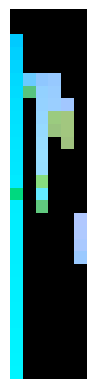

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


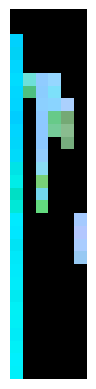

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


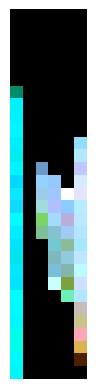

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


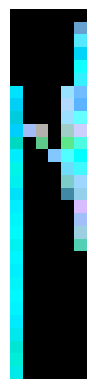

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


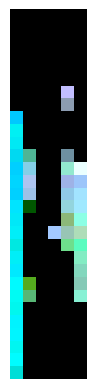

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


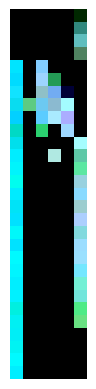

Epoch [193/300], Batch 0/64, Discriminator Loss: 0.6038, Generator Loss: 1.2782
tensor([[ 0.3488],
        [-0.0803],
        [ 2.5173]], requires_grad=True)
tensor([[-0.1552],
        [ 0.4689],
        [ 0.4879]], requires_grad=True)
mean disc rating of real images: tensor(0.8678)
mean disc rating of fake images: tensor(0.0197)
Epoch: 195 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


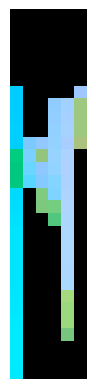

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


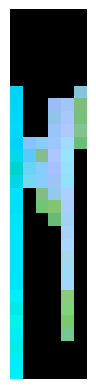

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


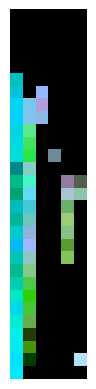

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


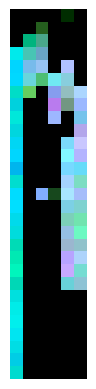

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


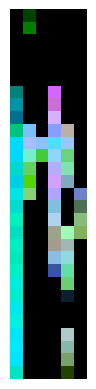

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


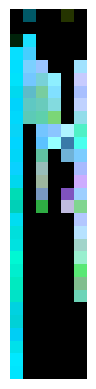

Epoch [194/300], Batch 0/64, Discriminator Loss: 0.5973, Generator Loss: 0.9063
tensor([[ 0.0563],
        [-0.9022],
        [-0.8802]], requires_grad=True)
tensor([[-0.1072],
        [-0.7621],
        [-0.3444]], requires_grad=True)
mean disc rating of real images: tensor(-0.0836)
mean disc rating of fake images: tensor(-1.0253)
Epoch: 196 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


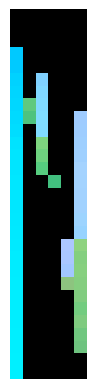

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


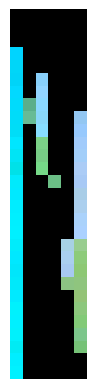

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


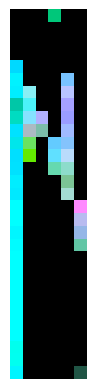

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


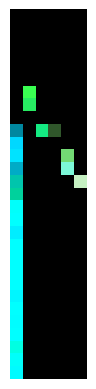

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


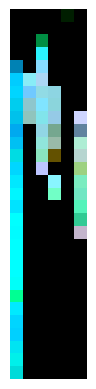

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


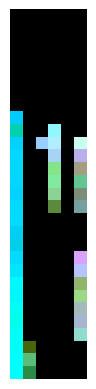

Epoch [195/300], Batch 0/64, Discriminator Loss: 0.6991, Generator Loss: 1.9277
tensor([[1.7124],
        [0.4719],
        [1.5916]], requires_grad=True)
tensor([[0.7630],
        [1.3408],
        [0.9653]], requires_grad=True)
mean disc rating of real images: tensor(1.7194)
mean disc rating of fake images: tensor(0.6592)
Epoch: 197 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


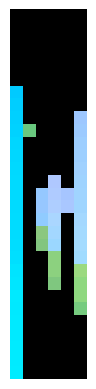

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


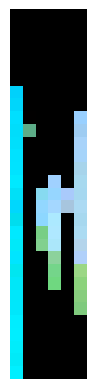

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


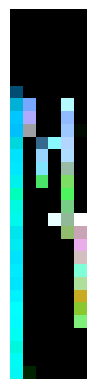

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


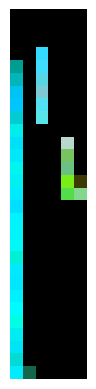

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


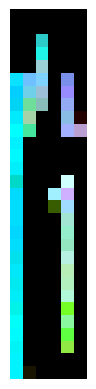

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


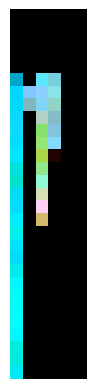

Epoch [196/300], Batch 0/64, Discriminator Loss: 0.5543, Generator Loss: 1.1484
tensor([[ 0.4693],
        [-0.2260],
        [ 0.6199]], requires_grad=True)
tensor([[-0.3224],
        [-0.5103],
        [-1.0564]], requires_grad=True)
mean disc rating of real images: tensor(0.3822)
mean disc rating of fake images: tensor(-0.5628)
Epoch: 198 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


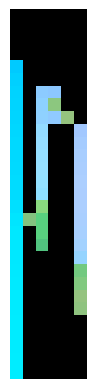

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


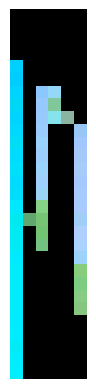

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


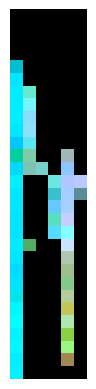

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


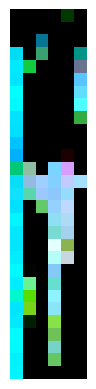

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


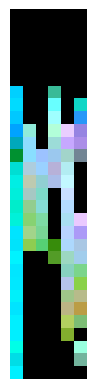

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


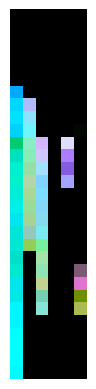

Epoch [197/300], Batch 0/64, Discriminator Loss: 0.5934, Generator Loss: 0.8600
tensor([[ 1.7499],
        [-0.3034],
        [ 1.0652]], requires_grad=True)
tensor([[-0.4905],
        [-0.8594],
        [ 0.4559]], requires_grad=True)
mean disc rating of real images: tensor(-0.0101)
mean disc rating of fake images: tensor(-0.9095)
Epoch: 199 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


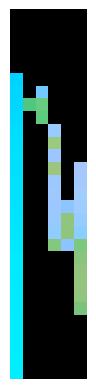

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


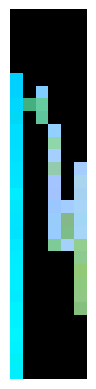

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


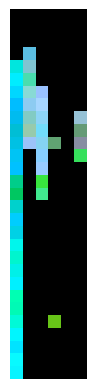

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


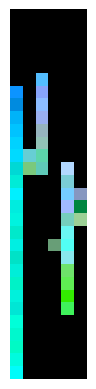

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


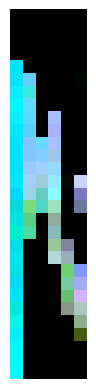

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


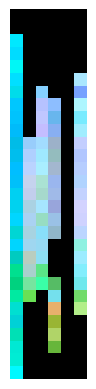

Epoch [198/300], Batch 0/64, Discriminator Loss: 0.5662, Generator Loss: 1.0208
tensor([[ 0.5846],
        [-0.3737],
        [-1.1631]], requires_grad=True)
tensor([[-0.6251],
        [-1.6892],
        [-1.8415]], requires_grad=True)
mean disc rating of real images: tensor(0.2170)
mean disc rating of fake images: tensor(-0.7136)
Epoch: 200 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


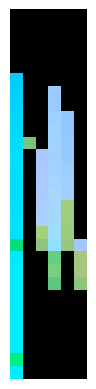

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


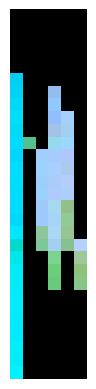

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


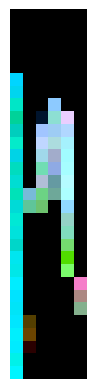

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


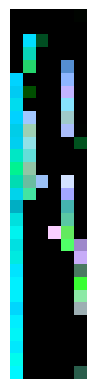

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


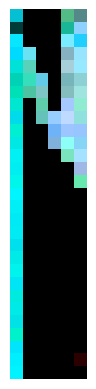

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


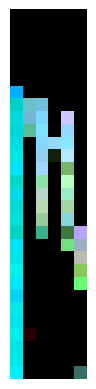

Epoch [199/300], Batch 0/64, Discriminator Loss: 0.5829, Generator Loss: 1.2176
tensor([[ 0.8777],
        [-0.2074],
        [ 1.6105]], requires_grad=True)
tensor([[-0.4119],
        [ 0.6340],
        [-6.4564]], requires_grad=True)
mean disc rating of real images: tensor(0.4960)
mean disc rating of fake images: tensor(-0.3933)
Epoch: 201 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


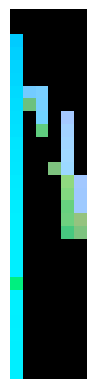

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


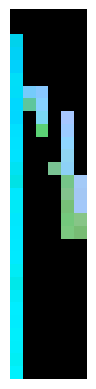

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


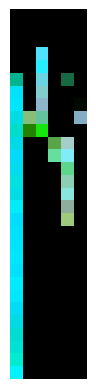

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


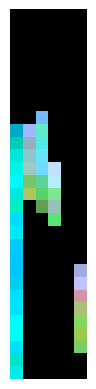

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


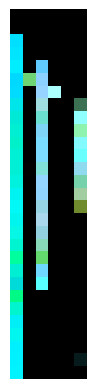

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


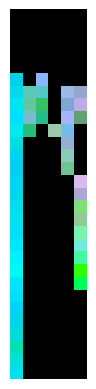

Epoch [200/300], Batch 0/64, Discriminator Loss: 0.6476, Generator Loss: 1.2395
tensor([[0.2707],
        [0.6317],
        [1.1250]], requires_grad=True)
tensor([[-0.3008],
        [ 1.1432],
        [ 0.3870]], requires_grad=True)
mean disc rating of real images: tensor(0.7063)
mean disc rating of fake images: tensor(0.0778)
Epoch: 202 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


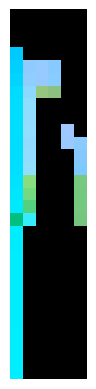

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


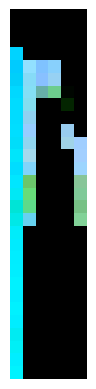

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


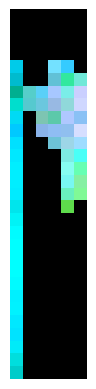

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


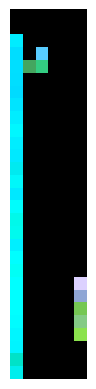

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


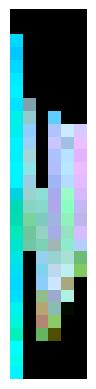

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


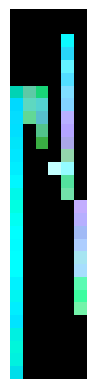

Epoch [201/300], Batch 0/64, Discriminator Loss: 0.5716, Generator Loss: 1.1133
tensor([[1.4411],
        [0.2417],
        [1.3595]], requires_grad=True)
tensor([[0.9965],
        [0.8267],
        [0.2991]], requires_grad=True)
mean disc rating of real images: tensor(0.4011)
mean disc rating of fake images: tensor(-0.4892)
Epoch: 203 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


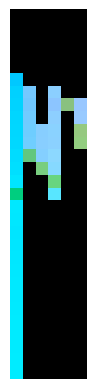

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


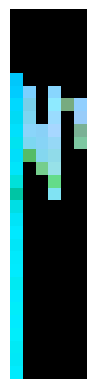

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


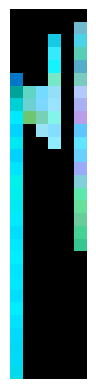

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


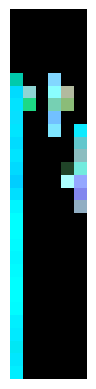

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


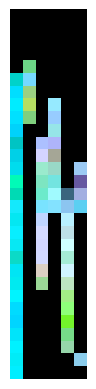

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


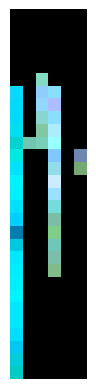

Epoch [202/300], Batch 0/64, Discriminator Loss: 0.5802, Generator Loss: 1.5086
tensor([[-0.0713],
        [ 0.6396],
        [ 1.1624]], requires_grad=True)
tensor([[-1.1627],
        [ 0.3809],
        [ 1.3460]], requires_grad=True)
mean disc rating of real images: tensor(0.7959)
mean disc rating of fake images: tensor(-0.2327)
Epoch: 204 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


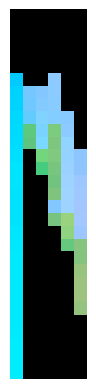

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


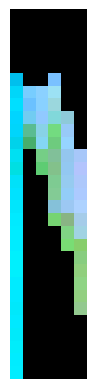

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


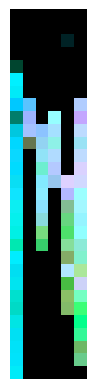

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


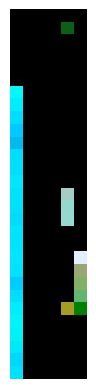

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


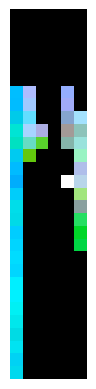

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


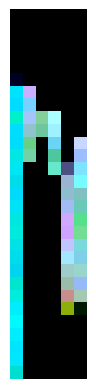

Epoch [203/300], Batch 0/64, Discriminator Loss: 0.5931, Generator Loss: 1.2199
tensor([[ 0.2569],
        [ 0.3299],
        [-0.3428]], requires_grad=True)
tensor([[-0.4541],
        [-0.5812],
        [-0.5234]], requires_grad=True)
mean disc rating of real images: tensor(0.7159)
mean disc rating of fake images: tensor(-0.1087)
Epoch: 205 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


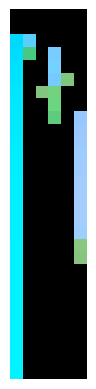

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


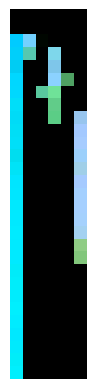

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


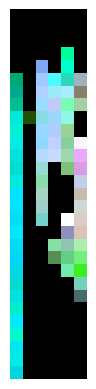

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


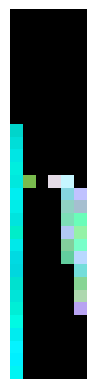

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


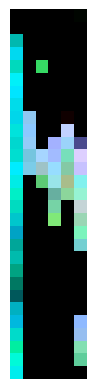

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


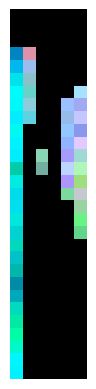

Epoch [204/300], Batch 0/64, Discriminator Loss: 0.5897, Generator Loss: 0.8380
tensor([[ 0.3220],
        [-0.5496],
        [-0.4469]], requires_grad=True)
tensor([[-0.9635],
        [-0.8786],
        [-1.8987]], requires_grad=True)
mean disc rating of real images: tensor(0.1484)
mean disc rating of fake images: tensor(-0.6777)
Epoch: 206 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


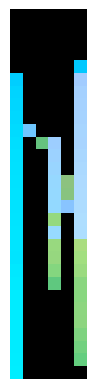

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


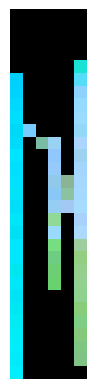

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


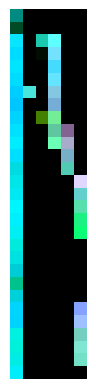

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


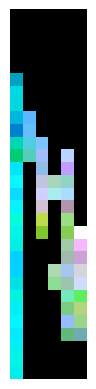

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


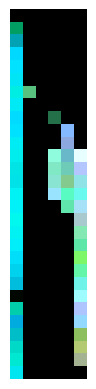

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


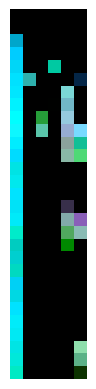

Epoch [205/300], Batch 0/64, Discriminator Loss: 0.5812, Generator Loss: 0.9943
tensor([[-1.0515],
        [ 0.1716],
        [ 0.8939]], requires_grad=True)
tensor([[-1.2422],
        [-1.0190],
        [-1.2377]], requires_grad=True)
mean disc rating of real images: tensor(-0.0499)
mean disc rating of fake images: tensor(-1.1704)
Epoch: 207 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


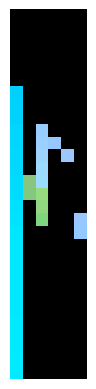

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


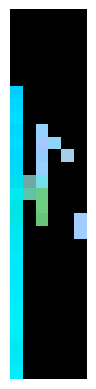

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


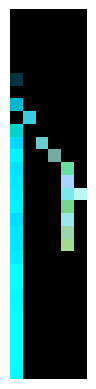

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


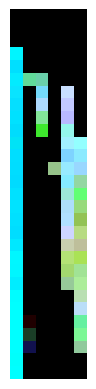

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


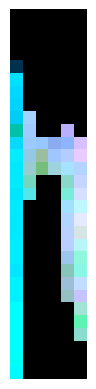

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


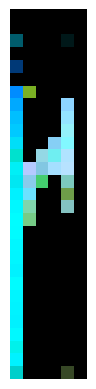

Epoch [206/300], Batch 0/64, Discriminator Loss: 0.5524, Generator Loss: 0.9987
tensor([[ 0.6443],
        [-0.3346],
        [-0.5526]], requires_grad=True)
tensor([[-1.7411],
        [-1.7064],
        [-3.8105]], requires_grad=True)
mean disc rating of real images: tensor(0.2027)
mean disc rating of fake images: tensor(-0.8734)
Epoch: 208 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


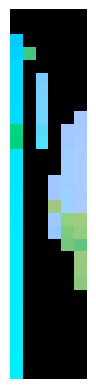

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


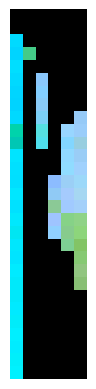

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


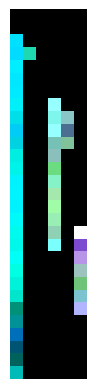

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


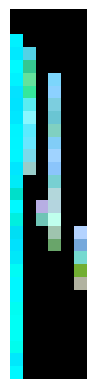

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


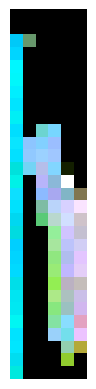

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


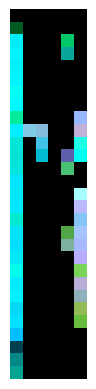

Epoch [207/300], Batch 0/64, Discriminator Loss: 0.5611, Generator Loss: 1.4391
tensor([[ 1.1756],
        [-0.0780],
        [-0.0141]], requires_grad=True)
tensor([[-0.4045],
        [ 0.4841],
        [-0.1354]], requires_grad=True)
mean disc rating of real images: tensor(0.9604)
mean disc rating of fake images: tensor(-0.0976)
Epoch: 209 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


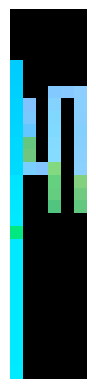

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


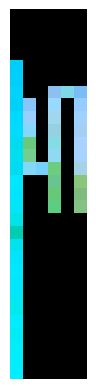

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


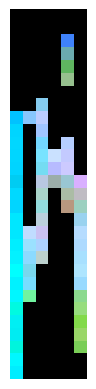

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


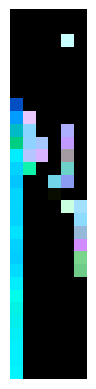

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


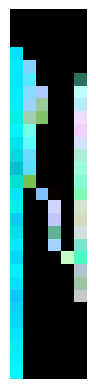

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


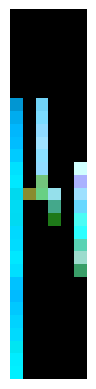

Epoch [208/300], Batch 0/64, Discriminator Loss: 0.6327, Generator Loss: 0.9660
tensor([[-0.2080],
        [-0.0464],
        [ 1.2778]], requires_grad=True)
tensor([[ 0.0369],
        [-0.4389],
        [-0.3536]], requires_grad=True)
mean disc rating of real images: tensor(-0.1603)
mean disc rating of fake images: tensor(-1.1024)
Epoch: 210 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


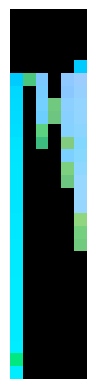

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


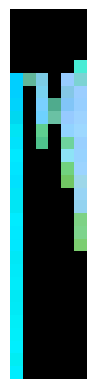

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


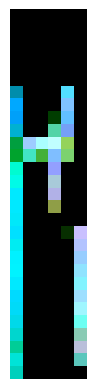

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


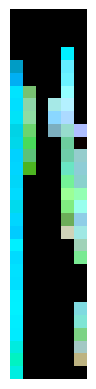

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


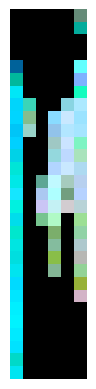

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


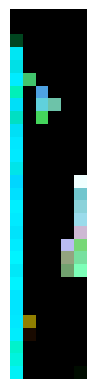

Epoch [209/300], Batch 0/64, Discriminator Loss: 0.5139, Generator Loss: 1.1439
tensor([[ 0.7476],
        [-0.3712],
        [ 1.8749]], requires_grad=True)
tensor([[ 0.1750],
        [-0.4908],
        [-0.8963]], requires_grad=True)
mean disc rating of real images: tensor(0.5683)
mean disc rating of fake images: tensor(-0.7425)
Epoch: 211 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


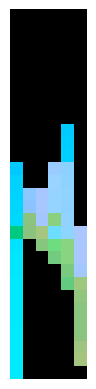

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


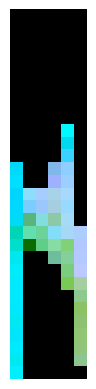

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


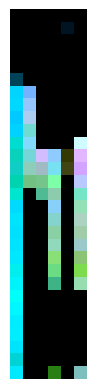

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


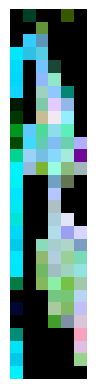

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


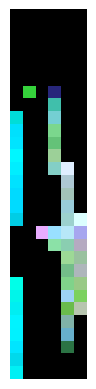

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


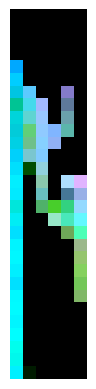

Epoch [210/300], Batch 0/64, Discriminator Loss: 0.5755, Generator Loss: 1.0960
tensor([[ 0.0390],
        [-0.8831],
        [ 1.7716]], requires_grad=True)
tensor([[-0.9074],
        [-0.1175],
        [-1.0065]], requires_grad=True)
mean disc rating of real images: tensor(0.2739)
mean disc rating of fake images: tensor(-0.7669)
Epoch: 212 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


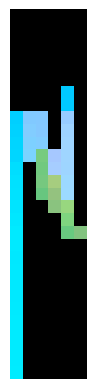

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


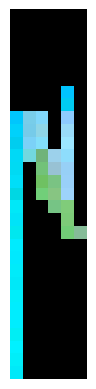

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


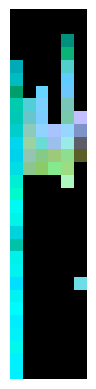

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


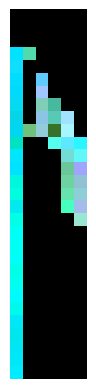

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


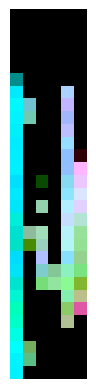

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


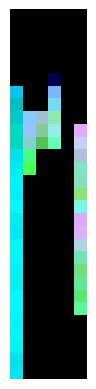

Epoch [211/300], Batch 0/64, Discriminator Loss: 0.5494, Generator Loss: 1.0068
tensor([[-0.5252],
        [-0.2499],
        [-0.1015]], requires_grad=True)
tensor([[-7.4343],
        [-1.9907],
        [-0.9622]], requires_grad=True)
mean disc rating of real images: tensor(0.1702)
mean disc rating of fake images: tensor(-1.1432)
Epoch: 213 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


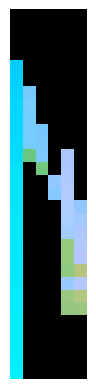

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


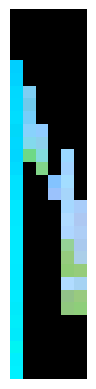

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


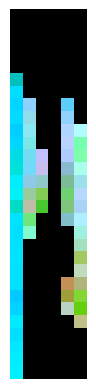

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


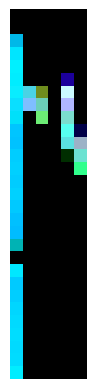

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


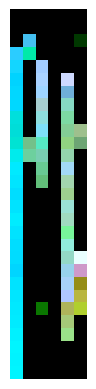

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


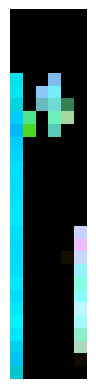

Epoch [212/300], Batch 0/64, Discriminator Loss: 0.5774, Generator Loss: 1.0524
tensor([[ 0.7976],
        [ 1.0584],
        [-0.3744]], requires_grad=True)
tensor([[-1.0723],
        [-1.1913],
        [ 0.1849]], requires_grad=True)
mean disc rating of real images: tensor(0.3533)
mean disc rating of fake images: tensor(-0.6539)
Epoch: 214 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


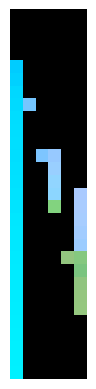

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


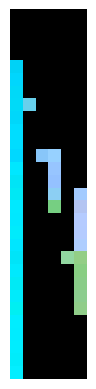

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


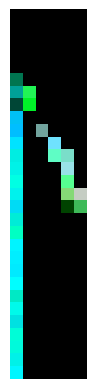

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


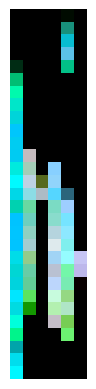

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


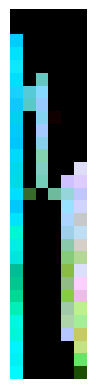

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


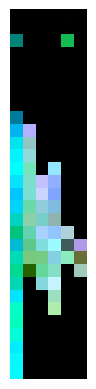

Epoch [213/300], Batch 0/64, Discriminator Loss: 0.5686, Generator Loss: 1.0628
tensor([[0.1473],
        [0.5697],
        [1.3799]], requires_grad=True)
tensor([[ 0.1119],
        [-0.7145],
        [ 0.0474]], requires_grad=True)
mean disc rating of real images: tensor(0.2531)
mean disc rating of fake images: tensor(-0.7245)
Epoch: 215 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


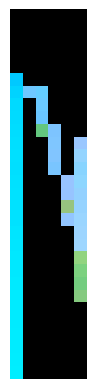

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


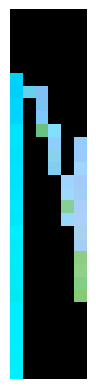

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


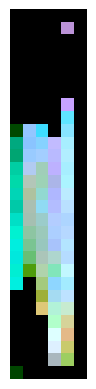

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


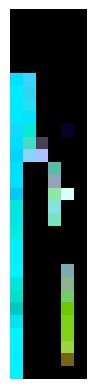

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


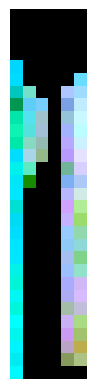

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


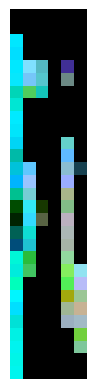

Epoch [214/300], Batch 0/64, Discriminator Loss: 0.5282, Generator Loss: 1.2939
tensor([[0.7836],
        [0.1918],
        [0.7086]], requires_grad=True)
tensor([[-0.8871],
        [ 0.0664],
        [-2.0939]], requires_grad=True)
mean disc rating of real images: tensor(0.5170)
mean disc rating of fake images: tensor(-0.7037)
Epoch: 216 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


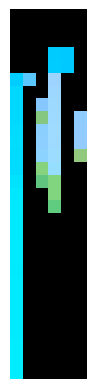

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


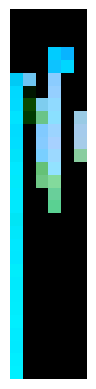

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


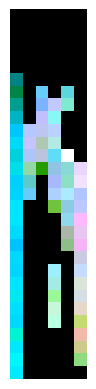

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


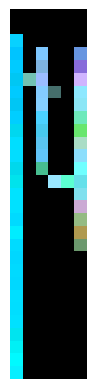

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


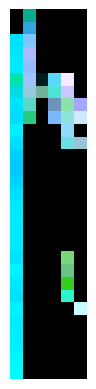

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


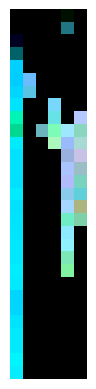

Epoch [215/300], Batch 0/64, Discriminator Loss: 0.5932, Generator Loss: 1.6334
tensor([[1.3964],
        [0.4121],
        [2.0738]], requires_grad=True)
tensor([[-1.9076e-03],
        [ 1.7865e-02],
        [ 2.5163e+00]], requires_grad=True)
mean disc rating of real images: tensor(1.4602)
mean disc rating of fake images: tensor(0.1603)
Epoch: 217 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


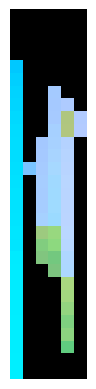

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


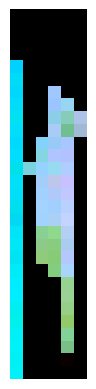

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


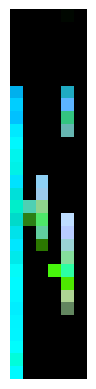

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


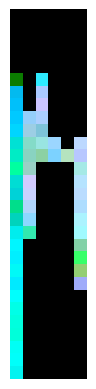

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


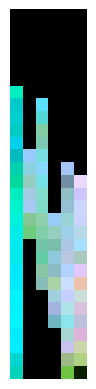

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


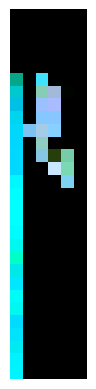

Epoch [216/300], Batch 0/64, Discriminator Loss: 0.5540, Generator Loss: 1.1078
tensor([[ 0.4302],
        [-0.2146],
        [ 0.6212]], requires_grad=True)
tensor([[ 0.1196],
        [-0.9147],
        [-0.5885]], requires_grad=True)
mean disc rating of real images: tensor(0.3516)
mean disc rating of fake images: tensor(-0.6919)
Epoch: 218 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


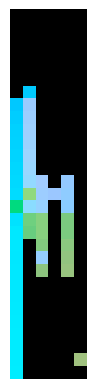

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


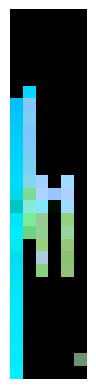

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


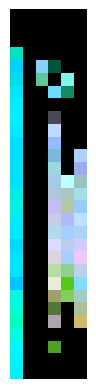

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


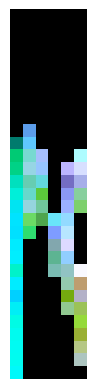

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


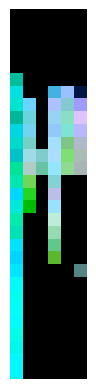

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


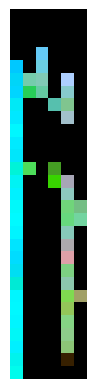

Epoch [217/300], Batch 0/64, Discriminator Loss: 0.5724, Generator Loss: 1.4592
tensor([[ 1.8909],
        [ 0.8900],
        [-0.0655]], requires_grad=True)
tensor([[-0.3744],
        [ 0.6463],
        [ 0.1880]], requires_grad=True)
mean disc rating of real images: tensor(1.0413)
mean disc rating of fake images: tensor(-0.0056)
Epoch: 219 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


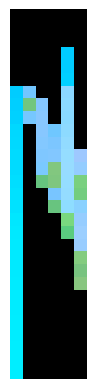

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


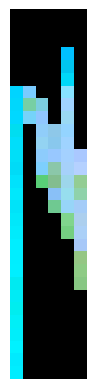

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


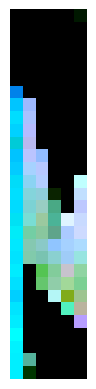

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


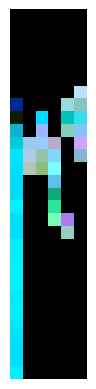

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


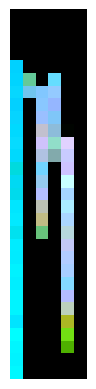

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


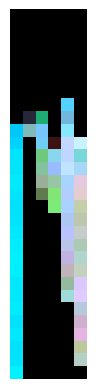

Epoch [218/300], Batch 0/64, Discriminator Loss: 0.6030, Generator Loss: 1.2916
tensor([[0.0334],
        [1.2642],
        [0.2549]], requires_grad=True)
tensor([[ 1.0804],
        [-0.5260],
        [ 1.9670]], requires_grad=True)
mean disc rating of real images: tensor(0.6654)
mean disc rating of fake images: tensor(-0.2314)
Epoch: 220 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


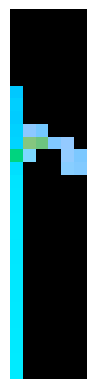

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


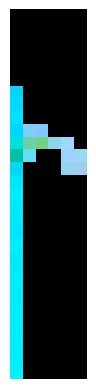

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


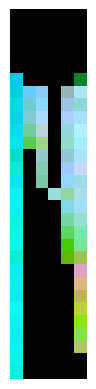

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


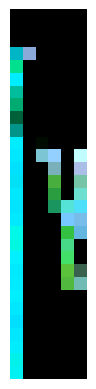

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


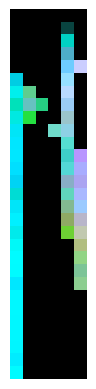

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


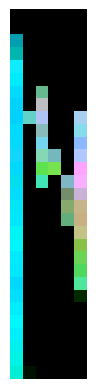

Epoch [219/300], Batch 0/64, Discriminator Loss: 0.5567, Generator Loss: 0.9633
tensor([[-0.1568],
        [ 0.3501],
        [-1.4846]], requires_grad=True)
tensor([[-0.4963],
        [-0.2435],
        [-1.6541]], requires_grad=True)
mean disc rating of real images: tensor(0.1744)
mean disc rating of fake images: tensor(-0.9683)
Epoch: 221 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


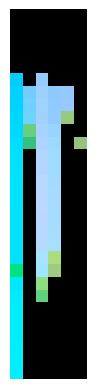

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


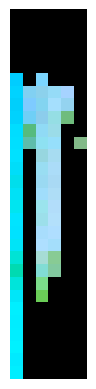

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


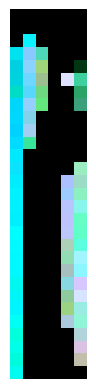

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


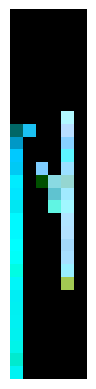

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


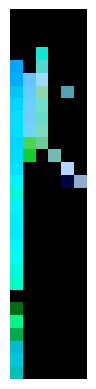

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


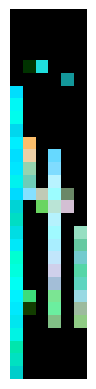

Epoch [220/300], Batch 0/64, Discriminator Loss: 0.5283, Generator Loss: 1.3850
tensor([[-1.5238],
        [ 0.4530],
        [-0.3783]], requires_grad=True)
tensor([[-1.2851],
        [-5.2950],
        [ 0.8049]], requires_grad=True)
mean disc rating of real images: tensor(0.4106)
mean disc rating of fake images: tensor(-0.8747)
Epoch: 222 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:37<00:00,  1.53s/it]

real image:


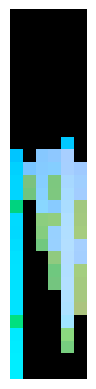

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


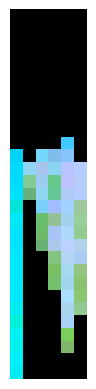

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


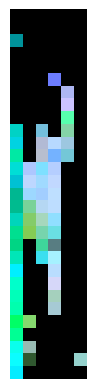

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


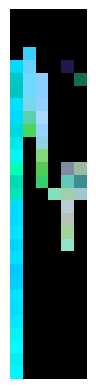

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


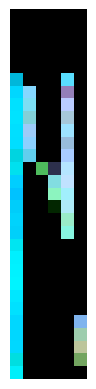

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


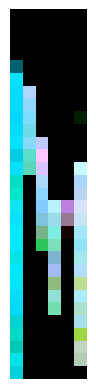

Epoch [221/300], Batch 0/64, Discriminator Loss: 0.5562, Generator Loss: 1.2255
tensor([[0.0911],
        [0.3483],
        [0.2175]], requires_grad=True)
tensor([[-4.9852],
        [ 1.1752],
        [-0.3964]], requires_grad=True)
mean disc rating of real images: tensor(0.5630)
mean disc rating of fake images: tensor(-0.5155)
Epoch: 223 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:42<00:00,  1.60s/it]

real image:


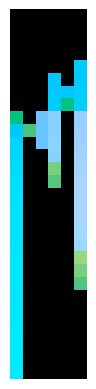

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


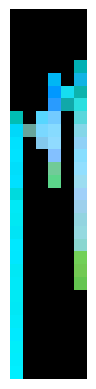

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


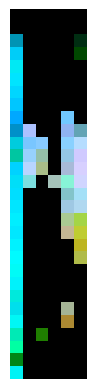

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


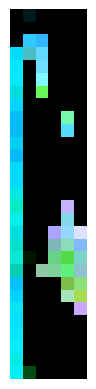

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


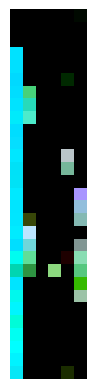

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


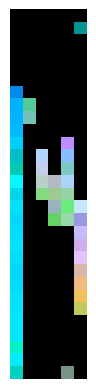

Epoch [222/300], Batch 0/64, Discriminator Loss: 0.5645, Generator Loss: 1.8207
tensor([[0.8395],
        [2.9101],
        [1.9392]], requires_grad=True)
tensor([[-1.6332],
        [ 0.0930],
        [ 0.4455]], requires_grad=True)
mean disc rating of real images: tensor(0.6055)
mean disc rating of fake images: tensor(-0.4430)
Epoch: 224 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:43<00:00,  1.62s/it]

real image:


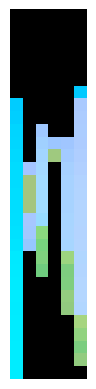

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


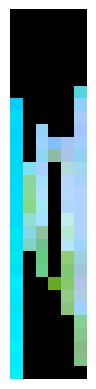

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


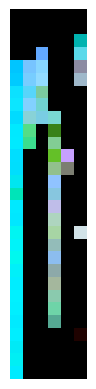

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


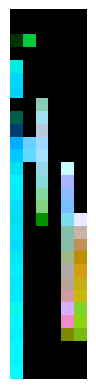

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


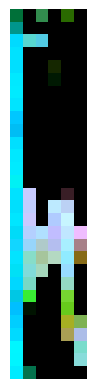

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


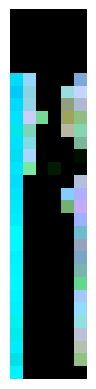

Epoch [223/300], Batch 0/64, Discriminator Loss: 0.5683, Generator Loss: 0.9947
tensor([[2.3263],
        [0.1125],
        [0.8147]], requires_grad=True)
tensor([[-2.8987],
        [-1.1704],
        [ 0.5330]], requires_grad=True)
mean disc rating of real images: tensor(-0.1642)
mean disc rating of fake images: tensor(-1.6422)
Epoch: 225 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:42<00:00,  1.61s/it]

real image:


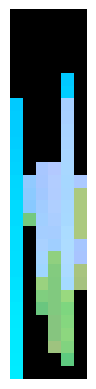

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


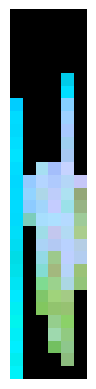

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


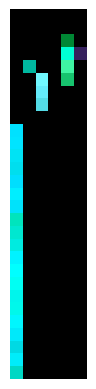

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


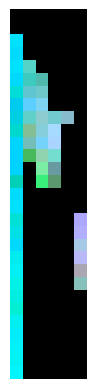

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


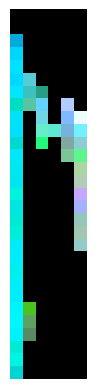

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


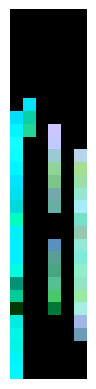

Epoch [224/300], Batch 0/64, Discriminator Loss: 0.5640, Generator Loss: 1.6231
tensor([[ 1.0316],
        [-0.2272],
        [ 0.8686]], requires_grad=True)
tensor([[-0.3088],
        [ 1.0968],
        [-0.4267]], requires_grad=True)
mean disc rating of real images: tensor(0.9926)
mean disc rating of fake images: tensor(-0.0985)
Epoch: 226 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:42<00:00,  1.60s/it]

real image:


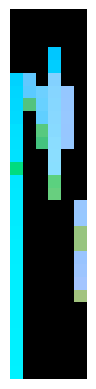

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


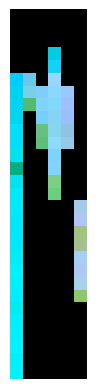

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


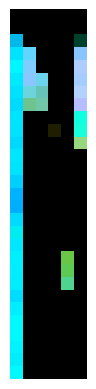

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


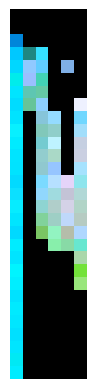

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


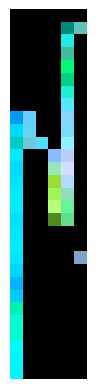

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


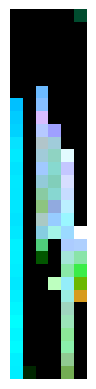

Epoch [225/300], Batch 0/64, Discriminator Loss: 0.5102, Generator Loss: 1.0787
tensor([[-1.0301],
        [ 0.8173],
        [ 0.4746]], requires_grad=True)
tensor([[-0.7689],
        [ 0.3705],
        [ 1.3987]], requires_grad=True)
mean disc rating of real images: tensor(0.3918)
mean disc rating of fake images: tensor(-0.9994)
Epoch: 227 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:42<00:00,  1.60s/it]

real image:


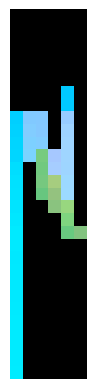

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


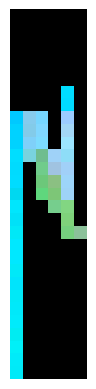

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


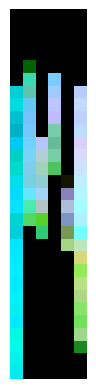

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


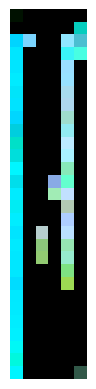

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


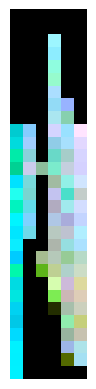

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


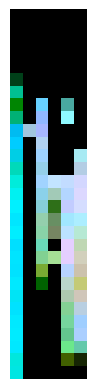

Epoch [226/300], Batch 0/64, Discriminator Loss: 0.5988, Generator Loss: 1.0778
tensor([[-0.3155],
        [-0.4836],
        [-0.5619]], requires_grad=True)
tensor([[-0.8124],
        [ 0.8105],
        [-0.8726]], requires_grad=True)
mean disc rating of real images: tensor(0.2488)
mean disc rating of fake images: tensor(-0.5692)
Epoch: 228 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:42<00:00,  1.60s/it]

real image:


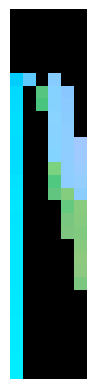

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


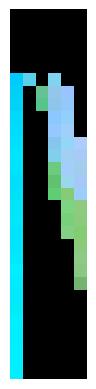

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


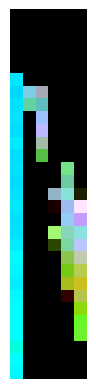

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


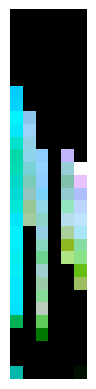

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


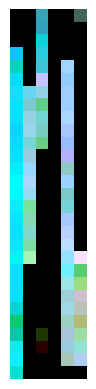

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


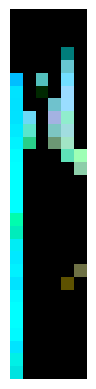

Epoch [227/300], Batch 0/64, Discriminator Loss: 0.5633, Generator Loss: 1.7071
tensor([[1.6227],
        [0.3805],
        [1.0391]], requires_grad=True)
tensor([[-1.5118],
        [ 0.1698],
        [-1.6158]], requires_grad=True)
mean disc rating of real images: tensor(1.0681)
mean disc rating of fake images: tensor(-0.1400)
Epoch: 229 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:41<00:00,  1.59s/it]

real image:


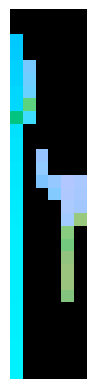

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


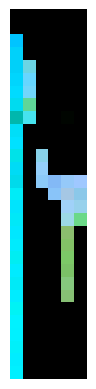

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


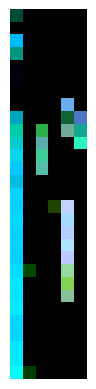

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


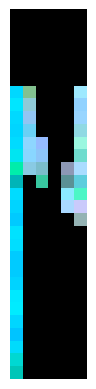

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


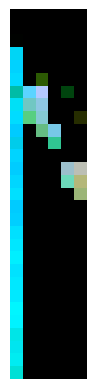

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


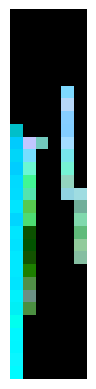

Epoch [228/300], Batch 0/64, Discriminator Loss: 0.6456, Generator Loss: 1.9292
tensor([[1.5090],
        [1.8190],
        [1.8867]], requires_grad=True)
tensor([[0.8258],
        [0.7525],
        [1.8306]], requires_grad=True)
mean disc rating of real images: tensor(1.5801)
mean disc rating of fake images: tensor(0.4777)
Epoch: 230 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [11:47<00:00, 11.06s/it]

real image:


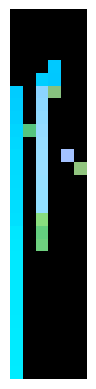

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


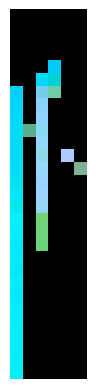

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


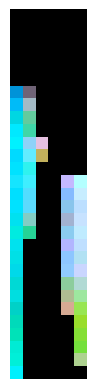

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


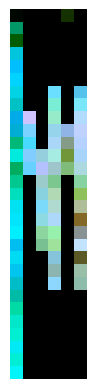

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


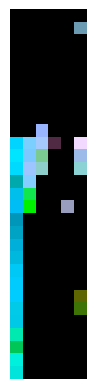

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


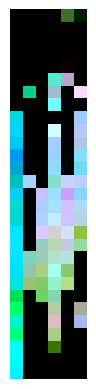

Epoch [229/300], Batch 0/64, Discriminator Loss: 0.5596, Generator Loss: 1.5271
tensor([[1.7757],
        [1.4845],
        [3.0822]], requires_grad=True)
tensor([[-0.0361],
        [-0.7819],
        [ 0.0519]], requires_grad=True)
mean disc rating of real images: tensor(1.1483)
mean disc rating of fake images: tensor(-0.1365)
Epoch: 231 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:41<00:00,  1.59s/it]

real image:


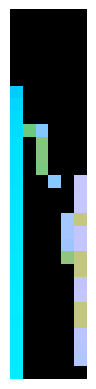

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


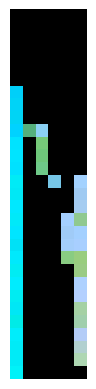

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


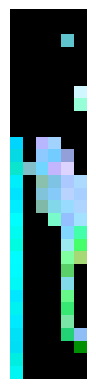

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


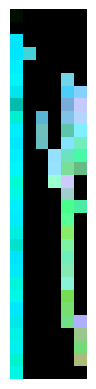

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


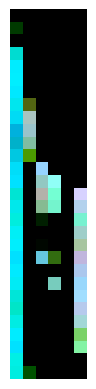

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


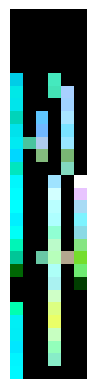

Epoch [230/300], Batch 0/64, Discriminator Loss: 0.5414, Generator Loss: 1.0860
tensor([[ 1.0344],
        [ 0.9098],
        [-0.1706]], requires_grad=True)
tensor([[-0.5164],
        [-0.3940],
        [ 0.3870]], requires_grad=True)
mean disc rating of real images: tensor(0.4372)
mean disc rating of fake images: tensor(-0.7381)
Epoch: 232 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:41<00:00,  1.59s/it]

real image:


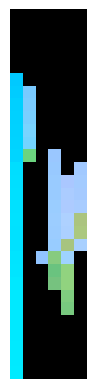

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


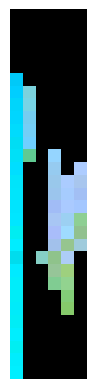

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


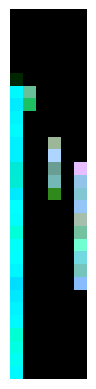

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


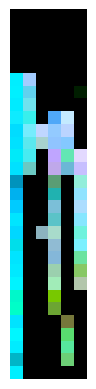

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


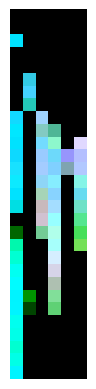

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


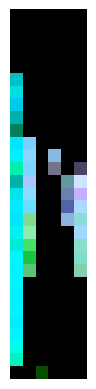

Epoch [231/300], Batch 0/64, Discriminator Loss: 0.6471, Generator Loss: 1.0233
tensor([[-1.0980],
        [ 0.9744],
        [ 1.2102]], requires_grad=True)
tensor([[-1.3982],
        [ 0.8876],
        [-0.1608]], requires_grad=True)
mean disc rating of real images: tensor(0.3600)
mean disc rating of fake images: tensor(-0.3412)
Epoch: 233 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:41<00:00,  1.59s/it]

real image:


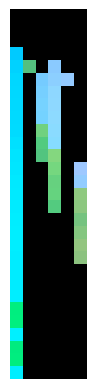

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


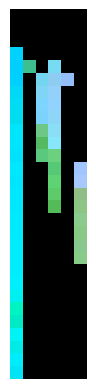

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


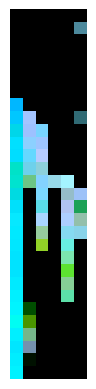

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


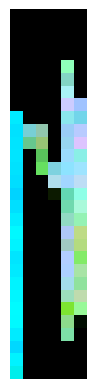

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


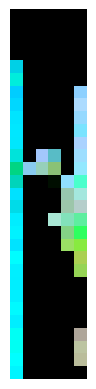

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


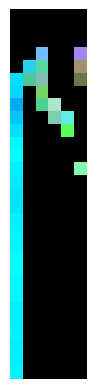

Epoch [232/300], Batch 0/64, Discriminator Loss: 0.5832, Generator Loss: 0.9691
tensor([[0.7235],
        [1.4556],
        [1.1739]], requires_grad=True)
tensor([[-1.6884],
        [-1.8297],
        [-2.5400]], requires_grad=True)
mean disc rating of real images: tensor(0.4627)
mean disc rating of fake images: tensor(-0.6315)
Epoch: 234 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:41<00:00,  1.59s/it]

real image:


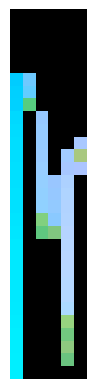

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


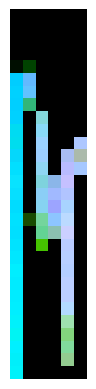

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


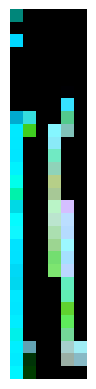

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


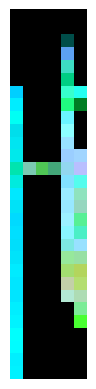

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


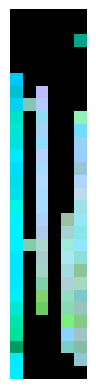

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


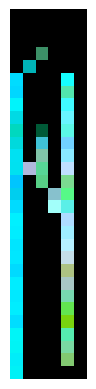

Epoch [233/300], Batch 0/64, Discriminator Loss: 0.5503, Generator Loss: 1.1263
tensor([[0.9520],
        [0.3966],
        [0.9107]], requires_grad=True)
tensor([[ 2.1833],
        [-0.6042],
        [-0.8887]], requires_grad=True)
mean disc rating of real images: tensor(0.5874)
mean disc rating of fake images: tensor(-0.6542)
Epoch: 235 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:41<00:00,  1.59s/it]

real image:


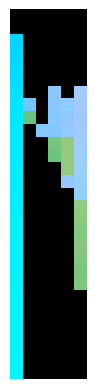

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


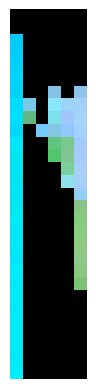

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


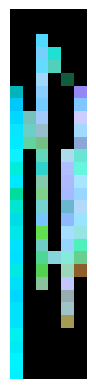

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


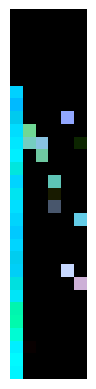

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


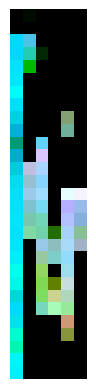

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


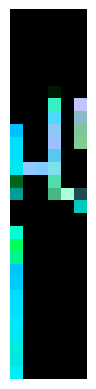

Epoch [234/300], Batch 0/64, Discriminator Loss: 0.5459, Generator Loss: 1.4520
tensor([[1.3805],
        [2.4184],
        [1.5755]], requires_grad=True)
tensor([[0.2382],
        [1.3458],
        [1.4202]], requires_grad=True)
mean disc rating of real images: tensor(1.0685)
mean disc rating of fake images: tensor(-0.3372)
Epoch: 236 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:30<00:00,  1.42s/it]

real image:


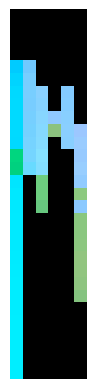

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


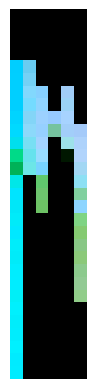

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


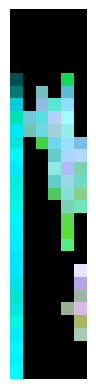

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


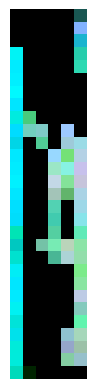

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


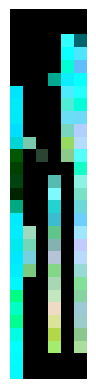

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


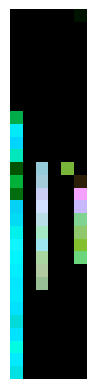

Epoch [235/300], Batch 0/64, Discriminator Loss: 0.5476, Generator Loss: 0.9977
tensor([[-0.2461],
        [ 0.5870],
        [-0.5411]], requires_grad=True)
tensor([[-0.8836],
        [-0.6427],
        [-1.8581]], requires_grad=True)
mean disc rating of real images: tensor(0.2626)
mean disc rating of fake images: tensor(-0.9786)
Epoch: 237 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


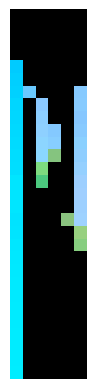

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


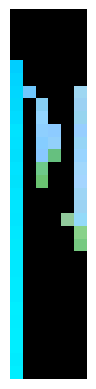

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


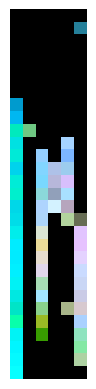

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


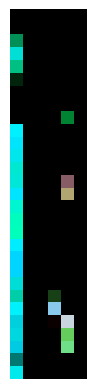

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


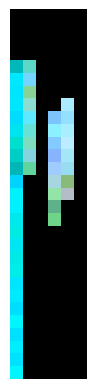

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


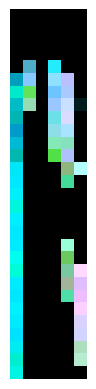

Epoch [236/300], Batch 0/64, Discriminator Loss: 0.5503, Generator Loss: 1.3019
tensor([[ 0.4328],
        [ 7.3968],
        [-0.6333]], requires_grad=True)
tensor([[-2.1602],
        [ 2.2476],
        [-1.1808]], requires_grad=True)
mean disc rating of real images: tensor(0.7055)
mean disc rating of fake images: tensor(-0.5403)
Epoch: 238 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


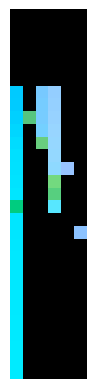

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


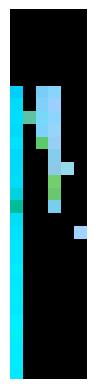

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


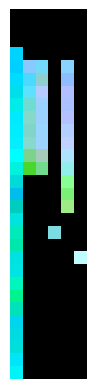

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


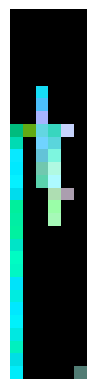

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


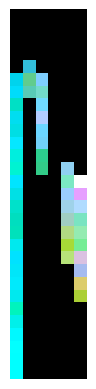

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


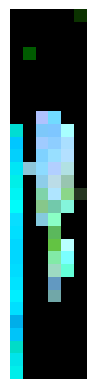

Epoch [237/300], Batch 0/64, Discriminator Loss: 0.5789, Generator Loss: 1.4227
tensor([[1.2030],
        [1.1618],
        [0.3799]], requires_grad=True)
tensor([[ 0.3192],
        [ 0.7994],
        [-0.4479]], requires_grad=True)
mean disc rating of real images: tensor(0.8376)
mean disc rating of fake images: tensor(-0.2005)
Epoch: 239 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


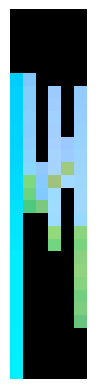

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


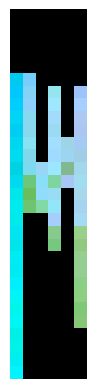

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


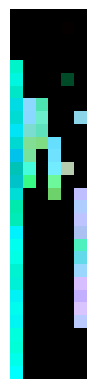

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


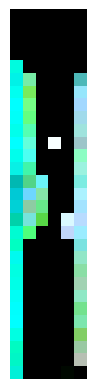

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


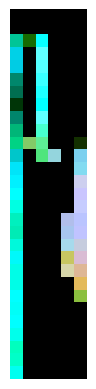

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


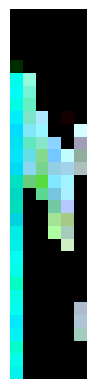

Epoch [238/300], Batch 0/64, Discriminator Loss: 0.7077, Generator Loss: 2.3708
tensor([[1.2575],
        [1.5132],
        [1.7395]], requires_grad=True)
tensor([[ 0.9235],
        [ 1.4659],
        [-0.0207]], requires_grad=True)
mean disc rating of real images: tensor(1.9142)
mean disc rating of fake images: tensor(0.6568)
Epoch: 240 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


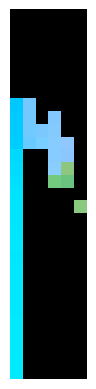

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


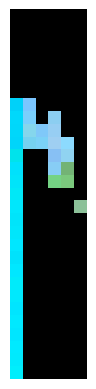

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


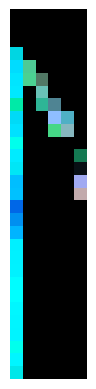

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


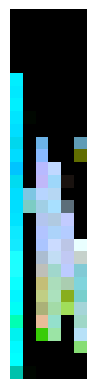

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


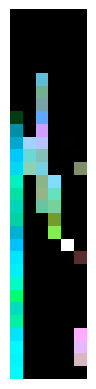

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


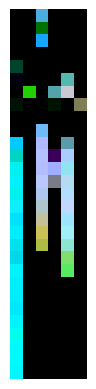

Epoch [239/300], Batch 0/64, Discriminator Loss: 0.5665, Generator Loss: 1.9469
tensor([[0.8808],
        [1.1552],
        [0.7379]], requires_grad=True)
tensor([[-0.9332],
        [ 1.5351],
        [-0.1794]], requires_grad=True)
mean disc rating of real images: tensor(1.6292)
mean disc rating of fake images: tensor(0.0677)
Epoch: 241 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


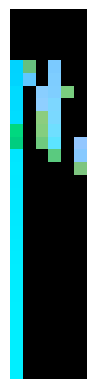

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


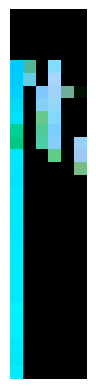

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


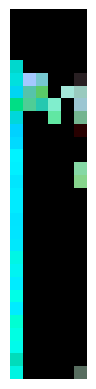

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


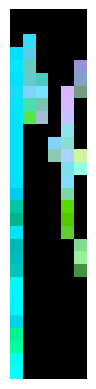

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


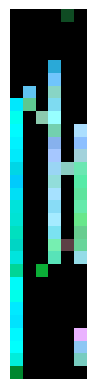

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


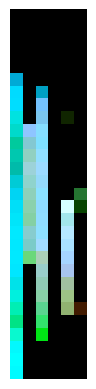

Epoch [240/300], Batch 0/64, Discriminator Loss: 0.5311, Generator Loss: 1.3728
tensor([[0.5685],
        [0.1105],
        [0.6760]], requires_grad=True)
tensor([[-1.0444],
        [-0.2708],
        [-0.2315]], requires_grad=True)
mean disc rating of real images: tensor(0.9986)
mean disc rating of fake images: tensor(-0.3287)
Epoch: 242 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


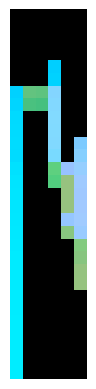

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


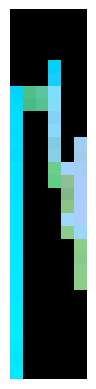

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


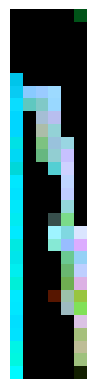

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


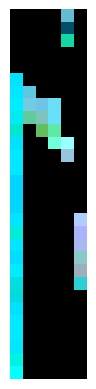

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


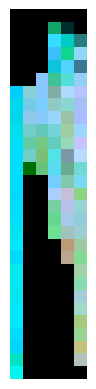

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


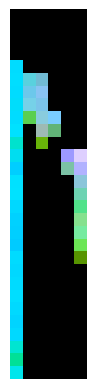

Epoch [241/300], Batch 0/64, Discriminator Loss: 0.5353, Generator Loss: 1.3630
tensor([[0.4559],
        [1.5702],
        [0.7866]], requires_grad=True)
tensor([[ 1.3199],
        [-1.0427],
        [-1.0476]], requires_grad=True)
mean disc rating of real images: tensor(1.0096)
mean disc rating of fake images: tensor(-0.5783)
Epoch: 243 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


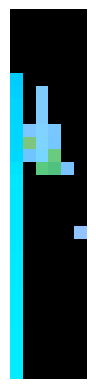

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


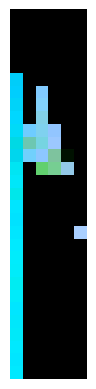

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


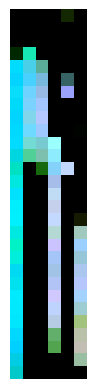

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


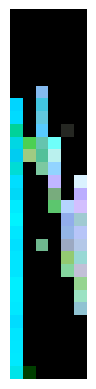

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


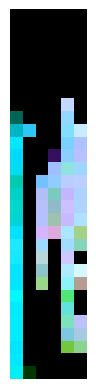

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


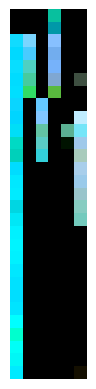

Epoch [242/300], Batch 0/64, Discriminator Loss: 0.5381, Generator Loss: 0.8451
tensor([[ 0.8131],
        [-1.2272],
        [ 2.1969]], requires_grad=True)
tensor([[-1.1868],
        [-1.9668],
        [-3.1090]], requires_grad=True)
mean disc rating of real images: tensor(0.0064)
mean disc rating of fake images: tensor(-1.4177)
Epoch: 244 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


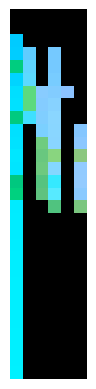

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


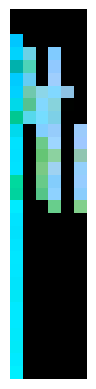

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


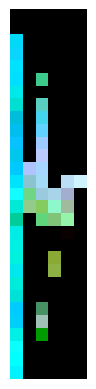

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


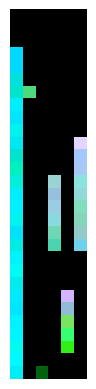

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


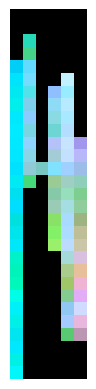

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


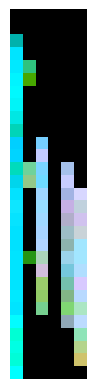

Epoch [243/300], Batch 0/64, Discriminator Loss: 0.5549, Generator Loss: 1.1669
tensor([[-1.2393],
        [-1.7967],
        [-0.1246]], requires_grad=True)
tensor([[-1.3852],
        [-2.0065],
        [-2.2351]], requires_grad=True)
mean disc rating of real images: tensor(0.1807)
mean disc rating of fake images: tensor(-1.4007)
Epoch: 245 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


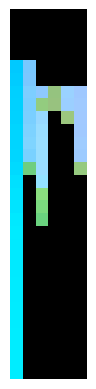

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


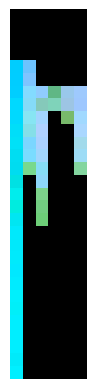

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


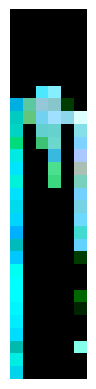

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


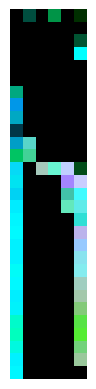

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


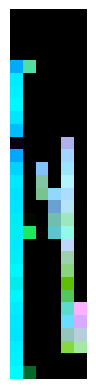

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


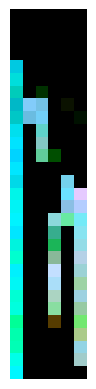

Epoch [244/300], Batch 0/64, Discriminator Loss: 0.5341, Generator Loss: 1.3086
tensor([[0.0889],
        [0.6613],
        [2.1055]], requires_grad=True)
tensor([[0.0621],
        [0.7115],
        [0.3622]], requires_grad=True)
mean disc rating of real images: tensor(0.6929)
mean disc rating of fake images: tensor(-0.6522)
Epoch: 246 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


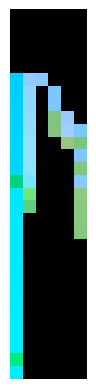

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


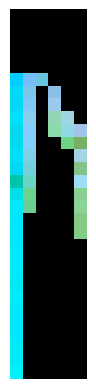

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


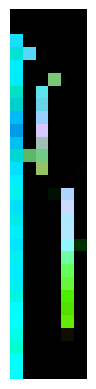

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


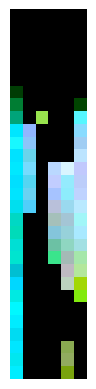

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


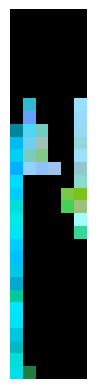

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


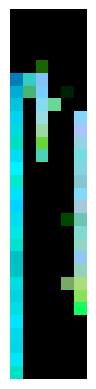

Epoch [245/300], Batch 0/64, Discriminator Loss: 0.5688, Generator Loss: 1.6221
tensor([[ 1.9776],
        [-0.2822],
        [-1.1798]], requires_grad=True)
tensor([[-0.7484],
        [ 2.3081],
        [-3.9450]], requires_grad=True)
mean disc rating of real images: tensor(0.9949)
mean disc rating of fake images: tensor(-0.3454)
Epoch: 247 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


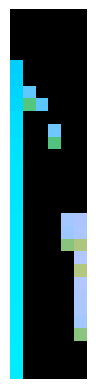

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


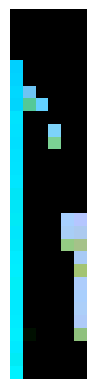

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


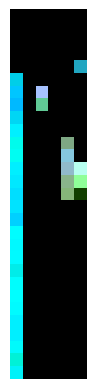

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


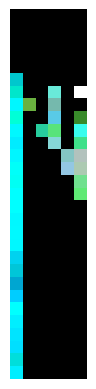

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


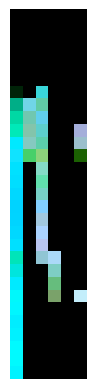

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


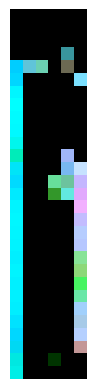

Epoch [246/300], Batch 0/64, Discriminator Loss: 0.6543, Generator Loss: 0.7694
tensor([[-0.6775],
        [ 0.1850],
        [ 0.5322]], requires_grad=True)
tensor([[-0.9165],
        [-1.2865],
        [-0.6187]], requires_grad=True)
mean disc rating of real images: tensor(-0.1857)
mean disc rating of fake images: tensor(-1.2561)
Epoch: 248 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


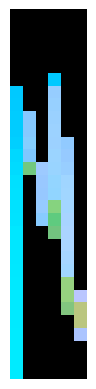

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


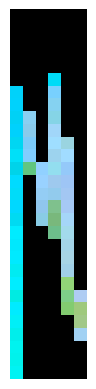

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


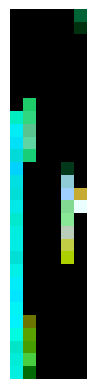

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


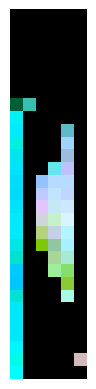

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


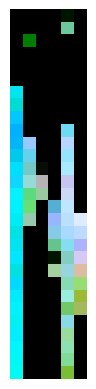

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


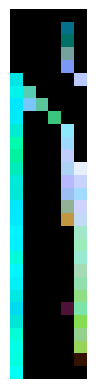

Epoch [247/300], Batch 0/64, Discriminator Loss: 0.4821, Generator Loss: 1.3699
tensor([[0.1492],
        [1.9764],
        [1.2434]], requires_grad=True)
tensor([[-0.0265],
        [-1.4282],
        [-0.6029]], requires_grad=True)
mean disc rating of real images: tensor(0.8964)
mean disc rating of fake images: tensor(-0.7718)
Epoch: 249 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


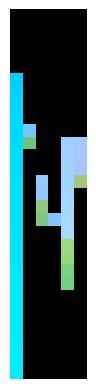

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


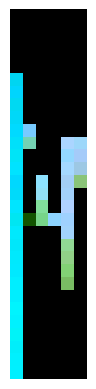

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


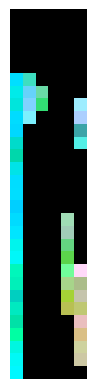

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


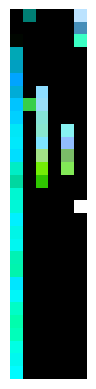

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


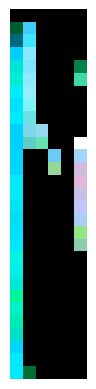

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


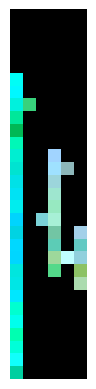

Epoch [248/300], Batch 0/64, Discriminator Loss: 0.5424, Generator Loss: 1.6691
tensor([[2.3267],
        [2.2821],
        [0.8921]], requires_grad=True)
tensor([[ 1.5361],
        [-0.1193],
        [-0.1087]], requires_grad=True)
mean disc rating of real images: tensor(1.5611)
mean disc rating of fake images: tensor(-0.0496)
Epoch: 250 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


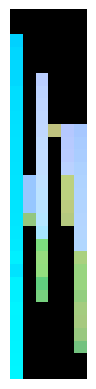

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


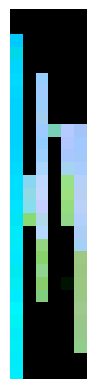

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


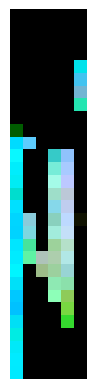

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


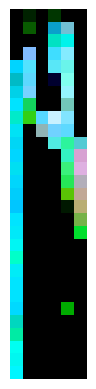

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


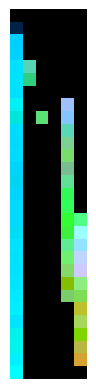

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


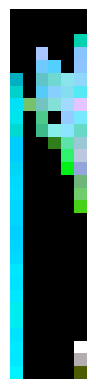

Epoch [249/300], Batch 0/64, Discriminator Loss: 0.5096, Generator Loss: 1.2549
tensor([[ 2.4565],
        [-0.0850],
        [ 0.0562]], requires_grad=True)
tensor([[-1.2937],
        [-0.3571],
        [-1.4850]], requires_grad=True)
mean disc rating of real images: tensor(0.5087)
mean disc rating of fake images: tensor(-1.2052)
Epoch: 251 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


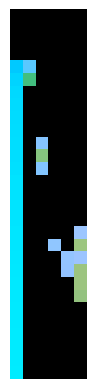

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


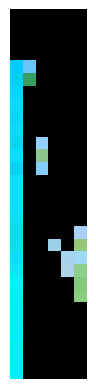

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


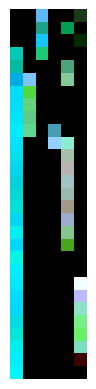

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


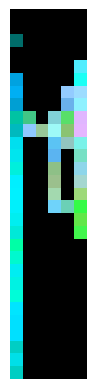

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


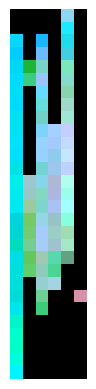

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


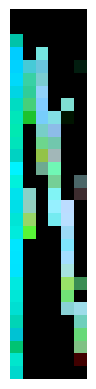

Epoch [250/300], Batch 0/64, Discriminator Loss: 0.5111, Generator Loss: 1.4476
tensor([[-0.1016],
        [ 0.7827],
        [ 4.0682]], requires_grad=True)
tensor([[-1.1661],
        [-0.5858],
        [-0.2783]], requires_grad=True)
mean disc rating of real images: tensor(0.8008)
mean disc rating of fake images: tensor(-0.7108)
Epoch: 252 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


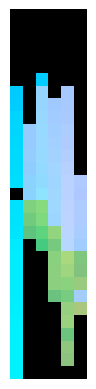

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


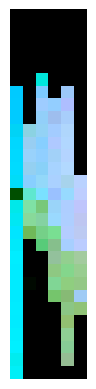

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


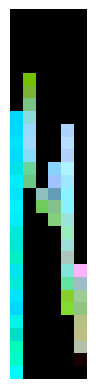

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


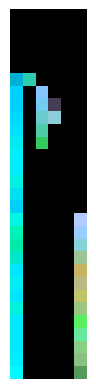

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


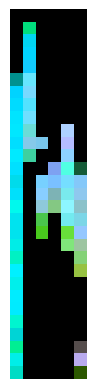

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


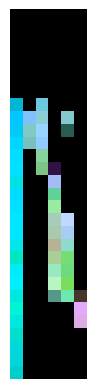

Epoch [251/300], Batch 0/64, Discriminator Loss: 0.5790, Generator Loss: 0.9547
tensor([[-0.8464],
        [-0.5148],
        [-0.0204]], requires_grad=True)
tensor([[-1.4524],
        [-2.0522],
        [ 0.4016]], requires_grad=True)
mean disc rating of real images: tensor(-0.0385)
mean disc rating of fake images: tensor(-1.4764)
Epoch: 253 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


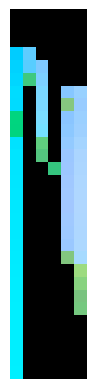

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


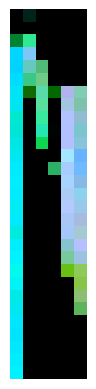

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


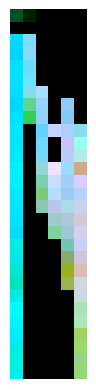

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


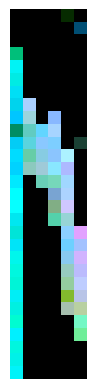

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


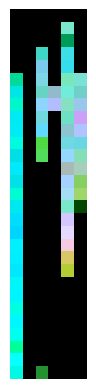

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


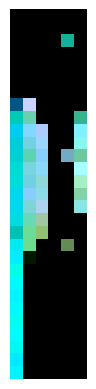

Epoch [252/300], Batch 0/64, Discriminator Loss: 0.5159, Generator Loss: 1.4525
tensor([[-0.4729],
        [ 0.7657],
        [ 1.7841]], requires_grad=True)
tensor([[-0.7309],
        [-1.9555],
        [-0.1101]], requires_grad=True)
mean disc rating of real images: tensor(0.8715)
mean disc rating of fake images: tensor(-0.5474)
Epoch: 254 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


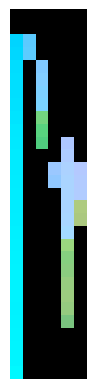

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


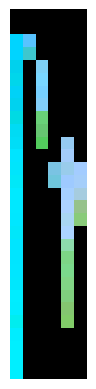

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


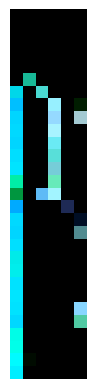

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


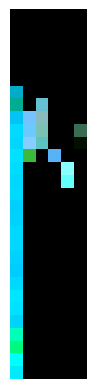

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


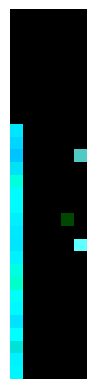

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


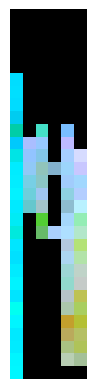

Epoch [253/300], Batch 0/64, Discriminator Loss: 0.6140, Generator Loss: 0.7552
tensor([[-0.6690],
        [-1.0829],
        [-0.2357]], requires_grad=True)
tensor([[-0.2373],
        [-1.7586],
        [-3.0558]], requires_grad=True)
mean disc rating of real images: tensor(-0.3830)
mean disc rating of fake images: tensor(-1.9176)
Epoch: 255 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


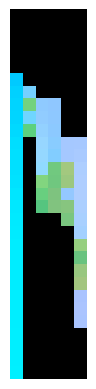

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


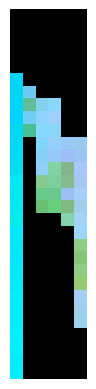

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


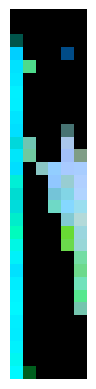

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


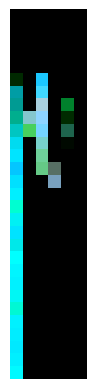

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


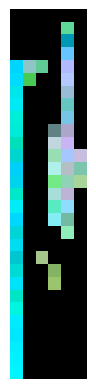

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


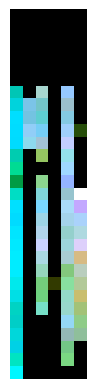

Epoch [254/300], Batch 0/64, Discriminator Loss: 0.5300, Generator Loss: 1.4054
tensor([[-0.8706],
        [-1.6663],
        [ 1.0185]], requires_grad=True)
tensor([[-1.5342],
        [-0.0141],
        [-1.2490]], requires_grad=True)
mean disc rating of real images: tensor(0.6475)
mean disc rating of fake images: tensor(-0.6194)
Epoch: 256 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:29<00:00,  1.40s/it]

real image:


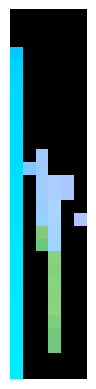

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


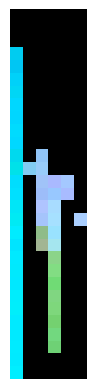

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


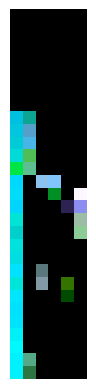

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


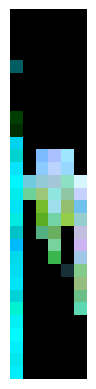

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


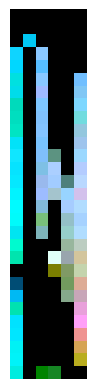

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


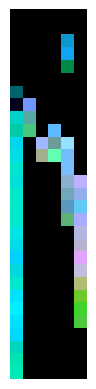

Epoch [255/300], Batch 0/64, Discriminator Loss: 0.5713, Generator Loss: 1.8856
tensor([[1.5410],
        [3.4643],
        [1.5873]], requires_grad=True)
tensor([[ 1.0122],
        [-0.0226],
        [-1.6567]], requires_grad=True)
mean disc rating of real images: tensor(1.5553)
mean disc rating of fake images: tensor(0.0909)
Epoch: 257 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


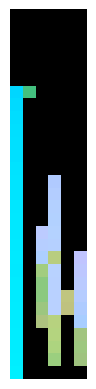

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


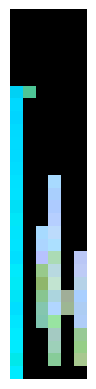

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


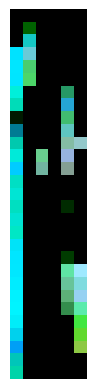

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


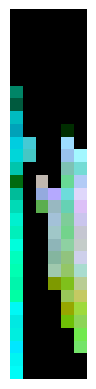

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


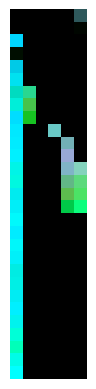

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


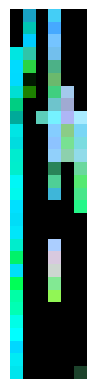

Epoch [256/300], Batch 0/64, Discriminator Loss: 0.5448, Generator Loss: 1.6614
tensor([[ 1.5331],
        [-0.1665],
        [ 3.6950]], requires_grad=True)
tensor([[-1.7271],
        [-1.1785],
        [-1.8680]], requires_grad=True)
mean disc rating of real images: tensor(1.1862)
mean disc rating of fake images: tensor(-0.3189)
Epoch: 258 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:24<00:00,  1.33s/it]

real image:


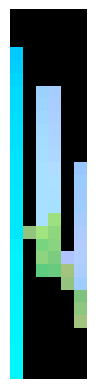

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


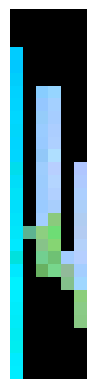

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


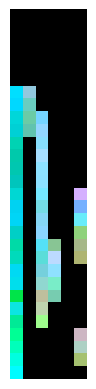

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


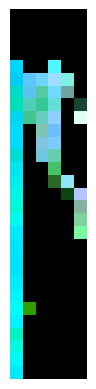

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


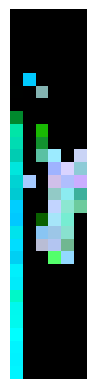

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


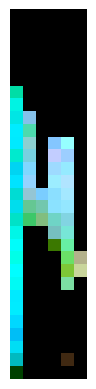

Epoch [257/300], Batch 0/64, Discriminator Loss: 0.4815, Generator Loss: 1.2791
tensor([[0.2453],
        [0.5752],
        [1.3867]], requires_grad=True)
tensor([[ 0.3403],
        [-4.6929],
        [-2.4282]], requires_grad=True)
mean disc rating of real images: tensor(0.6495)
mean disc rating of fake images: tensor(-0.9177)
Epoch: 259 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


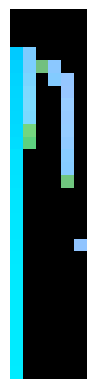

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


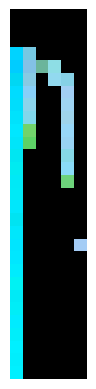

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


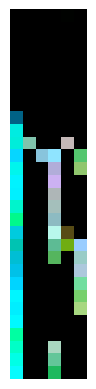

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


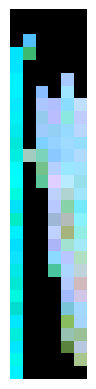

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


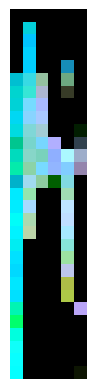

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


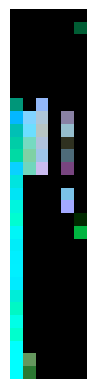

Epoch [258/300], Batch 0/64, Discriminator Loss: 0.5270, Generator Loss: 1.8838
tensor([[ 3.4787],
        [-0.1562],
        [ 2.4905]], requires_grad=True)
tensor([[-1.2614],
        [ 1.5377],
        [-3.4525]], requires_grad=True)
mean disc rating of real images: tensor(1.3719)
mean disc rating of fake images: tensor(-0.2166)
Epoch: 260 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


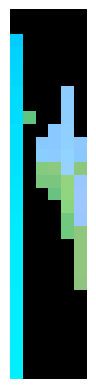

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


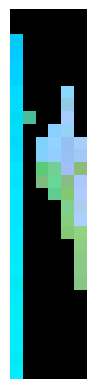

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


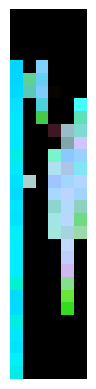

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


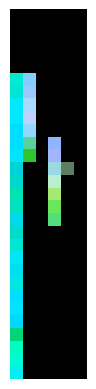

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


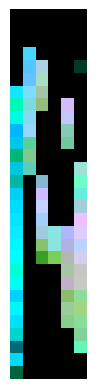

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


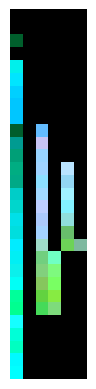

Epoch [259/300], Batch 0/64, Discriminator Loss: 0.5120, Generator Loss: 1.3506
tensor([[-0.3028],
        [ 2.1462],
        [ 0.4617]], requires_grad=True)
tensor([[-0.1552],
        [-2.0456],
        [-0.6990]], requires_grad=True)
mean disc rating of real images: tensor(0.5539)
mean disc rating of fake images: tensor(-1.0459)
Epoch: 261 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


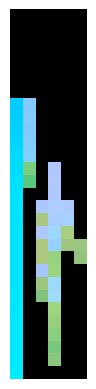

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


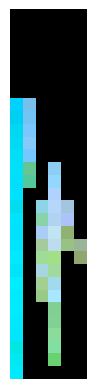

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


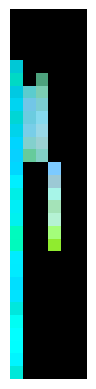

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


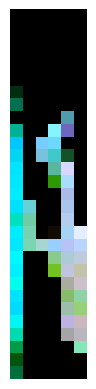

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


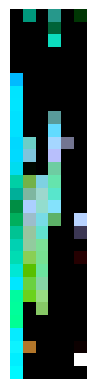

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


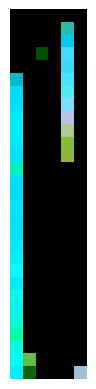

Epoch [260/300], Batch 0/64, Discriminator Loss: 0.5698, Generator Loss: 1.0715
tensor([[ 0.5504],
        [ 0.6186],
        [-0.3756]], requires_grad=True)
tensor([[-1.3048],
        [-0.1869],
        [-1.9334]], requires_grad=True)
mean disc rating of real images: tensor(0.0266)
mean disc rating of fake images: tensor(-1.2868)
Epoch: 262 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


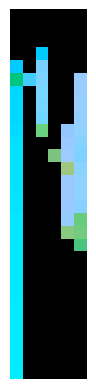

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


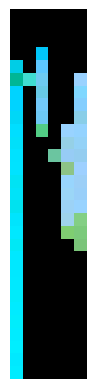

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


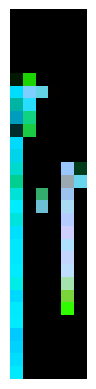

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


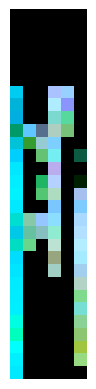

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


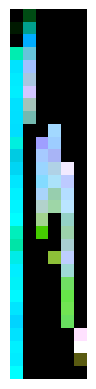

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


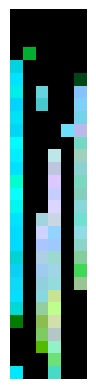

Epoch [261/300], Batch 0/64, Discriminator Loss: 0.5934, Generator Loss: 0.8875
tensor([[0.5257],
        [0.2796],
        [0.7164]], requires_grad=True)
tensor([[-0.6333],
        [ 0.1538],
        [-0.0347]], requires_grad=True)
mean disc rating of real images: tensor(-0.0429)
mean disc rating of fake images: tensor(-1.1630)
Epoch: 263 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


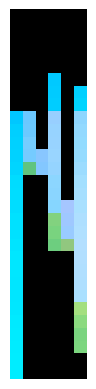

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


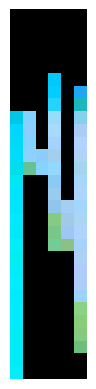

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


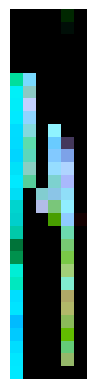

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


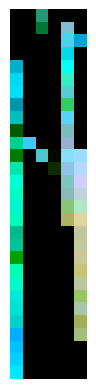

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


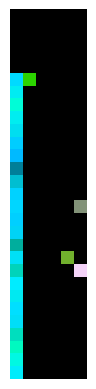

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


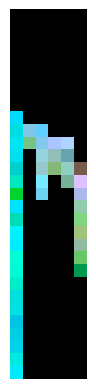

Epoch [262/300], Batch 0/64, Discriminator Loss: 0.4966, Generator Loss: 1.2633
tensor([[-0.8537],
        [ 0.6808],
        [-1.7363]], requires_grad=True)
tensor([[-3.7360],
        [-0.0899],
        [-5.8264]], requires_grad=True)
mean disc rating of real images: tensor(0.8591)
mean disc rating of fake images: tensor(-0.8291)
Epoch: 264 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


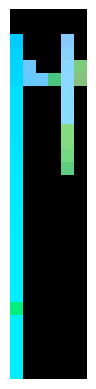

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


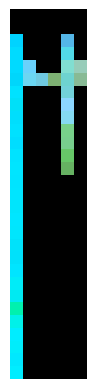

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


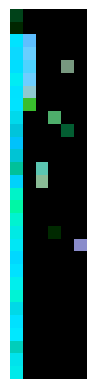

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


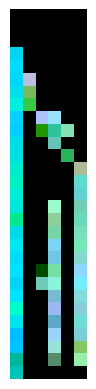

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


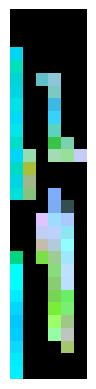

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


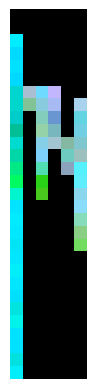

Epoch [263/300], Batch 0/64, Discriminator Loss: 0.5955, Generator Loss: 1.7262
tensor([[ 3.4818],
        [-1.0106],
        [ 1.8299]], requires_grad=True)
tensor([[ 0.5338],
        [-0.3253],
        [ 0.6639]], requires_grad=True)
mean disc rating of real images: tensor(1.1882)
mean disc rating of fake images: tensor(-0.0271)
Epoch: 265 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.33s/it]

real image:


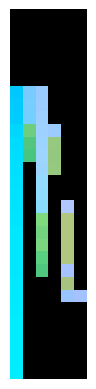

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


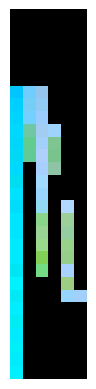

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


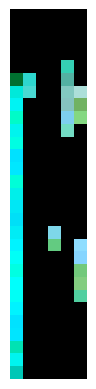

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


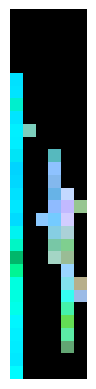

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


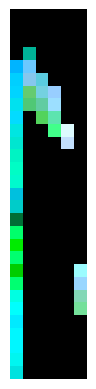

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


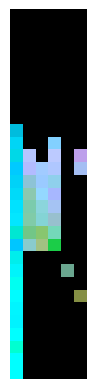

Epoch [264/300], Batch 0/64, Discriminator Loss: 0.5261, Generator Loss: 1.2393
tensor([[1.3675],
        [0.6993],
        [1.7374]], requires_grad=True)
tensor([[ 1.2961],
        [ 0.4551],
        [-1.2400]], requires_grad=True)
mean disc rating of real images: tensor(0.6094)
mean disc rating of fake images: tensor(-0.8495)
Epoch: 266 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


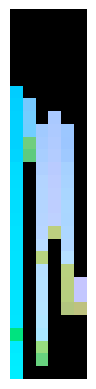

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


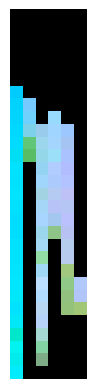

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


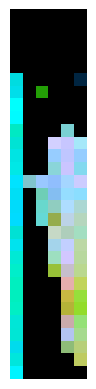

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


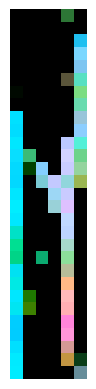

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


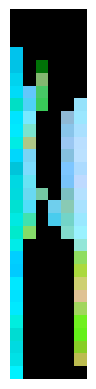

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


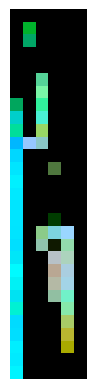

Epoch [265/300], Batch 0/64, Discriminator Loss: 0.4842, Generator Loss: 1.6752
tensor([[ 1.8631],
        [ 0.7534],
        [-0.2395]], requires_grad=True)
tensor([[-3.6789],
        [-0.5103],
        [-0.6937]], requires_grad=True)
mean disc rating of real images: tensor(1.2141)
mean disc rating of fake images: tensor(-0.7120)
Epoch: 267 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.36s/it]

real image:


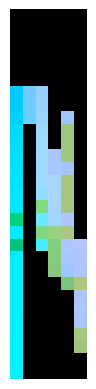

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


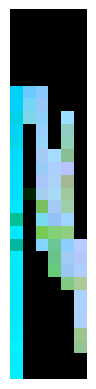

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


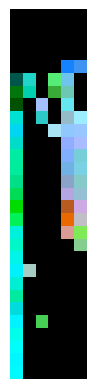

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


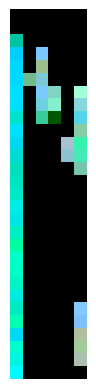

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


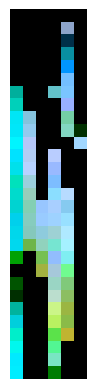

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


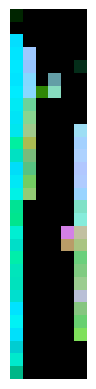

Epoch [266/300], Batch 0/64, Discriminator Loss: 0.5634, Generator Loss: 0.8618
tensor([[0.0531],
        [0.6454],
        [0.3702]], requires_grad=True)
tensor([[-3.9047],
        [-3.8521],
        [-0.0784]], requires_grad=True)
mean disc rating of real images: tensor(0.0469)
mean disc rating of fake images: tensor(-1.5589)
Epoch: 268 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


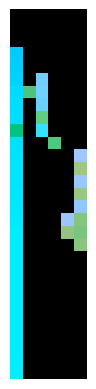

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


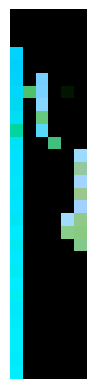

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


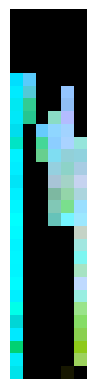

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


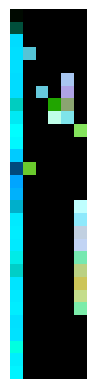

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


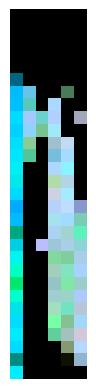

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


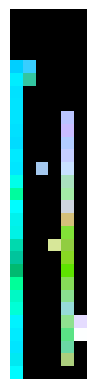

Epoch [267/300], Batch 0/64, Discriminator Loss: 0.5815, Generator Loss: 1.4646
tensor([[ 0.6477],
        [-0.5355],
        [-1.2071]], requires_grad=True)
tensor([[-1.4368],
        [ 0.5362],
        [-2.4628]], requires_grad=True)
mean disc rating of real images: tensor(0.5574)
mean disc rating of fake images: tensor(-0.5972)
Epoch: 269 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


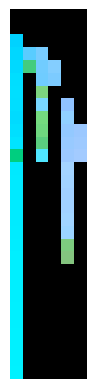

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


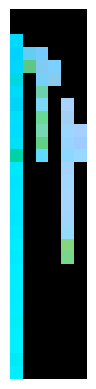

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


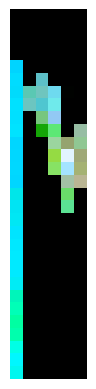

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


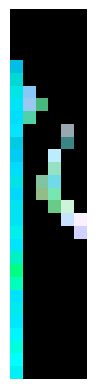

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


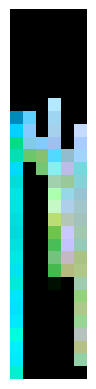

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


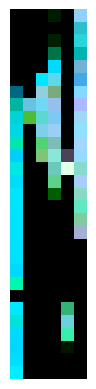

Epoch [268/300], Batch 0/64, Discriminator Loss: 0.5499, Generator Loss: 1.4442
tensor([[2.7305],
        [1.8659],
        [2.6598]], requires_grad=True)
tensor([[ 0.8742],
        [-0.9337],
        [-0.5405]], requires_grad=True)
mean disc rating of real images: tensor(0.8256)
mean disc rating of fake images: tensor(-0.3687)
Epoch: 270 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


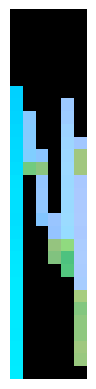

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


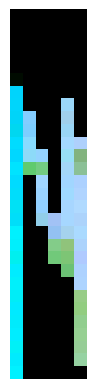

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


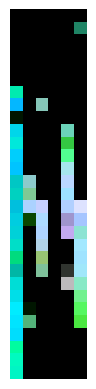

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


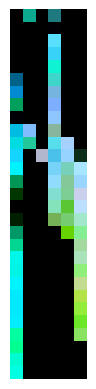

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


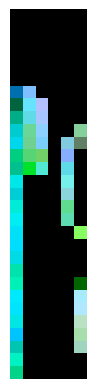

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


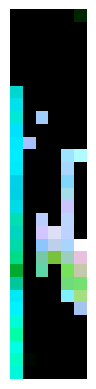

Epoch [269/300], Batch 0/64, Discriminator Loss: 0.5183, Generator Loss: 1.0185
tensor([[ 0.1196],
        [ 0.8395],
        [-0.3986]], requires_grad=True)
tensor([[-0.8225],
        [-0.5503],
        [-1.0050]], requires_grad=True)
mean disc rating of real images: tensor(0.3591)
mean disc rating of fake images: tensor(-1.2793)
Epoch: 271 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


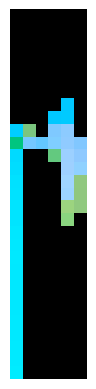

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


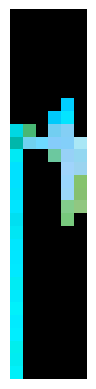

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


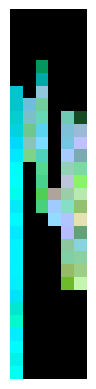

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


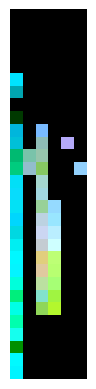

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


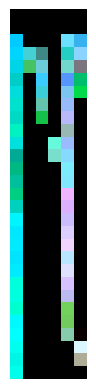

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


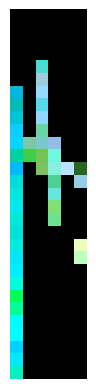

Epoch [270/300], Batch 0/64, Discriminator Loss: 0.5715, Generator Loss: 1.0900
tensor([[ 0.1003],
        [ 0.9734],
        [-0.3621]], requires_grad=True)
tensor([[-0.9941],
        [-0.3891],
        [-2.4427]], requires_grad=True)
mean disc rating of real images: tensor(0.0955)
mean disc rating of fake images: tensor(-1.1440)
Epoch: 272 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


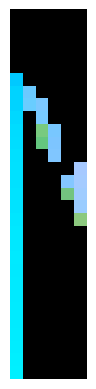

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


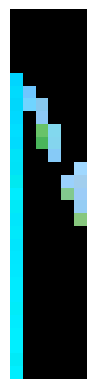

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


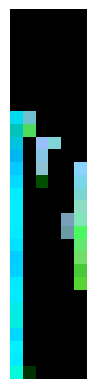

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


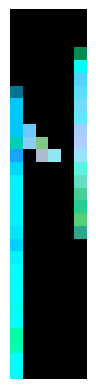

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


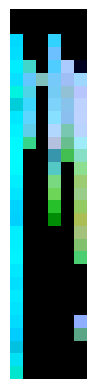

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


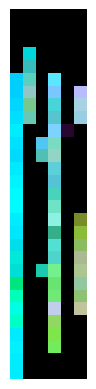

Epoch [271/300], Batch 0/64, Discriminator Loss: 0.5439, Generator Loss: 1.2638
tensor([[0.9728],
        [2.0798],
        [3.4751]], requires_grad=True)
tensor([[-1.7328],
        [-1.0152],
        [-1.1934]], requires_grad=True)
mean disc rating of real images: tensor(0.6252)
mean disc rating of fake images: tensor(-0.8369)
Epoch: 273 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


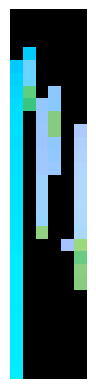

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


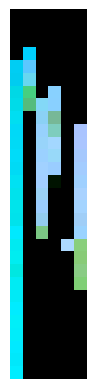

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


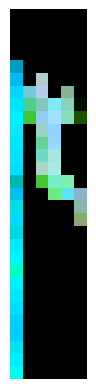

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


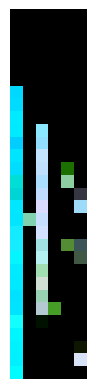

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


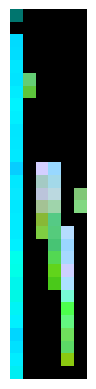

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


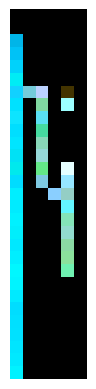

Epoch [272/300], Batch 0/64, Discriminator Loss: 0.5806, Generator Loss: 1.5675
tensor([[-1.8923],
        [ 2.6076],
        [ 2.2907]], requires_grad=True)
tensor([[ 0.3825],
        [-2.6036],
        [-3.5091]], requires_grad=True)
mean disc rating of real images: tensor(1.0275)
mean disc rating of fake images: tensor(-0.3642)
Epoch: 274 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


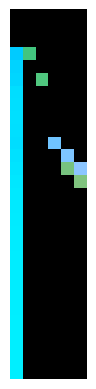

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


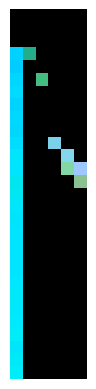

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


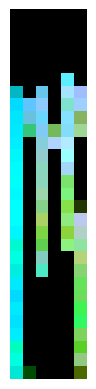

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


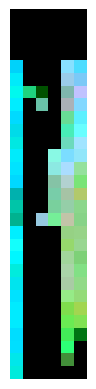

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


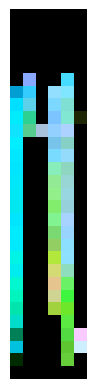

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


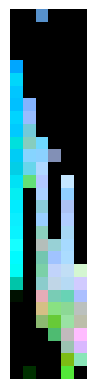

Epoch [273/300], Batch 0/64, Discriminator Loss: 0.5848, Generator Loss: 1.8273
tensor([[1.8491],
        [0.4960],
        [0.3129]], requires_grad=True)
tensor([[-0.3961],
        [ 0.4707],
        [ 0.1458]], requires_grad=True)
mean disc rating of real images: tensor(1.5692)
mean disc rating of fake images: tensor(0.1589)
Epoch: 275 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


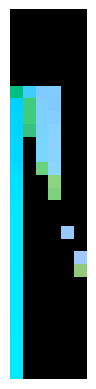

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


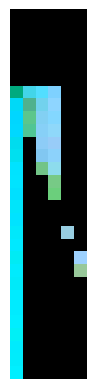

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


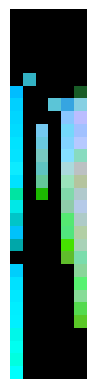

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


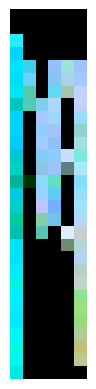

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


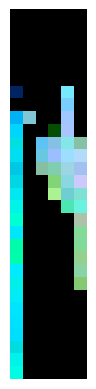

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


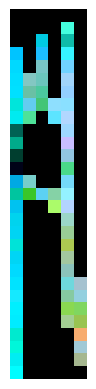

Epoch [274/300], Batch 0/64, Discriminator Loss: 0.5045, Generator Loss: 1.2460
tensor([[-0.3808],
        [ 0.0921],
        [ 1.7217]], requires_grad=True)
tensor([[-0.9697],
        [ 0.4471],
        [-1.1730]], requires_grad=True)
mean disc rating of real images: tensor(0.5844)
mean disc rating of fake images: tensor(-1.1759)
Epoch: 276 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


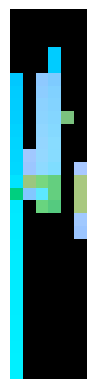

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


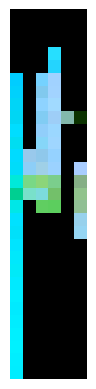

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


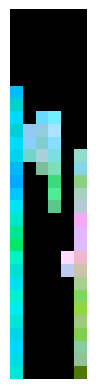

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


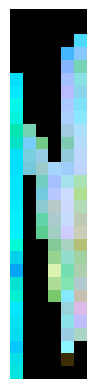

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


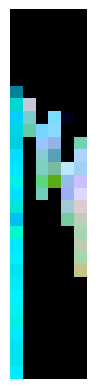

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


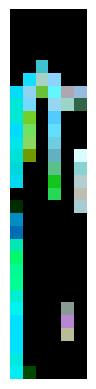

Epoch [275/300], Batch 0/64, Discriminator Loss: 0.5326, Generator Loss: 1.1596
tensor([[ 1.2701],
        [-0.2108],
        [ 0.2751]], requires_grad=True)
tensor([[-0.1368],
        [-1.8588],
        [-0.0985]], requires_grad=True)
mean disc rating of real images: tensor(0.5634)
mean disc rating of fake images: tensor(-0.9174)
Epoch: 277 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


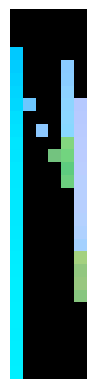

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


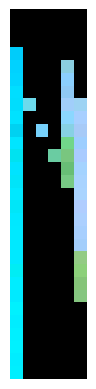

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


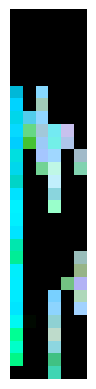

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


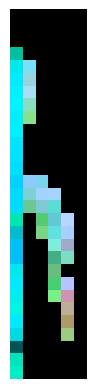

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


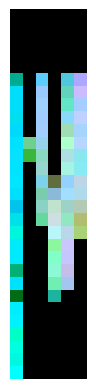

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


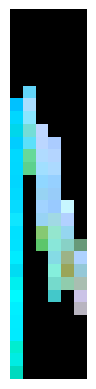

Epoch [276/300], Batch 0/64, Discriminator Loss: 0.5630, Generator Loss: 1.3911
tensor([[ 0.4906],
        [-0.6380],
        [-0.4977]], requires_grad=True)
tensor([[-2.0785],
        [-2.3394],
        [-0.0299]], requires_grad=True)
mean disc rating of real images: tensor(0.3534)
mean disc rating of fake images: tensor(-1.1167)
Epoch: 278 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.34s/it]

real image:


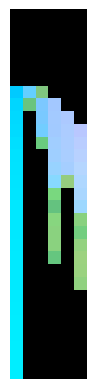

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


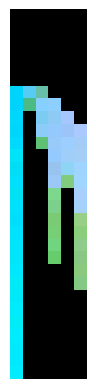

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


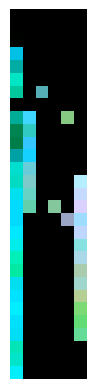

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


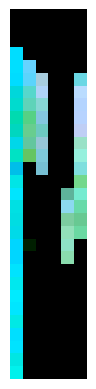

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


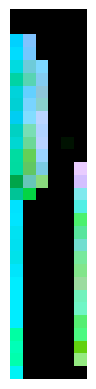

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


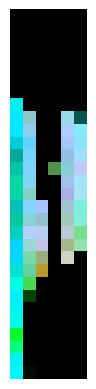

Epoch [277/300], Batch 0/64, Discriminator Loss: 0.5183, Generator Loss: 1.8081
tensor([[-0.0121],
        [ 1.2885],
        [ 0.4294]], requires_grad=True)
tensor([[1.7461],
        [0.0759],
        [0.6840]], requires_grad=True)
mean disc rating of real images: tensor(1.2519)
mean disc rating of fake images: tensor(-0.3546)
Epoch: 279 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


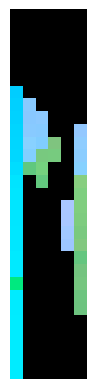

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


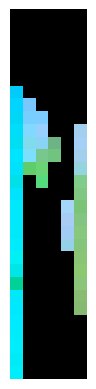

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


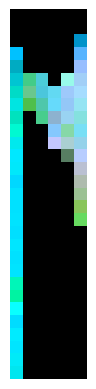

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


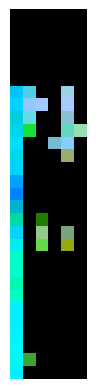

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


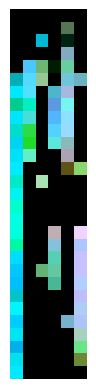

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


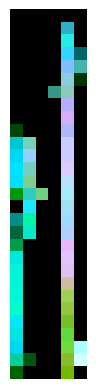

Epoch [278/300], Batch 0/64, Discriminator Loss: 0.4686, Generator Loss: 1.3299
tensor([[0.2401],
        [2.1292],
        [0.8475]], requires_grad=True)
tensor([[-1.2179],
        [-1.4145],
        [-1.0155]], requires_grad=True)
mean disc rating of real images: tensor(0.8274)
mean disc rating of fake images: tensor(-0.8220)
Epoch: 280 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


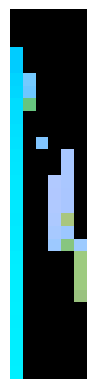

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


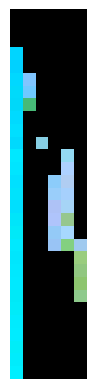

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


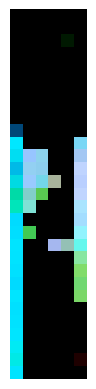

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


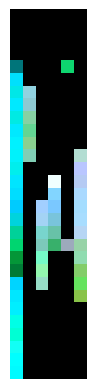

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


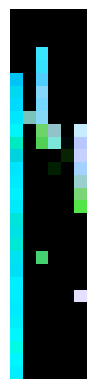

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


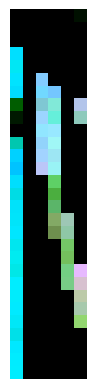

Epoch [279/300], Batch 0/64, Discriminator Loss: 0.4885, Generator Loss: 1.3379
tensor([[ 1.0463],
        [-0.0135],
        [ 1.1072]], requires_grad=True)
tensor([[ 0.1250],
        [ 0.6288],
        [-0.7255]], requires_grad=True)
mean disc rating of real images: tensor(0.8488)
mean disc rating of fake images: tensor(-0.7889)
Epoch: 281 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]

real image:


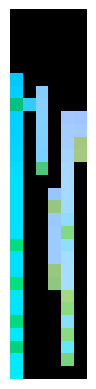

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


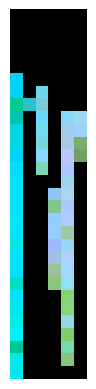

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


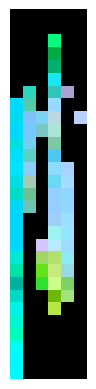

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


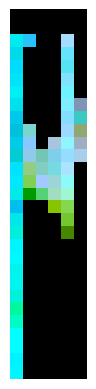

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


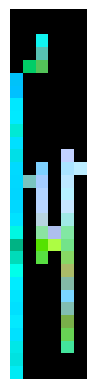

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


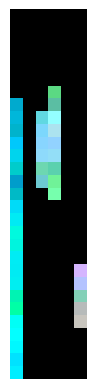

Epoch [280/300], Batch 0/64, Discriminator Loss: 0.5029, Generator Loss: 1.6748
tensor([[2.1559],
        [2.4661],
        [1.1683]], requires_grad=True)
tensor([[-0.7958],
        [-0.3579],
        [-1.2643]], requires_grad=True)
mean disc rating of real images: tensor(0.9361)
mean disc rating of fake images: tensor(-0.8237)
Epoch: 282 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.36s/it]

real image:


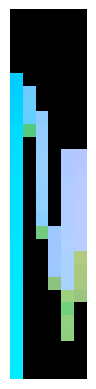

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


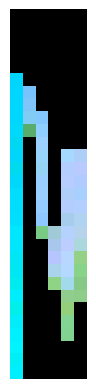

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


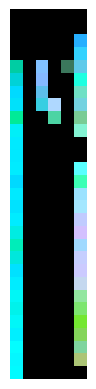

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


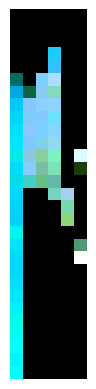

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


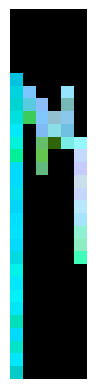

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


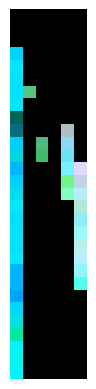

Epoch [281/300], Batch 0/64, Discriminator Loss: 0.5959, Generator Loss: 1.7886
tensor([[-0.0860],
        [ 0.1956],
        [ 3.5095]], requires_grad=True)
tensor([[-1.1518],
        [-0.0053],
        [-0.2749]], requires_grad=True)
mean disc rating of real images: tensor(1.3677)
mean disc rating of fake images: tensor(0.0501)
Epoch: 283 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:27<00:00,  1.36s/it]

real image:


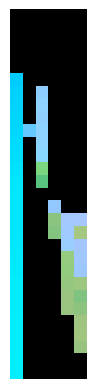

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


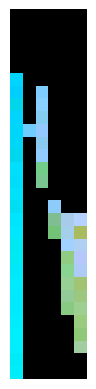

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


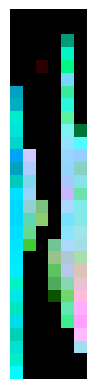

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


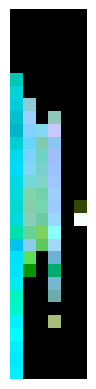

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


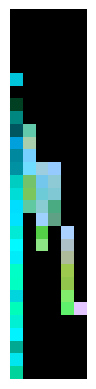

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


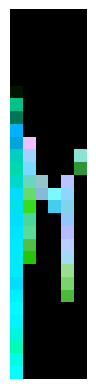

Epoch [282/300], Batch 0/64, Discriminator Loss: 0.4944, Generator Loss: 1.1936
tensor([[1.1453],
        [0.4164],
        [0.0038]], requires_grad=True)
tensor([[ 0.0538],
        [-1.4096],
        [-3.1566]], requires_grad=True)
mean disc rating of real images: tensor(0.5309)
mean disc rating of fake images: tensor(-1.2014)
Epoch: 284 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:26<00:00,  1.35s/it]

real image:


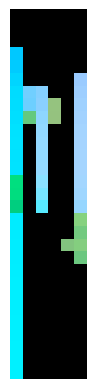

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


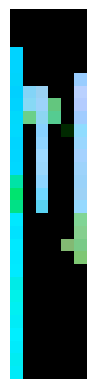

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


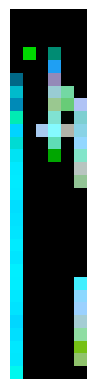

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


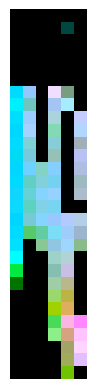

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


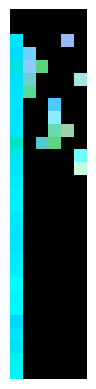

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


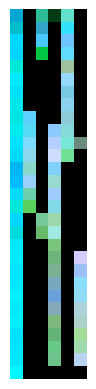

Epoch [283/300], Batch 0/64, Discriminator Loss: 0.5166, Generator Loss: 1.7007
tensor([[2.2096],
        [0.3102],
        [0.2977]], requires_grad=True)
tensor([[-1.8136],
        [-1.1032],
        [ 1.0760]], requires_grad=True)
mean disc rating of real images: tensor(0.9218)
mean disc rating of fake images: tensor(-0.7325)
Epoch: 285 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:36<00:00,  1.51s/it]

real image:


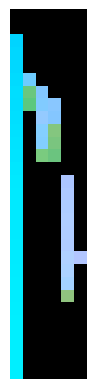

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


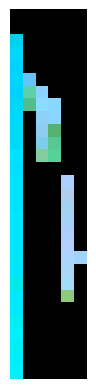

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


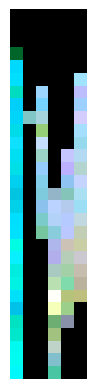

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


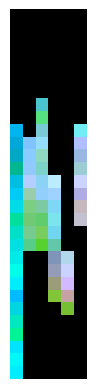

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


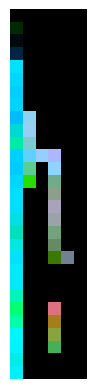

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


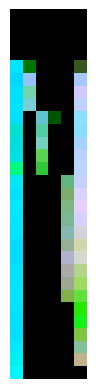

Epoch [284/300], Batch 0/64, Discriminator Loss: 0.6065, Generator Loss: 1.6659
tensor([[-0.9066],
        [ 0.8784],
        [-0.0210]], requires_grad=True)
tensor([[-1.2851],
        [ 1.3769],
        [ 0.1696]], requires_grad=True)
mean disc rating of real images: tensor(1.1104)
mean disc rating of fake images: tensor(-0.2844)
Epoch: 286 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:34<00:00,  1.47s/it]

real image:


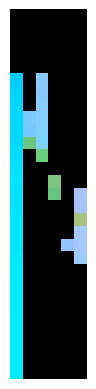

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


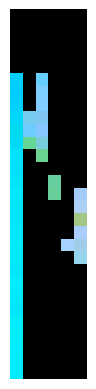

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


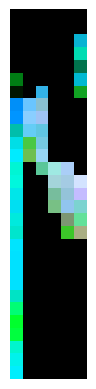

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


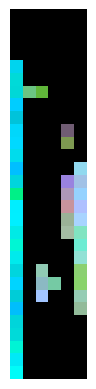

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


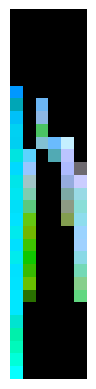

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


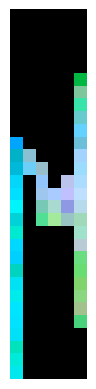

Epoch [285/300], Batch 0/64, Discriminator Loss: 0.5749, Generator Loss: 1.6452
tensor([[1.5605],
        [0.8224],
        [0.6601]], requires_grad=True)
tensor([[-4.7398],
        [-1.3045],
        [-0.4068]], requires_grad=True)
mean disc rating of real images: tensor(1.0825)
mean disc rating of fake images: tensor(-0.1755)
Epoch: 287 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:50<00:00,  1.73s/it]

real image:


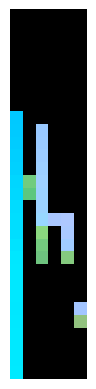

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


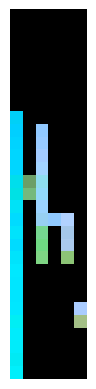

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random created images:


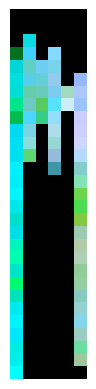

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


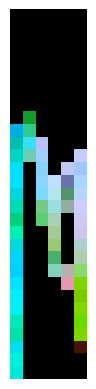

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


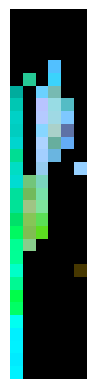

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


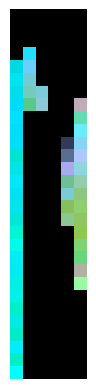

Epoch [286/300], Batch 0/64, Discriminator Loss: 0.5241, Generator Loss: 1.6492
tensor([[1.5066],
        [3.2890],
        [1.1654]], requires_grad=True)
tensor([[-0.5281],
        [-1.9178],
        [-0.7098]], requires_grad=True)
mean disc rating of real images: tensor(1.0420)
mean disc rating of fake images: tensor(-0.5701)
Epoch: 288 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [02:05<00:00,  1.96s/it]

real image:


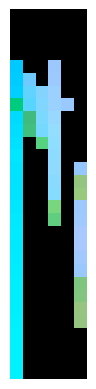

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


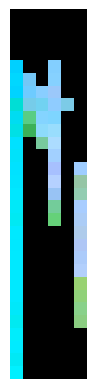

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


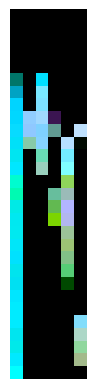

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


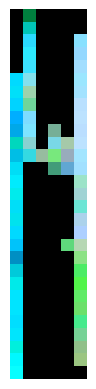

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


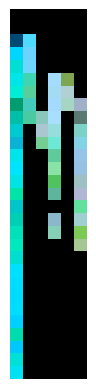

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


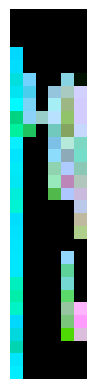

Epoch [287/300], Batch 0/64, Discriminator Loss: 0.4992, Generator Loss: 1.5170
tensor([[-0.6988],
        [ 1.4665],
        [-0.8169]], requires_grad=True)
tensor([[-1.7026],
        [-1.6204],
        [ 0.6528]], requires_grad=True)
mean disc rating of real images: tensor(0.7397)
mean disc rating of fake images: tensor(-0.9805)
Epoch: 289 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:36<00:00,  1.50s/it]

real image:


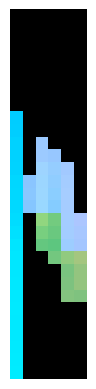

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


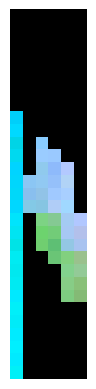

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


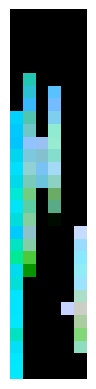

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


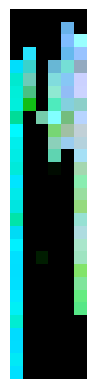

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


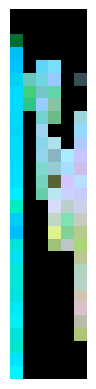

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


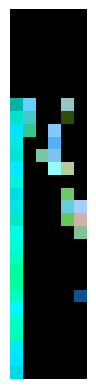

Epoch [288/300], Batch 0/64, Discriminator Loss: 0.5769, Generator Loss: 1.7467
tensor([[1.6004],
        [2.3817],
        [2.0494]], requires_grad=True)
tensor([[ 0.8793],
        [-0.7070],
        [-2.8915]], requires_grad=True)
mean disc rating of real images: tensor(1.4122)
mean disc rating of fake images: tensor(-0.2417)
Epoch: 290 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:36<00:00,  1.50s/it]

real image:


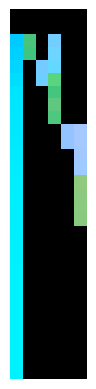

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


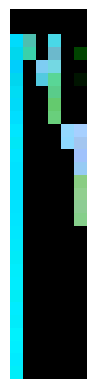

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


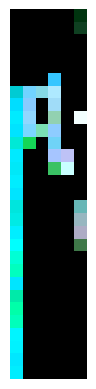

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


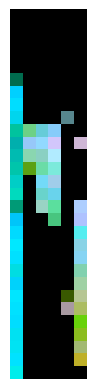

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


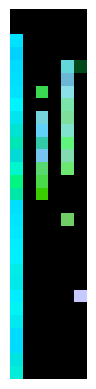

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


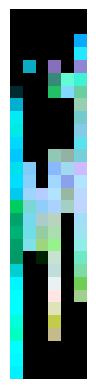

Epoch [289/300], Batch 0/64, Discriminator Loss: 0.5520, Generator Loss: 1.2417
tensor([[ 2.8330],
        [ 0.1583],
        [-1.3995]], requires_grad=True)
tensor([[ 0.2783],
        [-0.3372],
        [ 0.7455]], requires_grad=True)
mean disc rating of real images: tensor(0.3741)
mean disc rating of fake images: tensor(-1.2009)
Epoch: 291 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.50s/it]

real image:


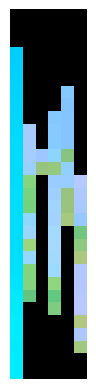

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


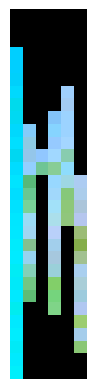

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


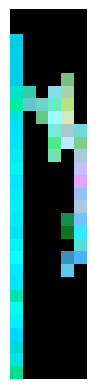

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


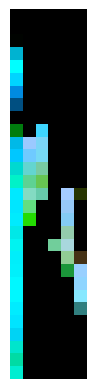

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


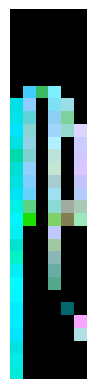

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


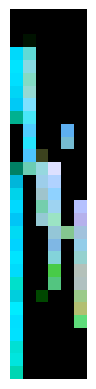

Epoch [290/300], Batch 0/64, Discriminator Loss: 0.4700, Generator Loss: 1.4232
tensor([[ 3.7149],
        [-0.6553],
        [-0.5947]], requires_grad=True)
tensor([[-1.8362],
        [ 0.8952],
        [-2.3413]], requires_grad=True)
mean disc rating of real images: tensor(0.7301)
mean disc rating of fake images: tensor(-1.2727)
Epoch: 292 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:48<00:00,  1.69s/it]

real image:


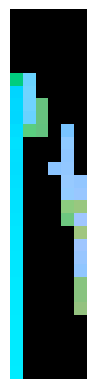

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


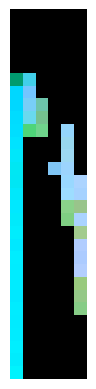

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


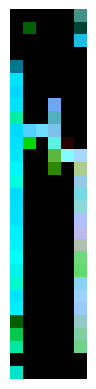

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


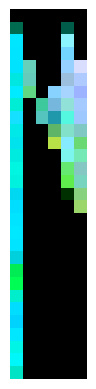

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


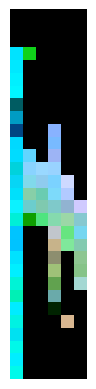

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


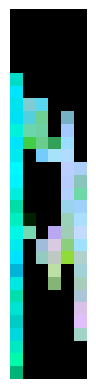

Epoch [291/300], Batch 0/64, Discriminator Loss: 0.6323, Generator Loss: 2.2737
tensor([[2.4052],
        [0.3995],
        [1.8337]], requires_grad=True)
tensor([[ 0.8549],
        [-1.0427],
        [-0.4202]], requires_grad=True)
mean disc rating of real images: tensor(2.1135)
mean disc rating of fake images: tensor(0.4386)
Epoch: 293 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:37<00:00,  1.53s/it]

real image:


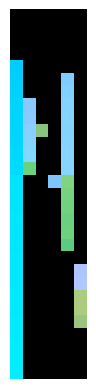

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


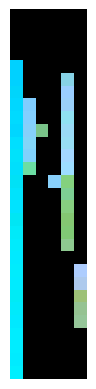

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


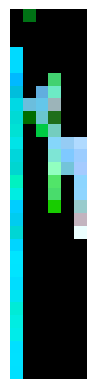

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


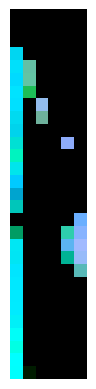

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


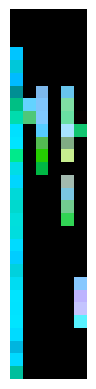

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


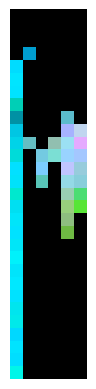

Epoch [292/300], Batch 0/64, Discriminator Loss: 0.5871, Generator Loss: 1.9024
tensor([[2.8270],
        [3.9724],
        [0.6145]], requires_grad=True)
tensor([[-0.4843],
        [ 1.2447],
        [ 1.4933]], requires_grad=True)
mean disc rating of real images: tensor(1.6871)
mean disc rating of fake images: tensor(0.1256)
Epoch: 294 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:34<00:00,  1.48s/it]

real image:


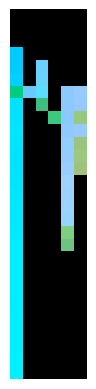

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


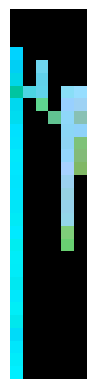

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


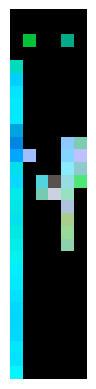

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


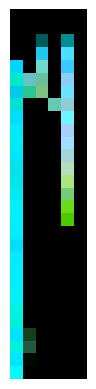

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


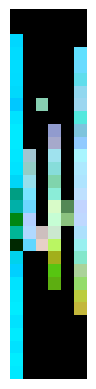

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


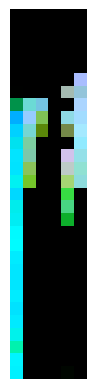

Epoch [293/300], Batch 0/64, Discriminator Loss: 0.5682, Generator Loss: 1.3467
tensor([[ 1.4211],
        [ 1.7697],
        [-0.7114]], requires_grad=True)
tensor([[-1.1892],
        [-0.0875],
        [-3.4250]], requires_grad=True)
mean disc rating of real images: tensor(0.0866)
mean disc rating of fake images: tensor(-1.5358)
Epoch: 295 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:34<00:00,  1.48s/it]

real image:


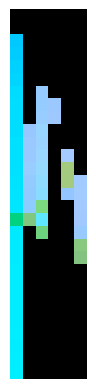

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


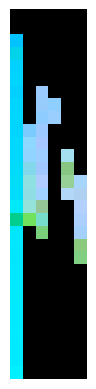

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


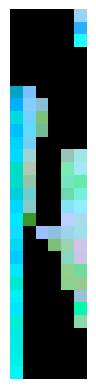

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


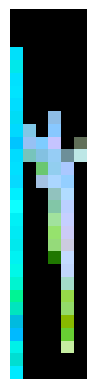

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


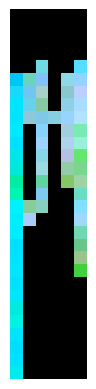

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


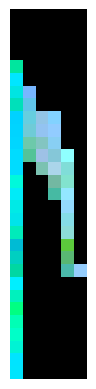

Epoch [294/300], Batch 0/64, Discriminator Loss: 0.5228, Generator Loss: 1.6112
tensor([[ 1.7020],
        [-0.0829],
        [ 1.0225]], requires_grad=True)
tensor([[ 1.4138],
        [-0.5112],
        [ 0.0927]], requires_grad=True)
mean disc rating of real images: tensor(0.7377)
mean disc rating of fake images: tensor(-0.8077)
Epoch: 296 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:35<00:00,  1.49s/it]

real image:


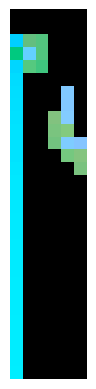

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


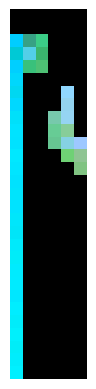

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


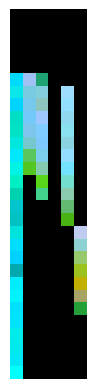

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


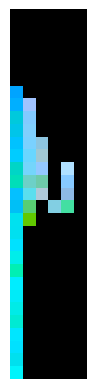

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


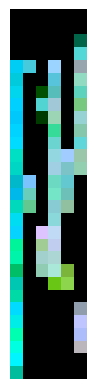

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


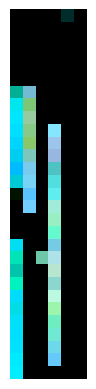

Epoch [295/300], Batch 0/64, Discriminator Loss: 0.4905, Generator Loss: 1.2109
tensor([[ 3.3313],
        [ 0.1910],
        [-0.2958]], requires_grad=True)
tensor([[-0.5161],
        [-0.7215],
        [-0.0822]], requires_grad=True)
mean disc rating of real images: tensor(0.4575)
mean disc rating of fake images: tensor(-1.4501)
Epoch: 297 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:36<00:00,  1.50s/it]

real image:


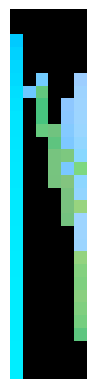

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


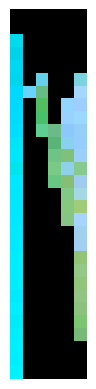

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


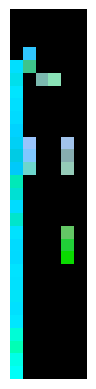

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


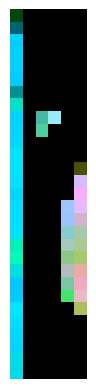

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


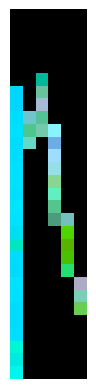

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


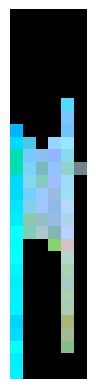

Epoch [296/300], Batch 0/64, Discriminator Loss: 0.5661, Generator Loss: 1.7085
tensor([[0.9519],
        [0.7859],
        [1.1610]], requires_grad=True)
tensor([[-1.1815],
        [-2.2733],
        [ 0.7491]], requires_grad=True)
mean disc rating of real images: tensor(1.2186)
mean disc rating of fake images: tensor(-0.4815)
Epoch: 298 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:40<00:00,  1.57s/it]

real image:


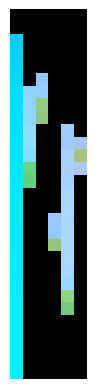

reconstructed image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


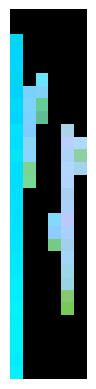

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


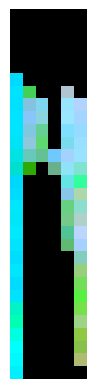

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


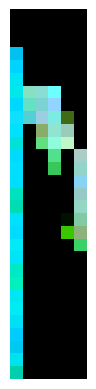

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


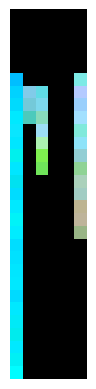

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


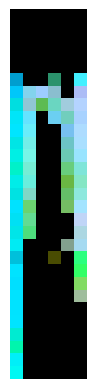

Epoch [297/300], Batch 0/64, Discriminator Loss: 0.5920, Generator Loss: 2.3154
tensor([[0.6545],
        [1.8497],
        [2.3321]], requires_grad=True)
tensor([[ 3.5396],
        [ 1.4823],
        [-2.3466]], requires_grad=True)
mean disc rating of real images: tensor(2.1083)
mean disc rating of fake images: tensor(0.1576)
Epoch: 299 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:41<00:00,  1.59s/it]

real image:


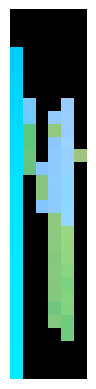

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


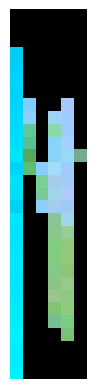

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


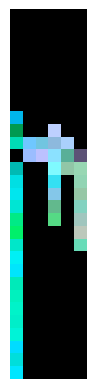

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


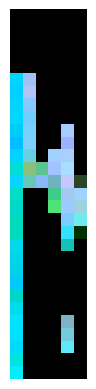

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


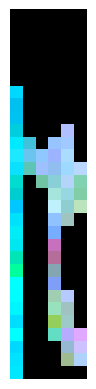

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


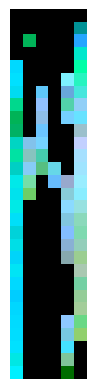

Epoch [298/300], Batch 0/64, Discriminator Loss: 0.4785, Generator Loss: 1.5569
tensor([[1.6770],
        [0.7047],
        [0.4885]], requires_grad=True)
tensor([[-0.8296],
        [ 1.0344],
        [-1.9826]], requires_grad=True)
mean disc rating of real images: tensor(1.0957)
mean disc rating of fake images: tensor(-0.5760)
Epoch: 300 / 300
Training generator


100%|███████████████████████████████████████████| 64/64 [01:40<00:00,  1.57s/it]

real image:


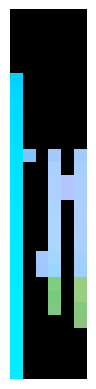

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


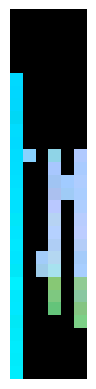

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


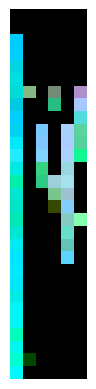

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


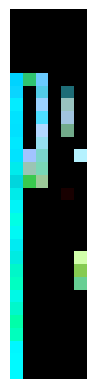

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


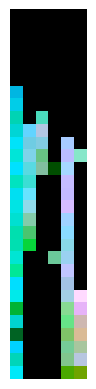

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


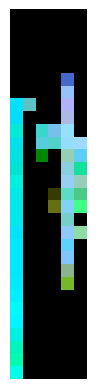

Epoch [299/300], Batch 0/64, Discriminator Loss: 0.5101, Generator Loss: 1.4326
tensor([[1.6278],
        [3.5246],
        [0.3388]], requires_grad=True)
tensor([[-0.7678],
        [-0.7220],
        [-1.0252]], requires_grad=True)
mean disc rating of real images: tensor(1.0109)
mean disc rating of fake images: tensor(-0.7293)


In [169]:
nsnap = six_dataset.shape[2]
nbr = six_dataset.shape[3]
nvar = six_dataset.shape[1]
printer = False

num_epochs = 300
lr = 3e-4
batch_size = 128
latent_dim = 300

dataloader = DataLoader(six_dataset, shuffle=True, batch_size = batch_size)

discriminator = Discriminator_big(nvar, nsnap, nbr, printer).to(device)
encoder = Encoder_big(nvar, nsnap, nbr, latent_size, printer).to(device)
generator = Generator_big(nvar, nsnap, nbr, latent_size, printer).to(device)

optimizer_enc_dec = optim.Adam(list(encoder.parameters()) + list(generator.parameters()), lr=3e-4)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=3e-4)

# Define loss function
criterion = nn.BCEWithLogitsLoss()

num_train_gen = 1
noise_uniform = True
custom_loss = False
recon_scale = 10

for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1} / {num_epochs}")
    if epoch % num_train_gen == 0: 
        print("Training generator")
        
    discriminator.train()
    encoder.train()
    generator.train()
    for real_images in tqdm.tqdm(dataloader):
        bs = real_images.shape[0]
        # Train Discriminator
        discriminator.zero_grad()
        real_images = real_images.to(dtype=torch.float32).to(device)

        # Discriminator forward pass with real images
        real_output = discriminator(real_images).view(-1, 1)
        
        # Generate fake images
        if noise_uniform:
            high = 1.0
            low = -1.0
            uniform_noise = torch.rand(bs, latent_dim) * (high - (low)) + (low)
            noise = uniform_noise.to(device)
        
        else:
            noise = torch.randn(bs, latent_dim).to(device)
        fake_images = generator(noise)

        inputs = torch.cat([real_images, fake_images.detach()])
        labels = torch.cat([torch.ones(bs, 1), torch.zeros(bs, 1)]) # fake
        
        # Discriminator forward pass with fake images
        fake_output = discriminator(fake_images.detach()).view(-1, 1)
        output = discriminator(inputs)
        if custom_loss:
            fake_loss = - discriminator_classic_loss(real_output, fake_output)
        else:
            fake_loss = criterion(output, labels)
        
        # Backpropagate and update discriminator weights
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_discriminator.step()
        
        if epoch % num_train_gen == 0: 
            # Train Generator (Encoder + Decoder)
            encoder.zero_grad()
            generator.zero_grad()

            recon = encoder(real_images)
            recon_images = generator(recon)
            output = discriminator(fake_images).view(-1, 1)

            # Generator loss
            if custom_loss:
                g_loss = -generator_classic_loss(output)
            else:
                real_labels = torch.ones(bs, 1)
                g_loss = criterion(output, real_labels)
                
            loss_rec = custom_reconstruction_loss(real_images, recon_images) * recon_scale

            loss_g = g_loss + loss_rec
            # Backpropagate and update generator weights
            loss_g.backward()
            optimizer_enc_dec.step()
        
        # Print losses
        
    if epoch % 1 == 0 or epoch + 1 == num_epochs:
        with torch.no_grad():
            discriminator.eval()
            encoder.eval()
            generator.eval()

            print("real image:")
            test = real_images[0]
            img = test.permute(1, 2, 0).detach().numpy()
            plt.imshow(img)
            plt.axis('off')  # Optional: Turn off axis ticks and labels
            plt.show()

            print("reconstructed image:")
            real = real_images.to(dtype=torch.float32)
            encoded = encoder(real)
            reconstructed = generator(encoded)
            recon = reconstructed.reshape(-1, nvar, nsnap, nbr)
            img = recon[0].permute(1, 2, 0).detach().numpy()
            plt.imshow(img)
            plt.axis('off')  # Optional: Turn off axis ticks and labels
            plt.show()


            # generate and show fake images
            print("random created images:")
            fixed_noise = torch.randn((batch_size, latent_size)).to(device)
            fake = generator(fixed_noise).reshape(-1, nvar, nsnap, nbr)
            im = random.randint(0, batch_size - 5)
            img = fake[im : im + 4]
            #print(img[0])
            for im in img:
                img = im.permute(1, 2, 0).detach().numpy()
                plt.imshow(img)
                plt.axis('off')  # Optional: Turn off axis ticks and labels
                plt.show()
                
                
            print(f"Epoch [{epoch}/{num_epochs}], Batch {batch_idx}/{len(dataloader)}, "
                  f"Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")

            print(real_output[:3])
            print(fake_output[:3])
            print("mean disc rating of real images:", torch.mean(real_output))
            print("mean disc rating of fake images:", torch.mean(fake_output))

In [194]:
#disc_name = "models/attempt1/discriminator_first_success.pt"
#gen_name = "models/attempt1/generator_first_success.pt"
#enc_name = "models/attempt1/encoder_first_success.pt"
    
    
#save_model(encoder, decoder, discriminator,
#               optimizer_discriminator, optimizer_enc_dec,
#               disc_name, gen_name, enc_name,
#               nbr, nsnap, nvar, latent_dim)

saved discriminator as models/attempt1/discriminator_first_success.pt
saved generator as models/attempt1/generator_first_success.pt
saved encoder as models/attempt1/encoder_first_success.pt


In [11]:
disc_name = "models/attempt1/discriminator_first_success.pt"
gen_name = "models/attempt1/generator_first_success.pt"
enc_name = "models/attempt1/encoder_first_success.pt"

saved_generator1_state_dict = torch.load(gen_name)
generator_trained1 = saved_generator1_state_dict["generator"]
latent_dim1 = saved_generator1_state_dict["latent_space"]
num_branches1 = saved_generator1_state_dict["num_branches"]
nsnap1 = saved_generator1_state_dict["nsnap"]
nvar1 = saved_generator1_state_dict["nvar"]
printer = False

model = Generator_big(nvar1, nsnap1, num_branches1, latent_dim1, printer)
model.load_state_dict(generator_trained1)


<All keys matched successfully>

In [23]:
a = [1, 2, 3, 4]
b = torch.tensor(a, dtype=torch.float32)
b.mean()

tensor(2.5000)


Run 1 / 10:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


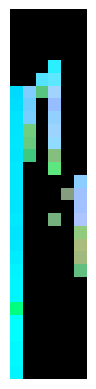

generated 8161 images


Percentage of consistant images = 9.81%

Run 2 / 10:
reconstructed image:


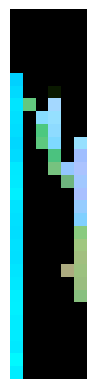

generated 8161 images


Percentage of consistant images = 10.61%

Run 3 / 10:
reconstructed image:


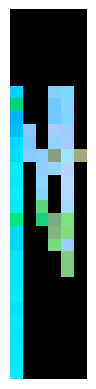

generated 8161 images


Percentage of consistant images = 10.57%

Run 4 / 10:
reconstructed image:


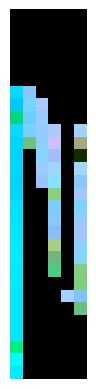

generated 8161 images


Percentage of consistant images = 9.64%

Run 5 / 10:
reconstructed image:


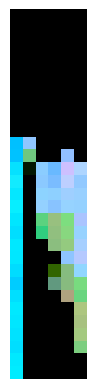

generated 8161 images


Percentage of consistant images = 9.29%

Run 6 / 10:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


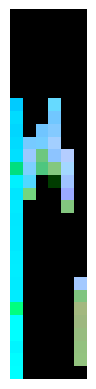

generated 8161 images


Percentage of consistant images = 10.06%

Run 7 / 10:
reconstructed image:


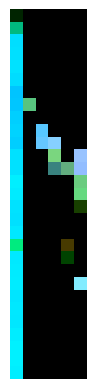

generated 8161 images


Percentage of consistant images = 9.74%

Run 8 / 10:
reconstructed image:


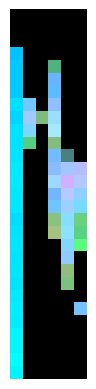

generated 8161 images


Percentage of consistant images = 10.45%

Run 9 / 10:
reconstructed image:


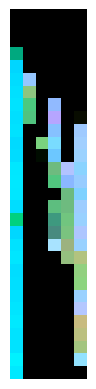

generated 8161 images


Percentage of consistant images = 10.44%

Run 10 / 10:
reconstructed image:


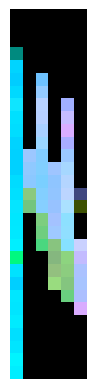

generated 8161 images


Percentage of consistant images = 10.53%
Constistancy average = 10.12%
Constistancy min = 9.29%
Constistancy max = 10.61%


In [25]:
consistancy = []
for i in range(10):
    print(f"\nRun {i + 1} / 10:")
    generated_images_model1 = create_generated_images(model, latent_dim1, six_dataset.shape, noise_uniform = True)
    consist_data, inconsistent_images, percentage = check_consistency(generated_images_model1)
    consistancy.append(percentage)
    
consistancy = torch.tensor(consistancy, dtype=torch.float32)
    
print(f"Constistancy average = {consistancy.mean():.2f}%")
print(f"Constistancy min = {consistancy.min():.2f}%")
print(f"Constistancy max = {consistancy.max():.2f}%")

In [29]:
check_branch_length(generated_images_model1)

number of images with 1 branches is: 0
number of images with 2 branches is: 3
number of images with 3 branches is: 50
number of images with 4 branches is: 343
number of images with 5 branches is: 1872
number of images with 6 branches is: 5893
number of images with 7 branches is: 0
number of images with 8 branches is: 0
number of images with 9 branches is: 0
number of images with 10 branches is: 0
double check that all images are counted: total images is 8161 = 8161


In [34]:
check_branch_length(consist_data)

number of images with 1 branches is: 0
number of images with 2 branches is: 0
number of images with 3 branches is: 6
number of images with 4 branches is: 23
number of images with 5 branches is: 81
number of images with 6 branches is: 749
number of images with 7 branches is: 0
number of images with 8 branches is: 0
number of images with 9 branches is: 0
number of images with 10 branches is: 0
double check that all images are counted: total images is 859 = 859


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 36:


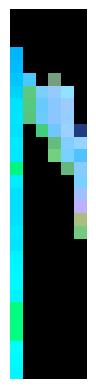

image 580:


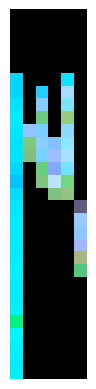

image 123:


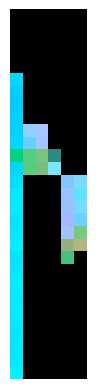

In [78]:
images = plot_images(consist_data, 3)

Real images:


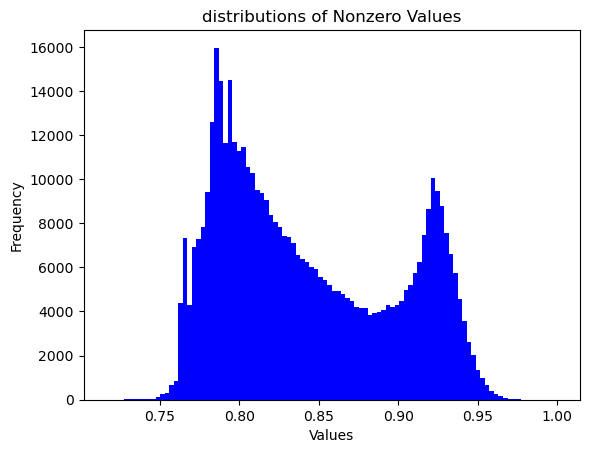

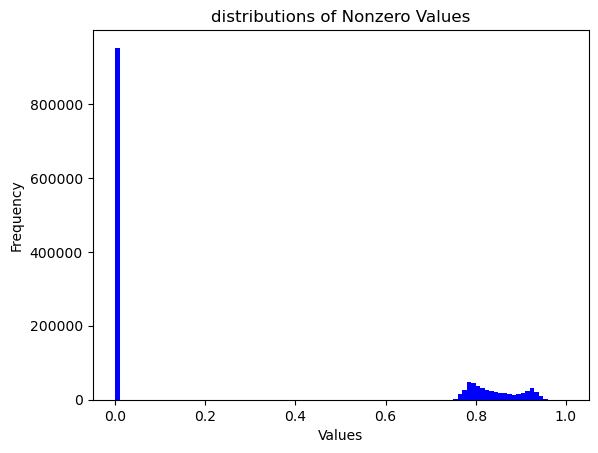

number of nonzero values = 468178
Generated images:


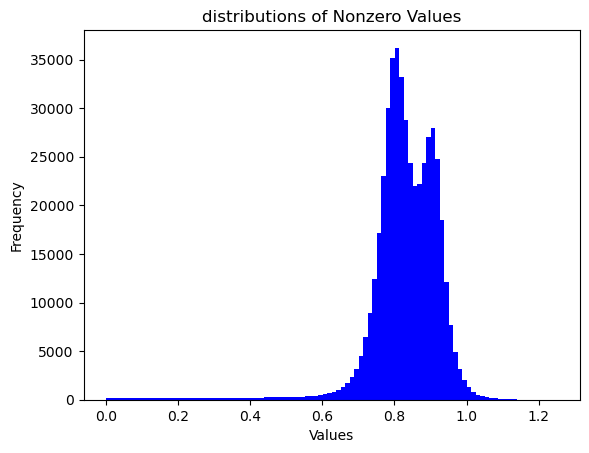

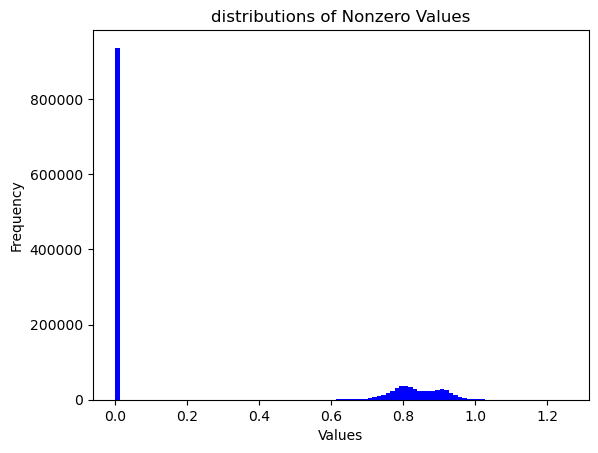

number of nonzero values = 482987


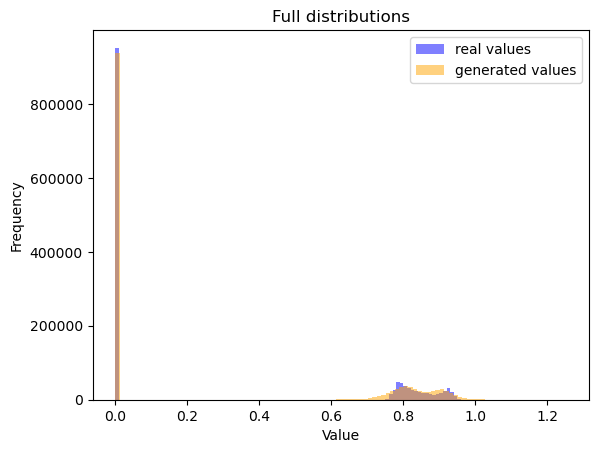

Full distribution:
KS Statistic: 0.03775455734943467
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0016:
The distributions are significantly different (reject H0), KS statistic 0.0378 > 0.0016


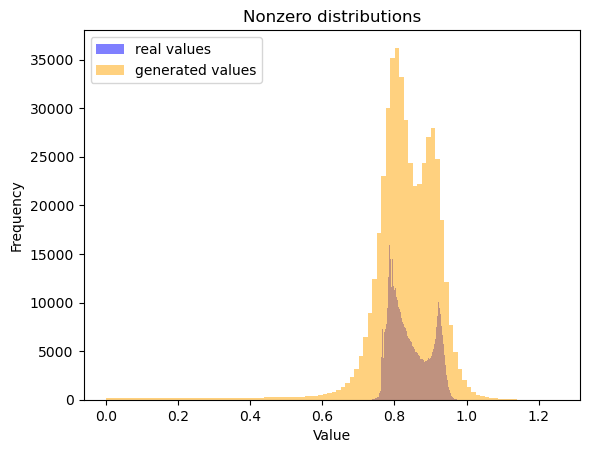

Nonzero distribution:
KS Statistic: 0.14147076878238457
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0028:
The distributions are significantly different (reject H0), KS statistic 0.1415 > 0.0028


(0.03775455734943467, 0.14147076878238457)

In [87]:
ks_test(six_dataset, generated_images_model1.detach(), dim = 1)

0.8283534646034241 0.00010149180889129639 1.2513645887374878 400083.96875
0.8432592954678704 0.7161649025418501 1.0 394795.45043355663


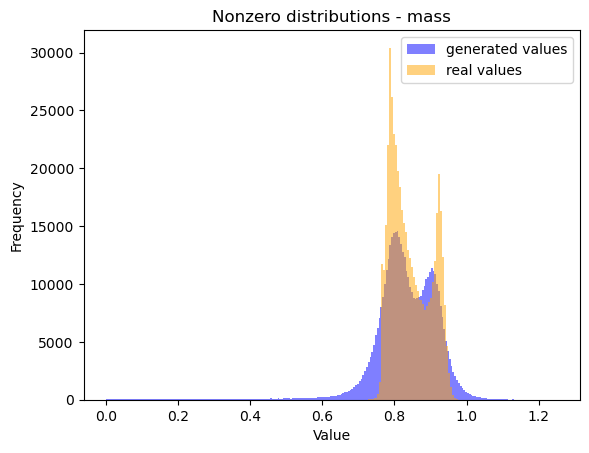

(482987, 468178)

In [147]:
variable = generated_images_model1[:, 1]

# extract nonzero values
nonzero_indices = torch.nonzero(variable.flatten())
nonzero_value = variable.flatten()[nonzero_indices[:, 0]]
print(nonzero_value.mean().item(), nonzero_value.min().item(), nonzero_value.max().item(), nonzero_value.sum().item())

variable = six_dataset[:, 1]

# extract nonzero values
nonzero_indices = torch.nonzero(variable.flatten())
nonzero_value_six = variable.flatten()[nonzero_indices[:, 0]]
print(nonzero_value_six.mean().item(), nonzero_value_six.min().item(), nonzero_value_six.max().item(), nonzero_value_six.sum().item())


plt.hist(nonzero_value.flatten().numpy(), bins=250, alpha=0.5, label='generated values', color='blue')
plt.hist(nonzero_value_six.flatten().numpy(), bins=50, alpha=0.5, label='real values', color='orange')

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Nonzero distributions - mass')
plt.legend()

# Show plot
plt.show()



len(nonzero_value), len(nonzero_value_six.flatten().numpy())

In [154]:
mask = (nonzero_value > 0.7161649025418501 ) & (nonzero_value < 1.0)

# Count the number of True values in the mask
count = torch.sum(mask).item()
count * 100 / len(nonzero_value)

93.38719261595033

# Inconsistency check

In [157]:
consist_data_test, inconsistent_images_test, percentage_test = check_consistency(inconsistent_images[:10], True)

inconsistent images:
 image index = 0, inconsistent because gaps in branch 2 at row 13
 image index = 1, inconsistent because zero not same index: zero in 99.18% of same spots across channels
 image index = 1, inconsistent because gaps in branch 5 at row 27
 image index = 2, inconsistent because zero not same index: zero in 99.11% of same spots across channels
 image index = 2, inconsistent because dist in main branch is not zero: zero in 96.55% of distance main branch
 image index = 3, inconsistent because zero not same index: zero in 98.37% of same spots across channels
 image index = 4, inconsistent because zero not same index: zero in 99.13% of same spots across channels
 image index = 4, inconsistent because dist in main branch is not zero: zero in 93.10% of distance main branch
 image index = 4, inconsistent because gaps in branch 3 at row 12
 image index = 5, inconsistent because zero not same index: zero in 99.19% of same spots across channels
 image index = 5, inconsistent bec

image 6:


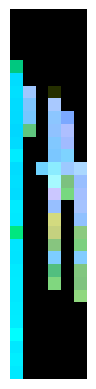

image 5:


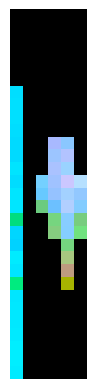

image 8:


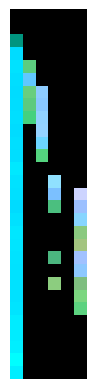

image 4:


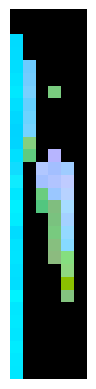

image 1:


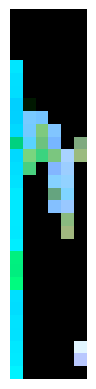

In [160]:
merger_trees_consistent_generated = plot_images(inconsistent_images_test, 5)

In [163]:
merger_trees_consistent_generated[3]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4277, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4496, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4730, 0.0000, 0.4780, 0.0000, 0.0000],
         [0.0000, 0.3993, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4243, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4593, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5226, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3796, 0.0000, 0.7182, 0.0000, 0.0000],
         [0.0679, 0.0000, 0.6978, 0.6412, 0.6252, 0.0000],
         [0.0619, 0.0000, 0.6411, 0.6943, 0.7509, 0.0000],
         [0.0000, 0.0000, 0.4181, 0.6044, 0.7181, 0.0000],
         [0.0000, 0.0000, 0.3245, 0.5045, 0.6536, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.4812, 0.6452, 0.0000

0.0034482758620689655


Dist:


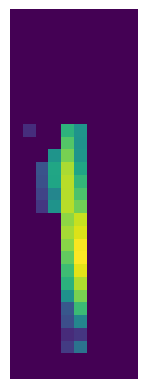

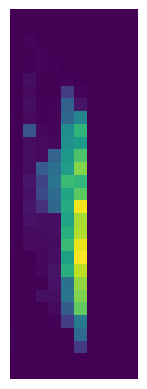


Mass:


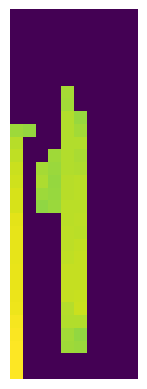

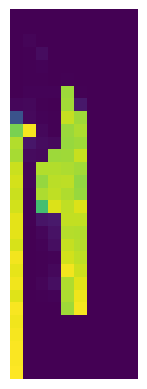


Subhalo


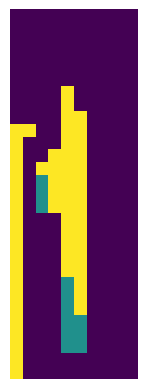

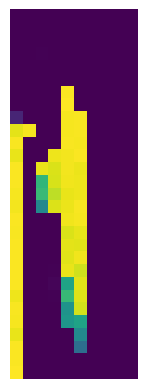

In [30]:
im = random.randint(0, len(six_dataset_zero_one))
image = six_dataset_zero_one[im : im + 16].to(dtype=torch.float32)

recon_enc = encoder_big(image)
recon = generator_big(recon_enc)


i = random.randint(0, 15)


for j in range(3):
    if j == 0:
        print("\nDist:")
    elif j == 1:
        print("\nMass:")
    else:
        print("\nSubhalo")
    img1 = image[i][j].unsqueeze(0)
    img1 = img1.permute(1, 2, 0).detach().numpy()
    plt.imshow(img1)
    plt.axis('off')  # Optional: Turn off axis ticks and labels
    plt.show()

    img2 = recon[i][j].unsqueeze(0)
    img2 = img2.permute(1, 2, 0).detach().numpy()
    plt.imshow(img2)
    plt.axis('off')  # Optional: Turn off axis ticks and labels
    plt.show()




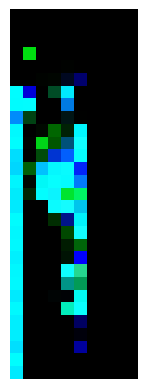

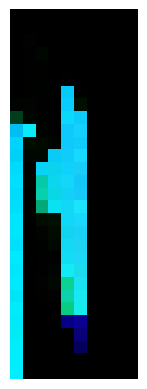

In [105]:
recon_enc = encoder_big(image)[0]

high = 1.0
low = 0.0
scale = 0.7

uniform_noise = scale * torch.rand(latent_size) * (high - (low)) + (low)
recon_enc1 = recon_enc + uniform_noise
recon_enc1.mean()

recon = generator_big(recon_enc1)[0]
img1 = recon.permute(1, 2, 0).detach().numpy()
plt.imshow(img1)
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()


recon1 = generator_big(recon_enc)[0]
img1 = recon1.permute(1, 2, 0).detach().numpy()
plt.imshow(img1)
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

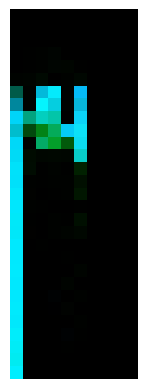

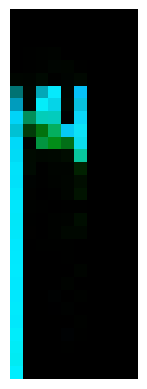

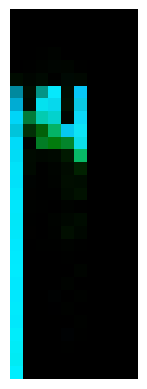

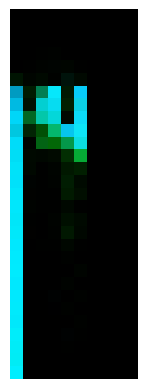

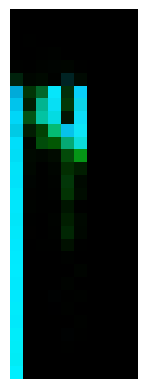

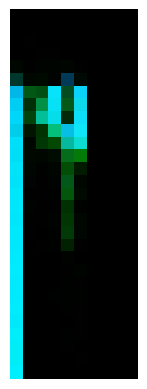

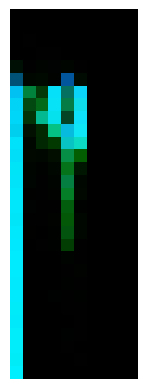

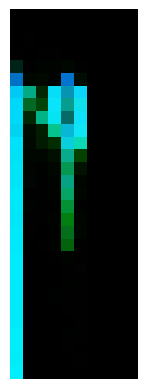

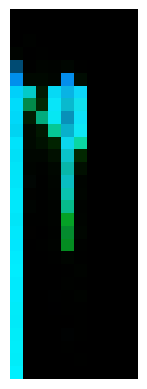

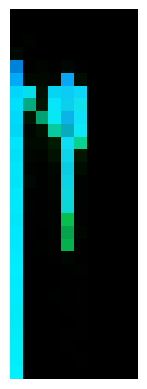

In [185]:
im = random.randint(0, len(dataset_one_one))
image2 = dataset_one_one[im : im + 16].to(dtype=torch.float32)

c1 = encoder_big(image)[9]
c2 = encoder_big(image2)[13]

for i in range(10):
    c = i / 10 * c1 + (10 - i) / 10 * c2
    recon = generator_big(c)[0]
    img1 = recon.permute(1, 2, 0).detach().numpy()
    plt.imshow(img1)
    plt.axis('off')  # Optional: Turn off axis ticks and labels
    plt.show()